# Functions and import

In [1]:
import sqlalchemy
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from IPython.display import display, HTML
from IPython.display import Image
import seaborn as sns
import csv
from dython import nominal
from scipy.stats import chi2_contingency
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder,OneHotEncoder, OrdinalEncoder
from tabulate import tabulate
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics
from xgboost import XGBClassifier
import scikitplot as skplt
from mlxtend.evaluate import lift_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from mixed_naive_bayes import MixedNB
from sklearn.inspection import permutation_importance
import kds
from imblearn.pipeline import Pipeline, make_pipeline
from skopt import BayesSearchCV
import math
from category_encoders import TargetEncoder
import pickle
import dataframe_image as dfi



def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [30, 20]
    plt.rcParams['font.size'] = 19
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.set_option( 'display.expand_frame_repr', False )
    pd.options.display.max_columns = None
    sns.set(font_scale=1.5)
jupyter_settings()


def boxplot_analysis_quantitative(df,nrows,ncols):
    fig, axs = plt.subplots(nrows, ncols)
    plt.tight_layout()
    plt.show()
    
    for column,axis in zip(df.select_dtypes(exclude=[object]).columns, axs.flatten() ):
        sns.boxplot(data=df.select_dtypes(exclude=[object]), y=column, ax=axis)
        axis.tick_params(axis='y', labelsize=15)
        axis.yaxis.label.set_fontsize(15)
        
def data_description(df):
    print('Variables:\n\n{}'.format(df.dtypes), end='\n\n')
    print('Number of rows {}'.format(df.shape[0]), end='\n\n')
    print('Number of columns {}'.format(df.shape[1]), end='\n\n')
    print('NA analysis'.format(end='\n') )
    for i in df.columns:
        print('column {}: {} {}'.format(i,df[i].isna().any(), df[i].isna().sum() ) )
    print('Unique values for each columns'.format(end='\n') )
    for i in df.columns:
        print('column {}: {}'.format(i,df[i].unique() ) )
        
lift_scorer = make_scorer(lift_score)


def precision_at_k(data, k=2000, proba=0):
    
    # create and sorte score by probability
    data['score'] = proba[:,1].tolist()
    data = data.sort_values(by='score', ascending=False)
    
    #reset index
    data= data.reset_index(drop=True) 
    
    #Create ranking order
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k,'precision_at_k']

def recall_at_k(data, k=2000, proba = 0):
    
    # create and sorte score by probability
    data['score'] = proba[:,1].tolist()
    data = data.sort_values(by='score', ascending=False)
    
    #reset index
    data= data.reset_index(drop=True) 
    
    #create ranking order
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k,'recall_at_k']

# Loading Data 

In [2]:
df_raw = pd.read_csv('../data/raw/train.csv')

# Data Description

In [3]:
df1 = df_raw.copy()

In [5]:
df1.head()

id  gender  age  region_code  policy_sales_channel  driving_license vehicle_age vehicle_damage  previously_insured  annual_premium  vintage  response
0   1    Male   44        28.00                 26.00                1   > 2 Years            Yes                   0        40454.00      217         1
1   2    Male   76         3.00                 26.00                1    1-2 Year             No                   0        33536.00      183         0
2   3    Male   47        28.00                 26.00                1   > 2 Years            Yes                   0        38294.00       27         1
3   4    Male   21        11.00                152.00                1    < 1 Year             No                   1        28619.00      203         0
4   5  Female   29        41.00                152.00                1    < 1 Year             No                   1        27496.00       39         0

In [6]:
data_description(df1)

Variables:

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

Number of rows 381109

Number of columns 12

NA analysis
column id: False 0
column gender: False 0
column age: False 0
column region_code: False 0
column policy_sales_channel: False 0
column driving_license: False 0
column vehicle_age: False 0
column vehicle_damage: False 0
column previously_insured: False 0
column annual_premium: False 0
column vintage: False 0
column response: False 0
Unique values for each columns
column id: [     1      2      3 ... 381107 381108 381109]
column gender: ['Male' 'Female']
column age: [44 76 47 21 29 24 23 56 32 41 71 37 25 42 60 65 49 34 51 26 57 

# Data Wrangling

## Change columns types

In [4]:
df1['driving_license'] = df1['driving_license'].apply(lambda x: 'Yes' if x == 1 else 'No')
df1['previously_insured'] = df1['previously_insured'].apply(lambda x: 'Yes' if x == 1 else 'No')
df1['region_code'] = df1['region_code'].astype(int).astype(str)
df1['policy_sales_channel'] = df1['policy_sales_channel'] .astype(int).astype(str)
df1['response'] = df1['response'].apply(lambda x: 'Interested' if x == 1 else 'Not Interested')

## Descriptive statistics

In [8]:
df1.describe(include=['float64','int64'] )

id       age  annual_premium   vintage
count 381109.00 381109.00       381109.00 381109.00
mean  190555.00     38.82        30564.39    154.35
std   110016.84     15.51        17213.16     83.67
min        1.00     20.00         2630.00     10.00
25%    95278.00     25.00        24405.00     82.00
50%   190555.00     36.00        31669.00    154.00
75%   285832.00     49.00        39400.00    227.00
max   381109.00     85.00       540165.00    299.00

## Quantitative Analysis

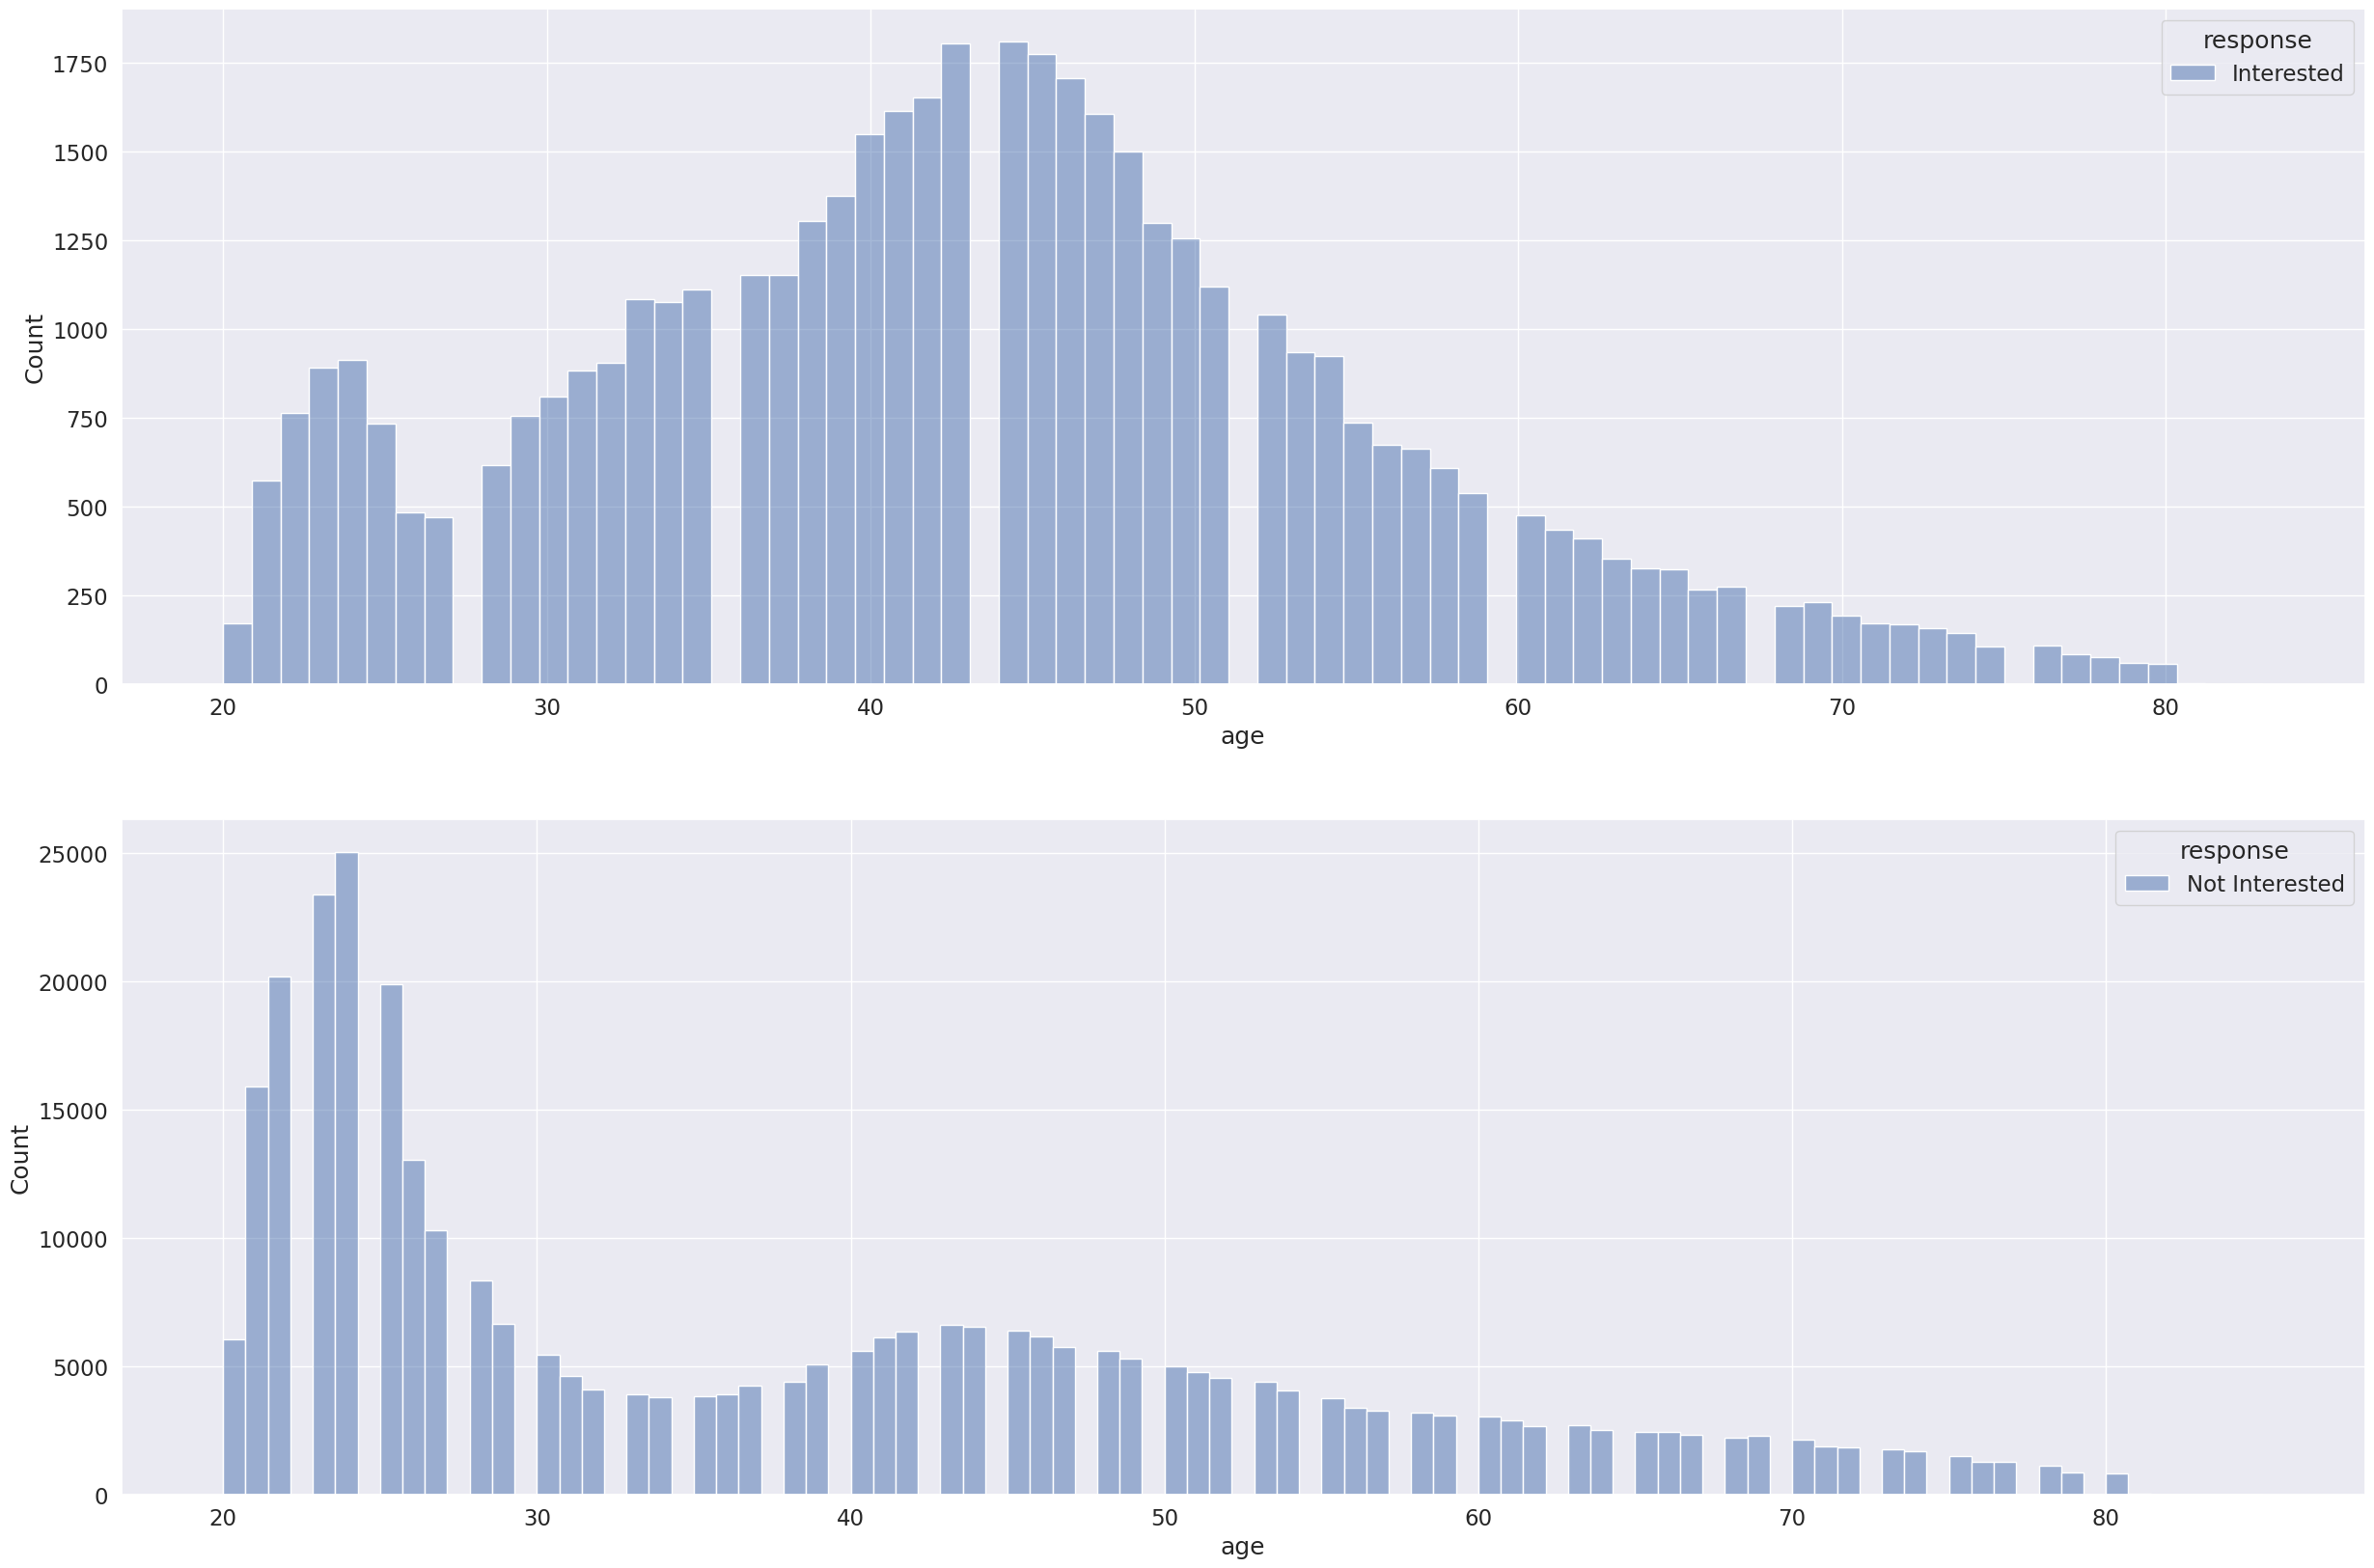

In [9]:
#Age analysis
plt.subplot(2,1,1)
sns.histplot(x='age',data=df1[df1['response'] == 'Interested'],hue='response');

plt.subplot(2,1,2)
sns.histplot(x='age',data=df1[df1['response'] == 'Not Interested'],hue='response');

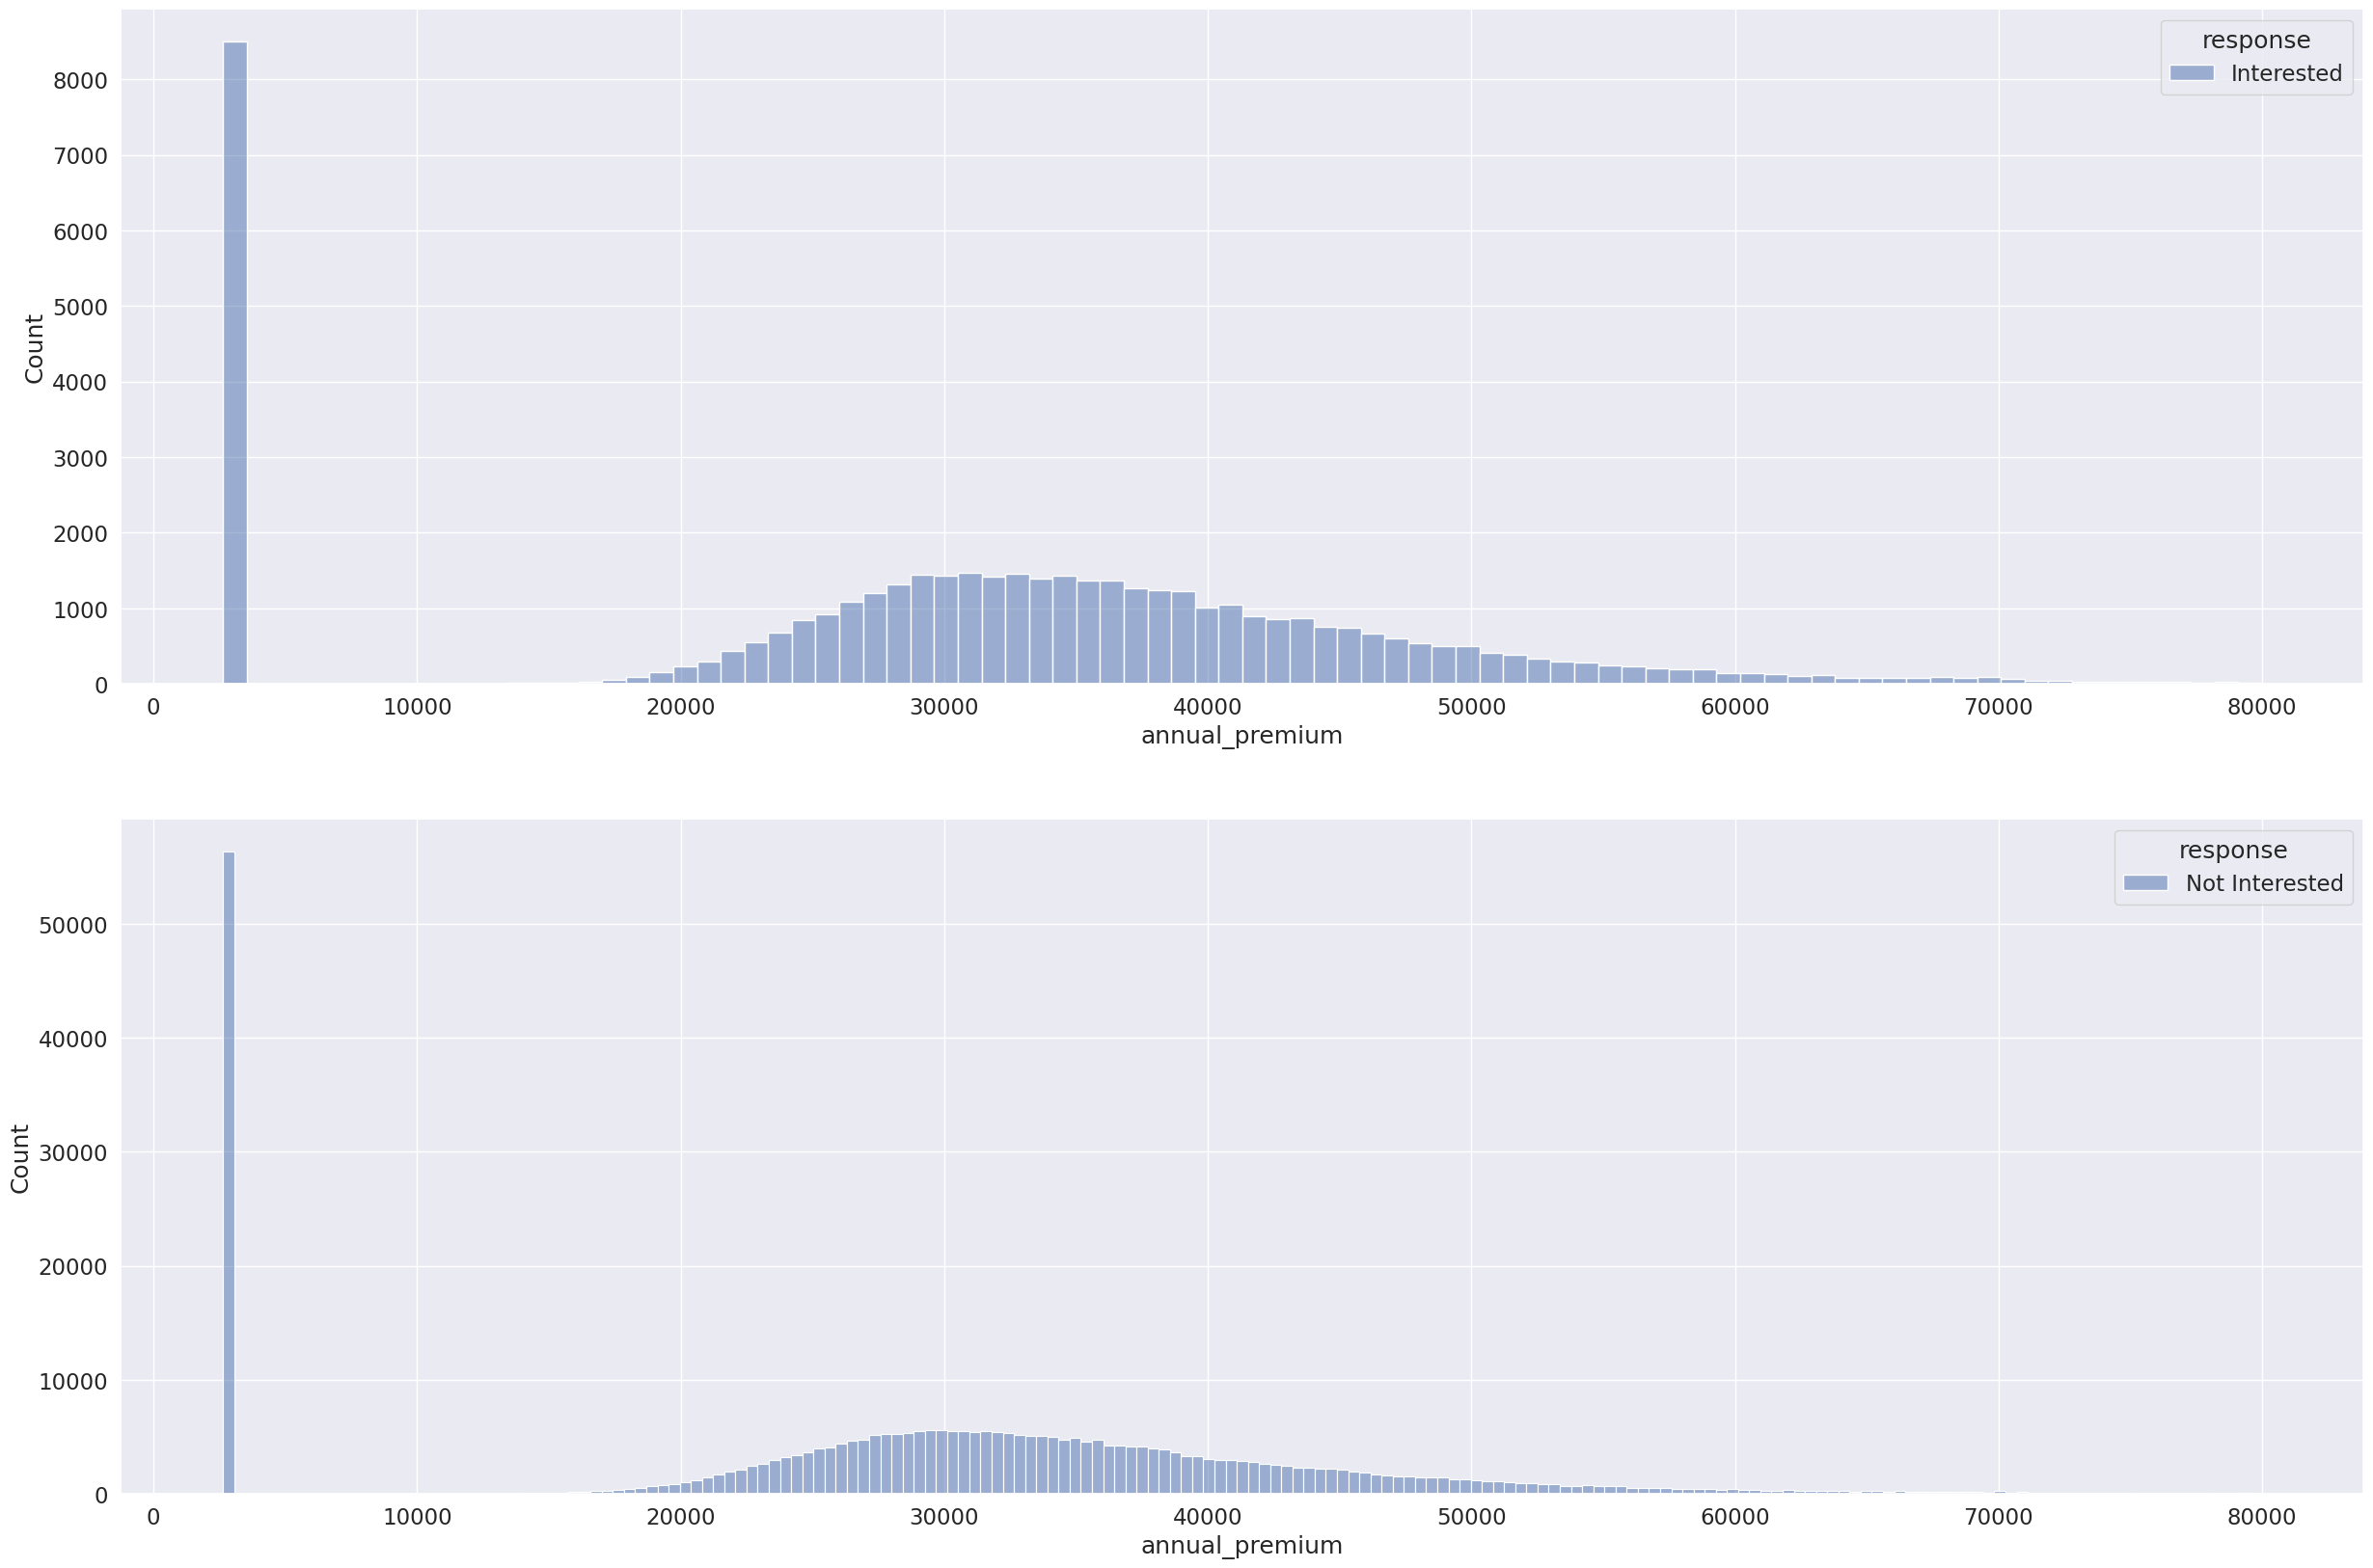

In [10]:
#Annual_premium analysis
plt.subplot(2,1,1)
sns.histplot(x='annual_premium',data=df1[ (df1['response'] == 'Interested')  & (df1['annual_premium'] < 80000) ],hue='response', );

plt.subplot(2,1,2)
sns.histplot(x='annual_premium',data=df1[ (df1['response'] == 'Not Interested')  & (df1['annual_premium'] < 80000) ],hue='response');

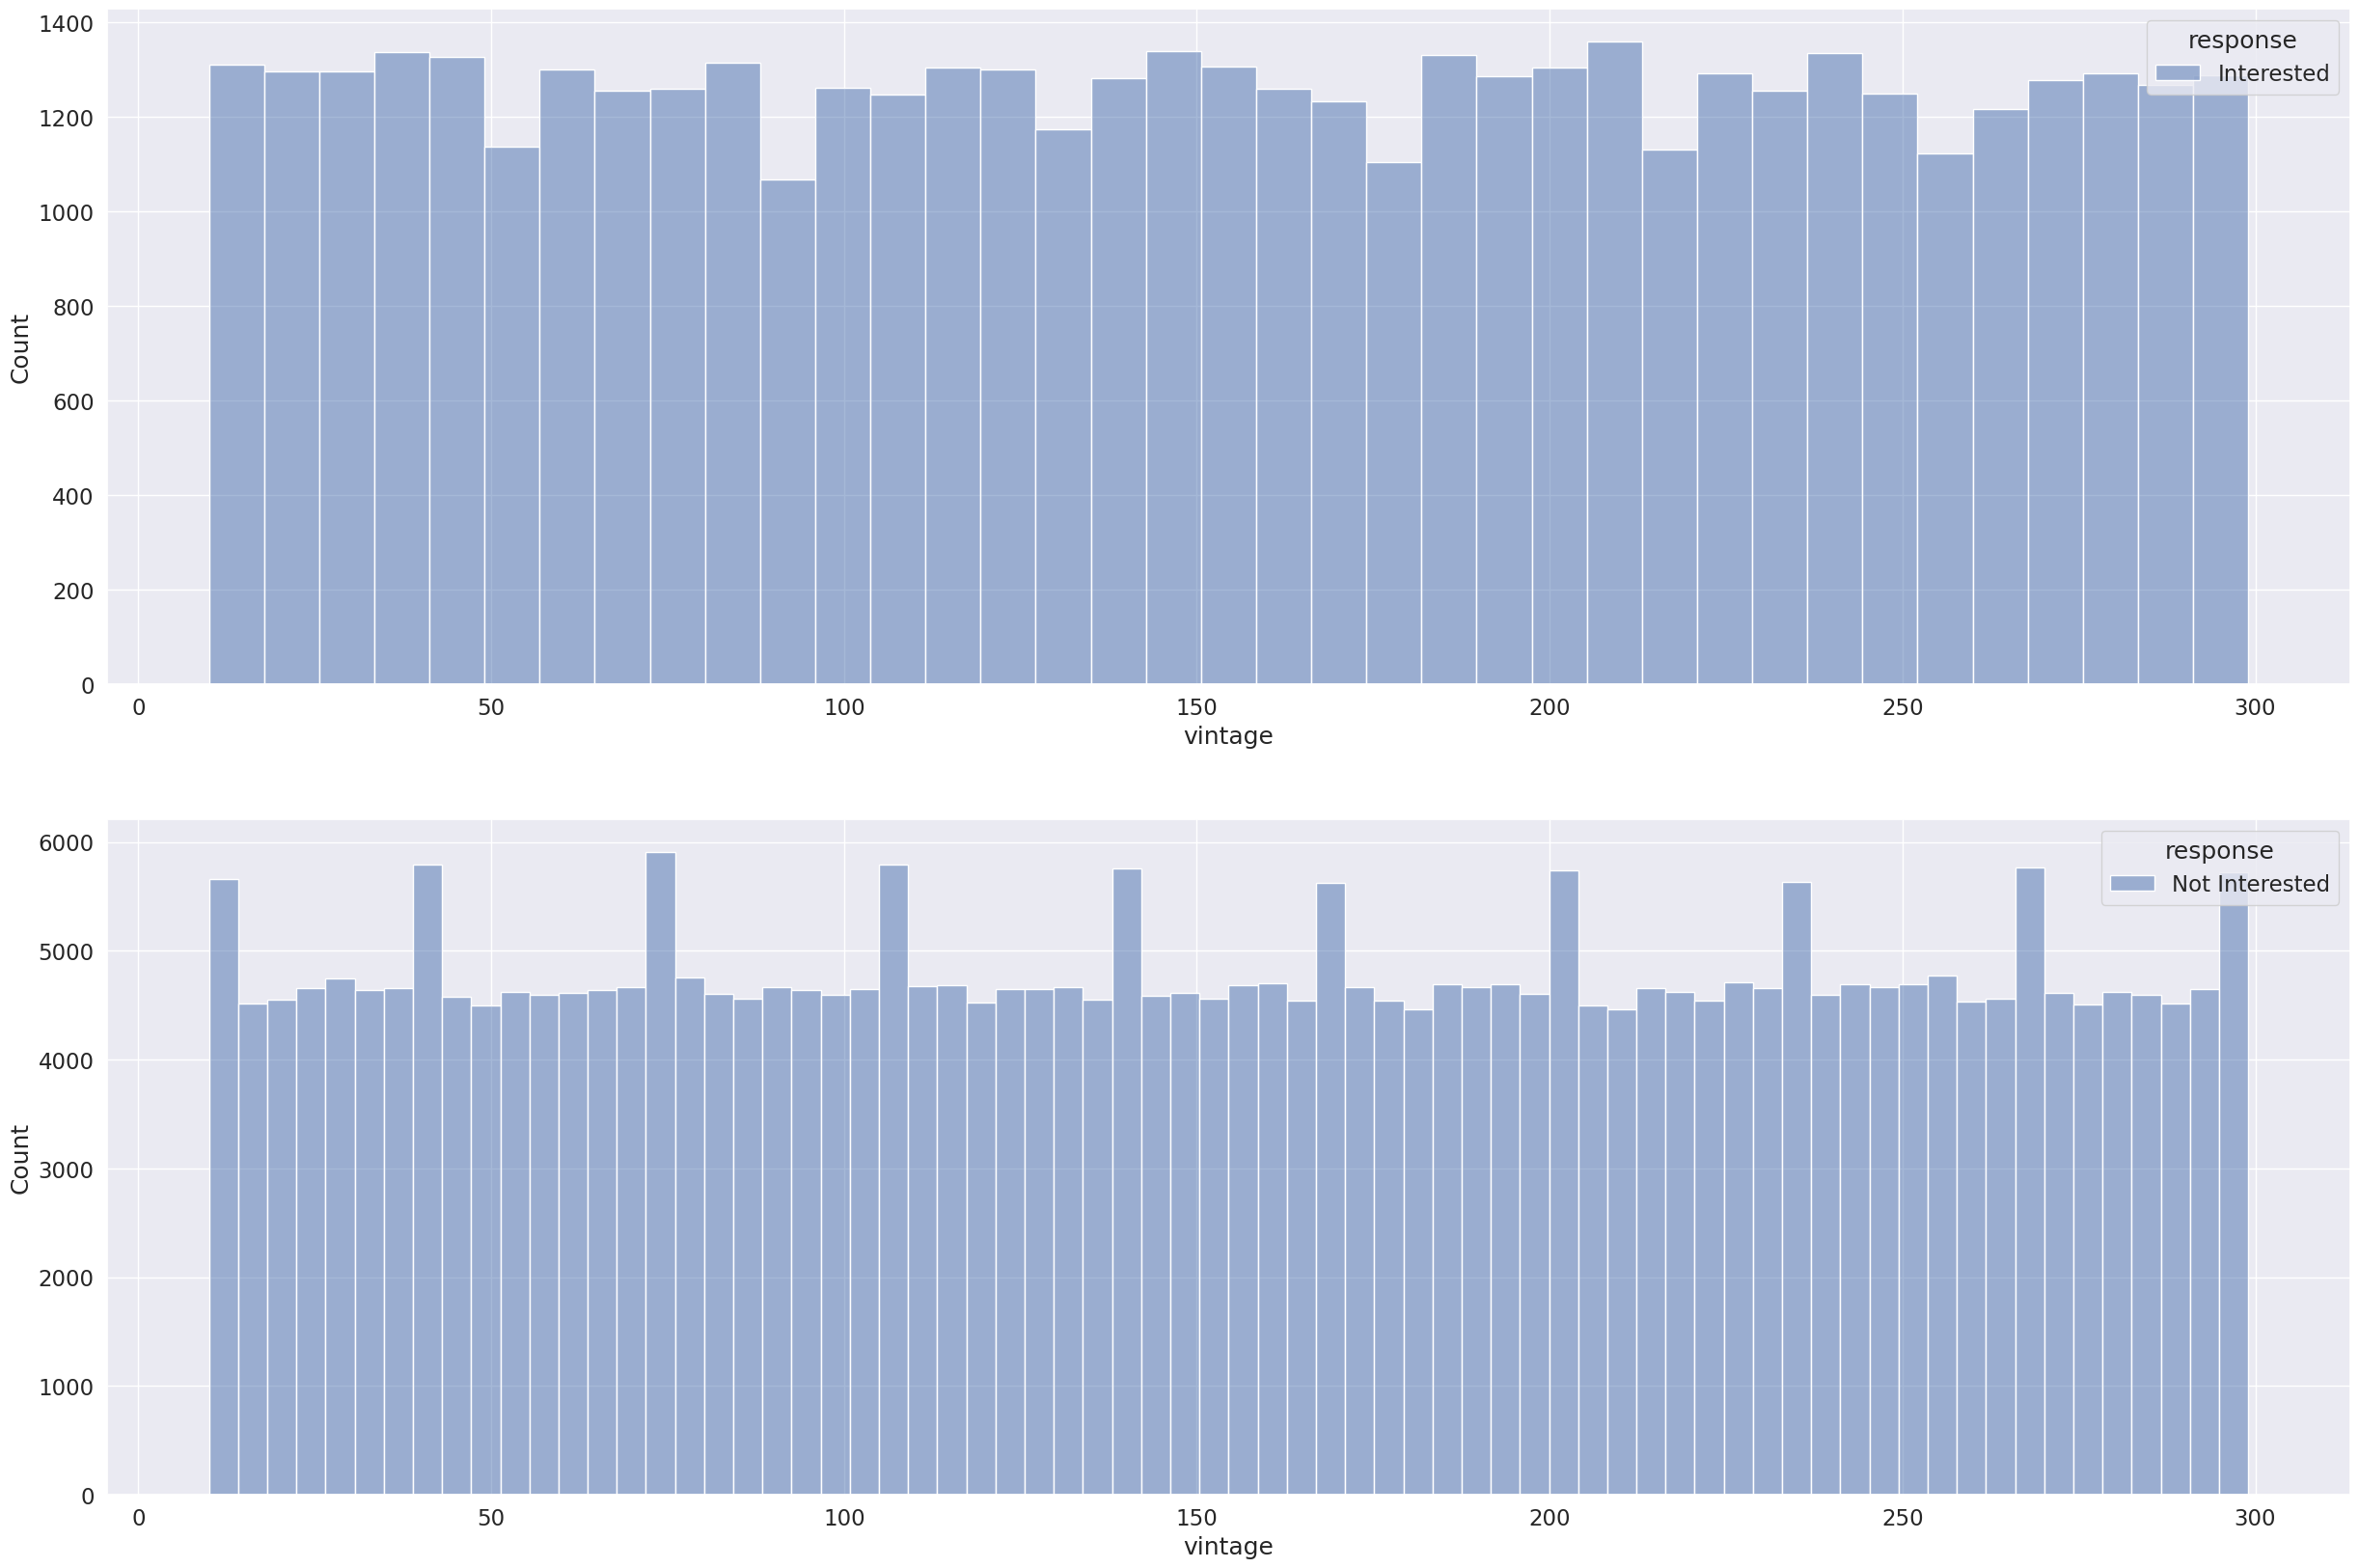

In [11]:
#vintage analysis
plt.subplot(2,1,1)
sns.histplot(x='vintage',data=df1[df1['response'] == 'Interested'],hue='response');

plt.subplot(2,1,2)
sns.histplot(x='vintage',data=df1[df1['response'] == 'Not Interested'],hue='response');

## Categorical Analysis

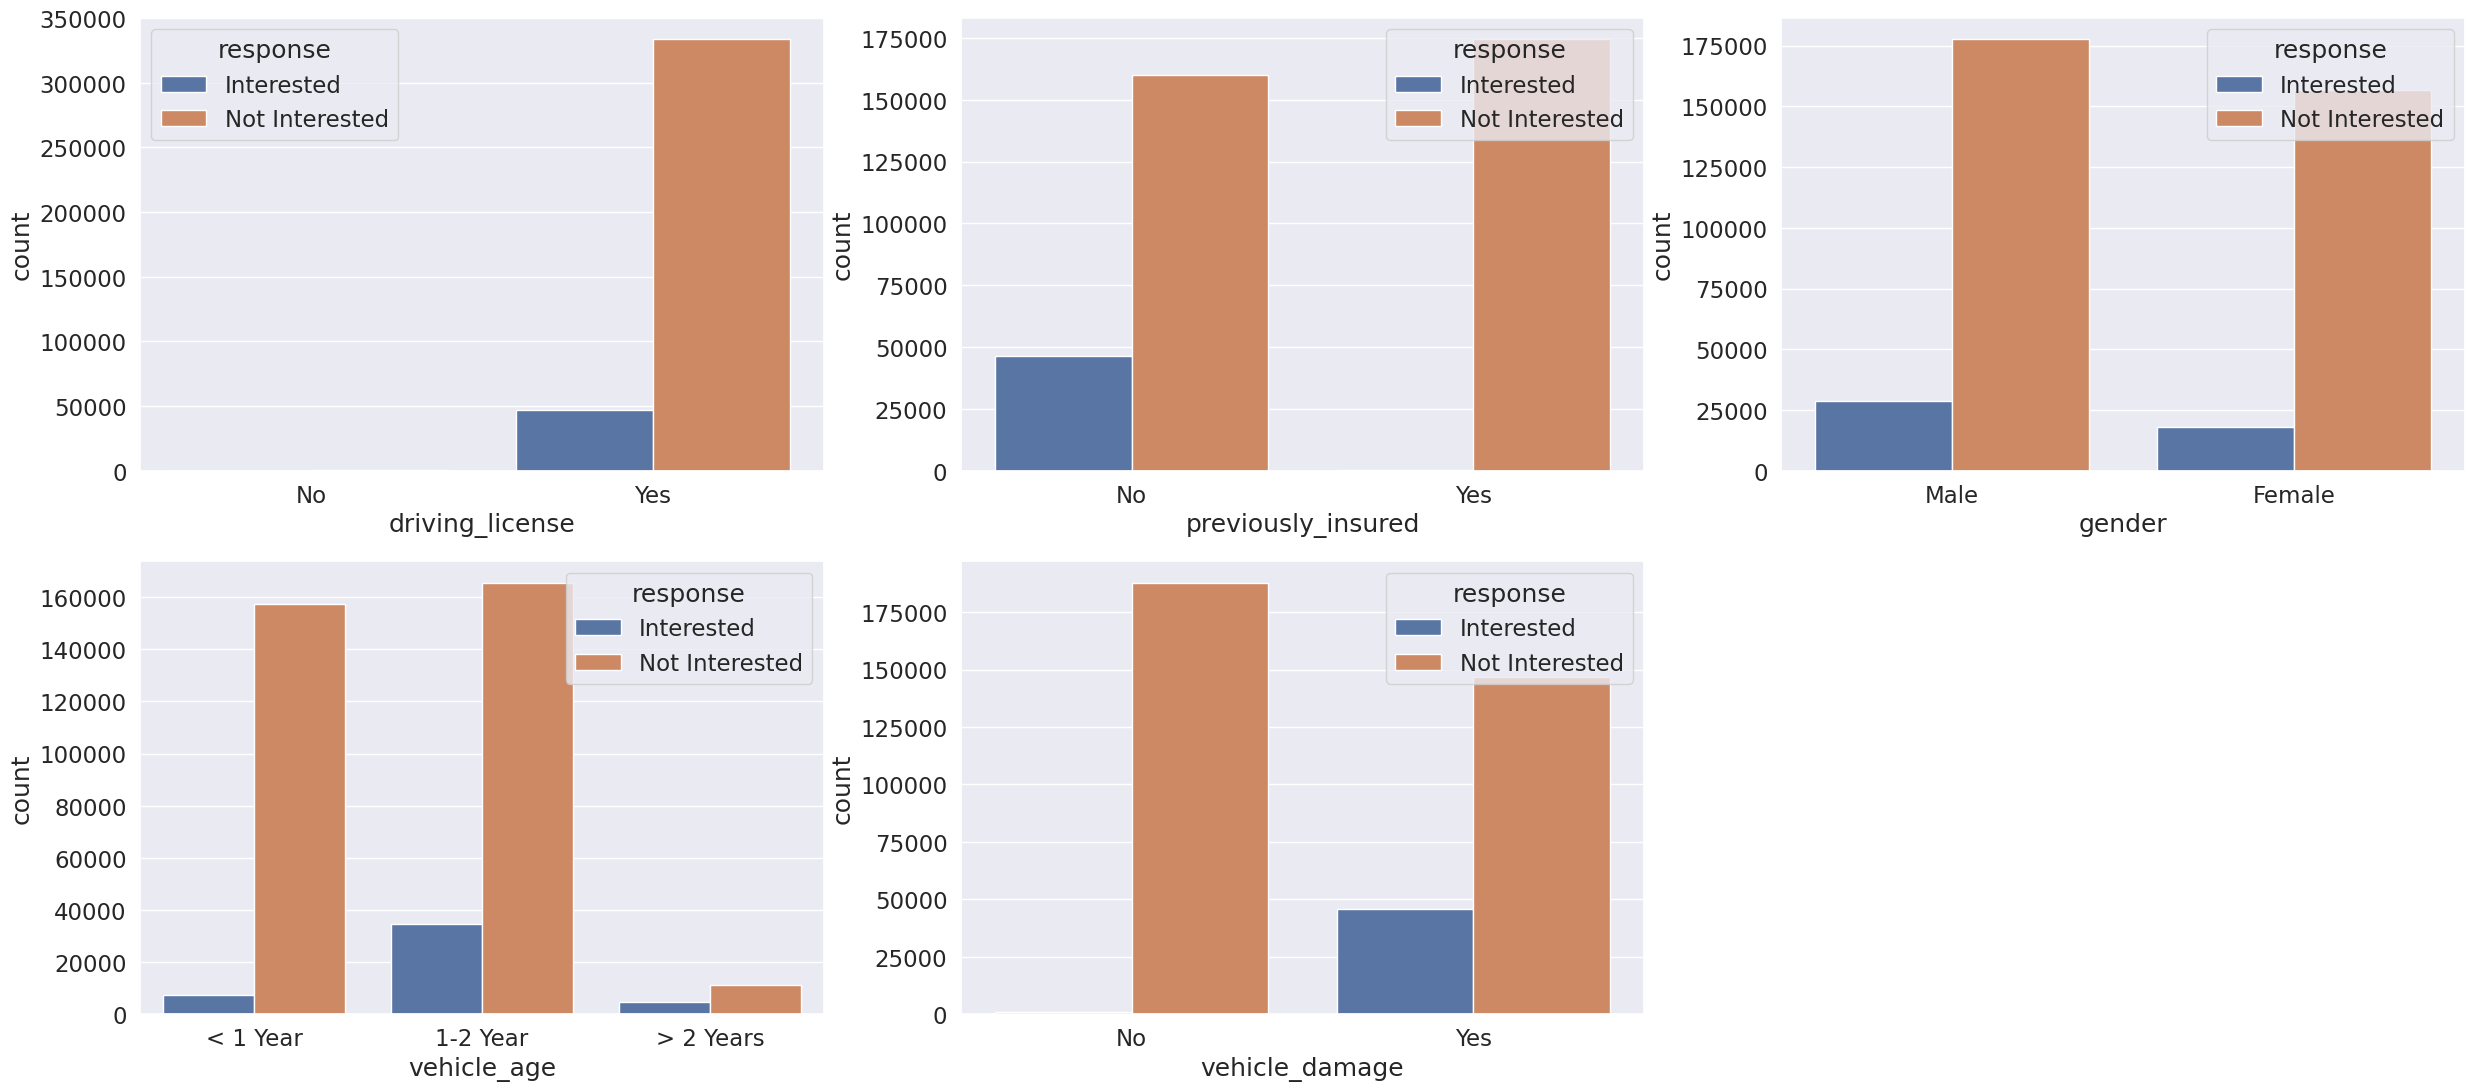

In [12]:
plt.subplot(3,3,1)
sns.countplot(x='driving_license', hue=('response'), data=df1, order=['No','Yes'] );

plt.subplot(3,3,2)
sns.countplot(x='previously_insured', hue=('response'), data=df1, order=['No','Yes']);

plt.subplot(3,3,3)
sns.countplot(x='gender', hue=('response'), data=df1 );

plt.subplot(3,3,4)
sns.countplot(x='vehicle_age', hue=('response'), data=df1, order=['< 1 Year','1-2 Year','> 2 Years' ] );

plt.subplot(3,3,5)
sns.countplot(x='vehicle_damage', hue=('response'), data=df1, order=['No','Yes']);

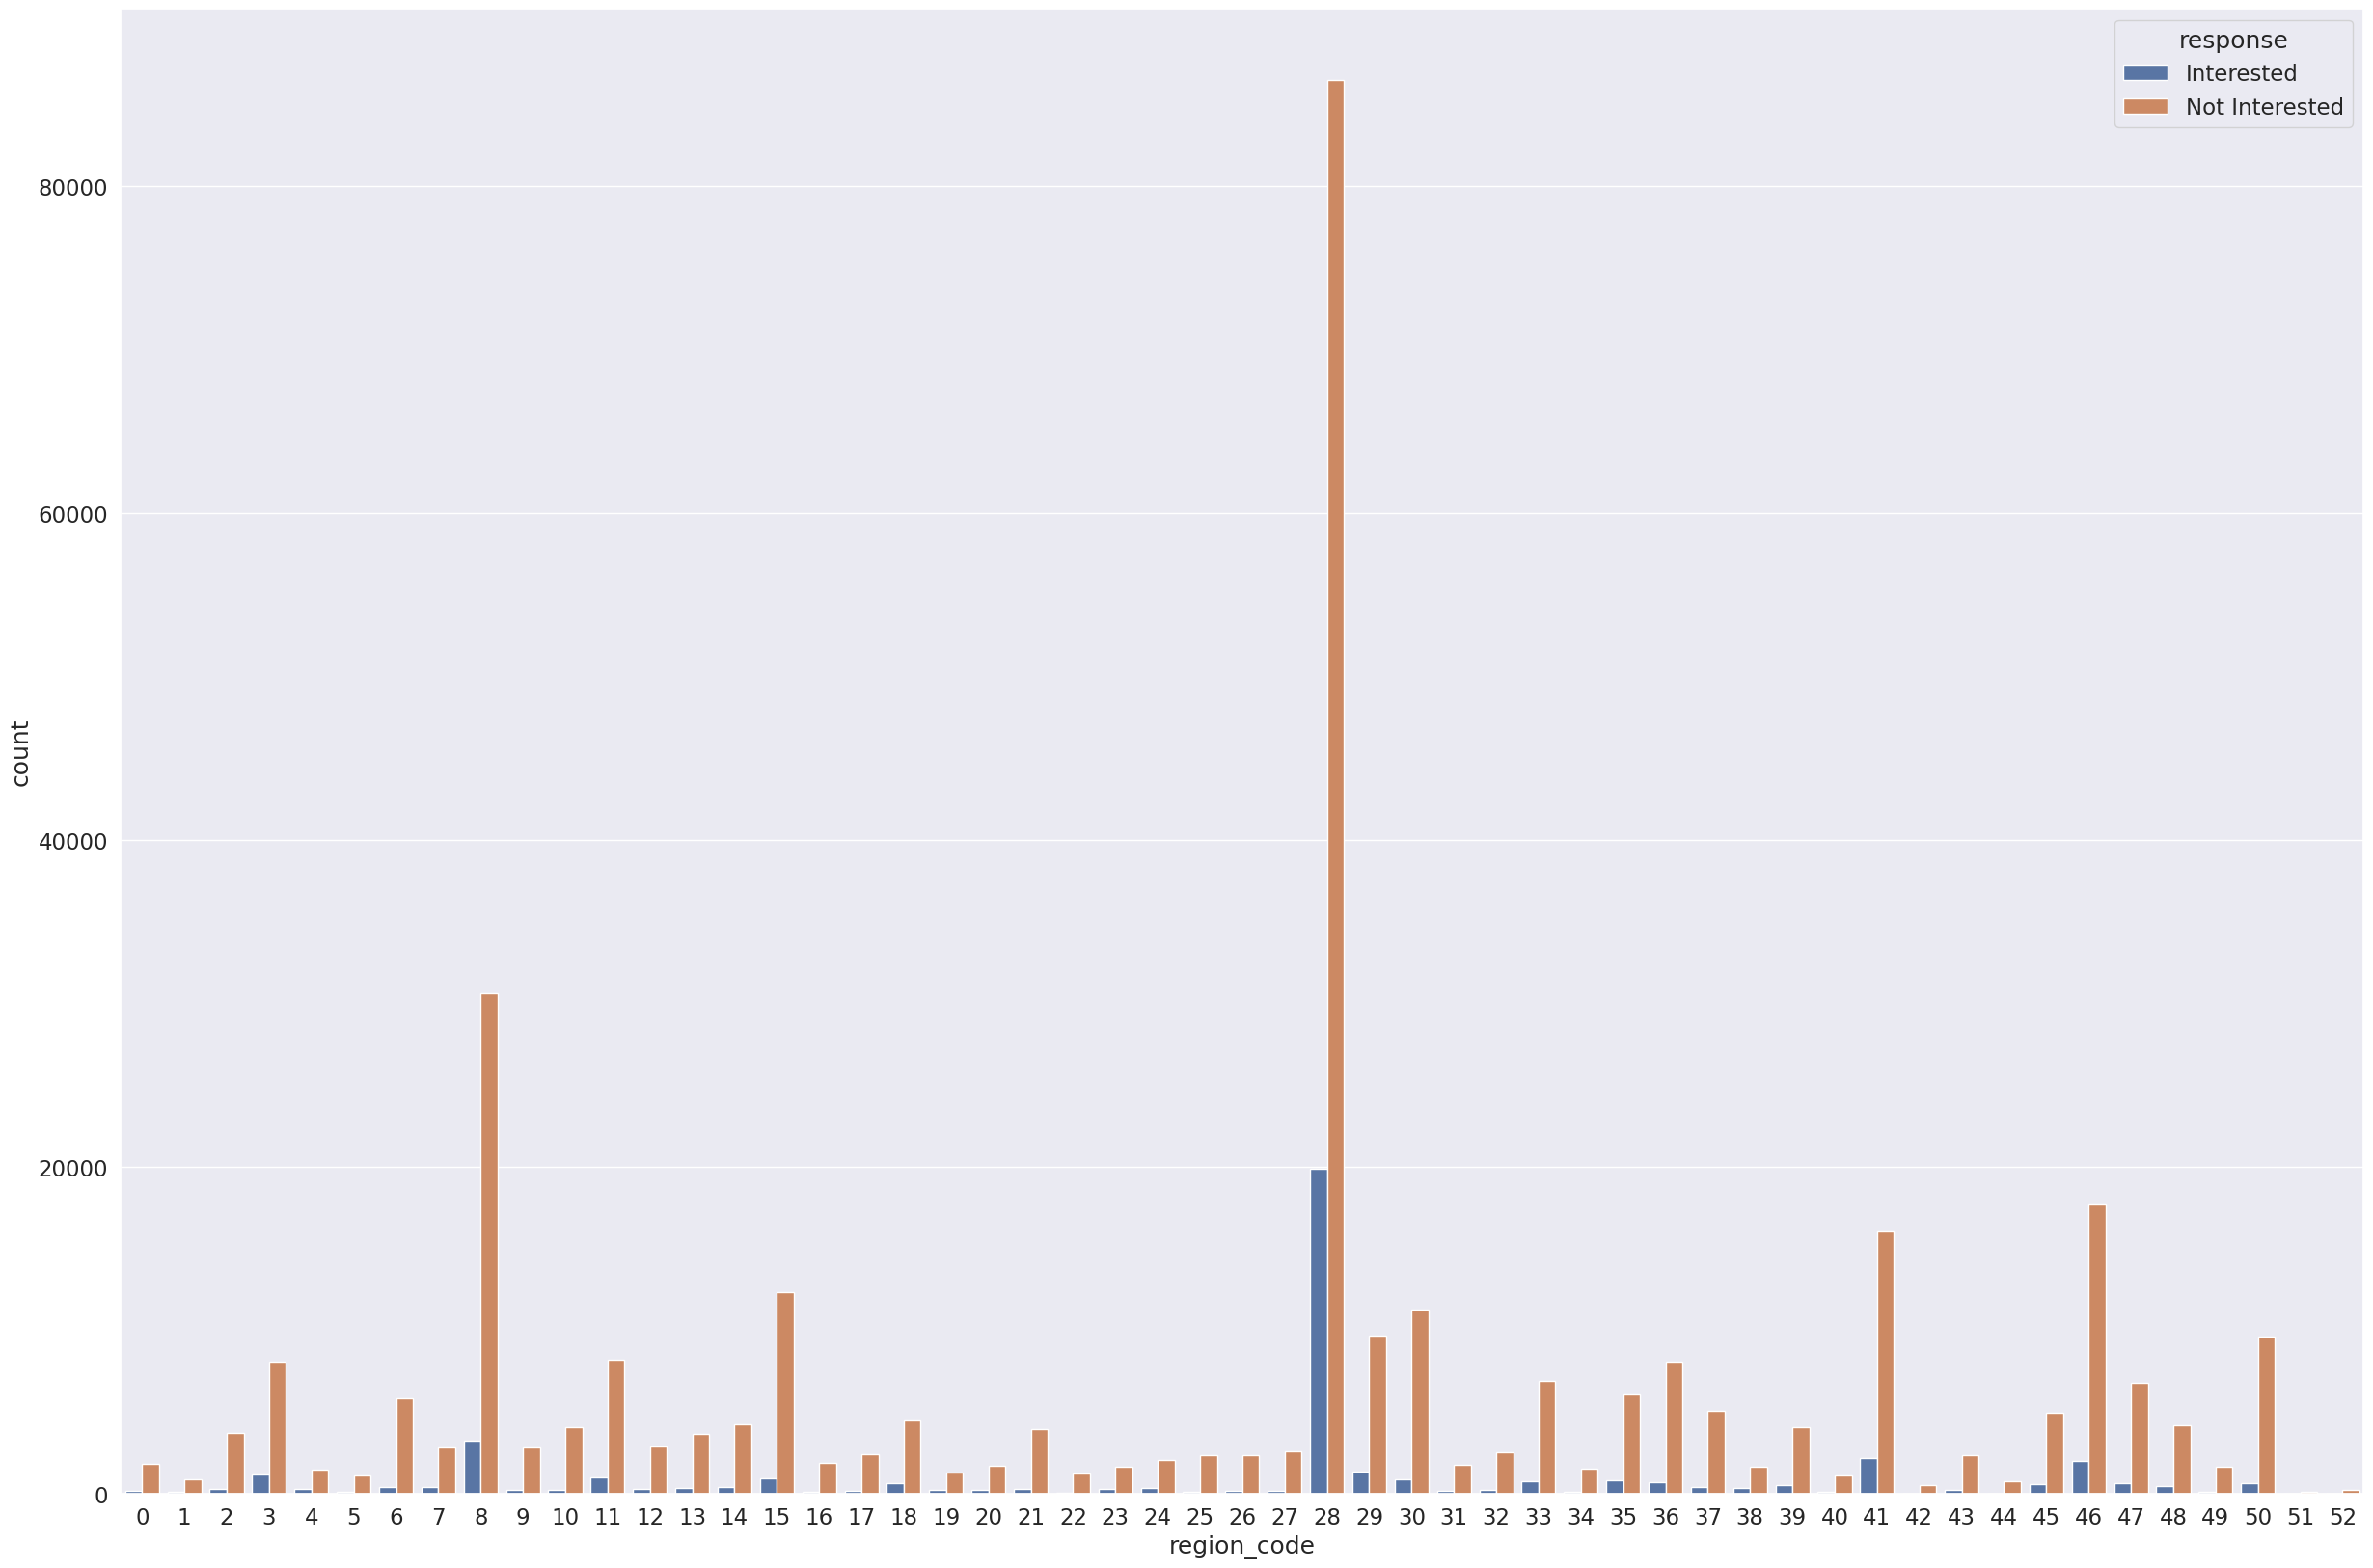

In [13]:
#Region code
order = sorted(df1['region_code'].unique().astype(int) )
order = [ str(i) for i in order]
sns.countplot(x='region_code', hue=('response'), data=df1, order=order);

# Feature engineering

## Mindmap Hypothesis

In [5]:
df2 = df1.copy()

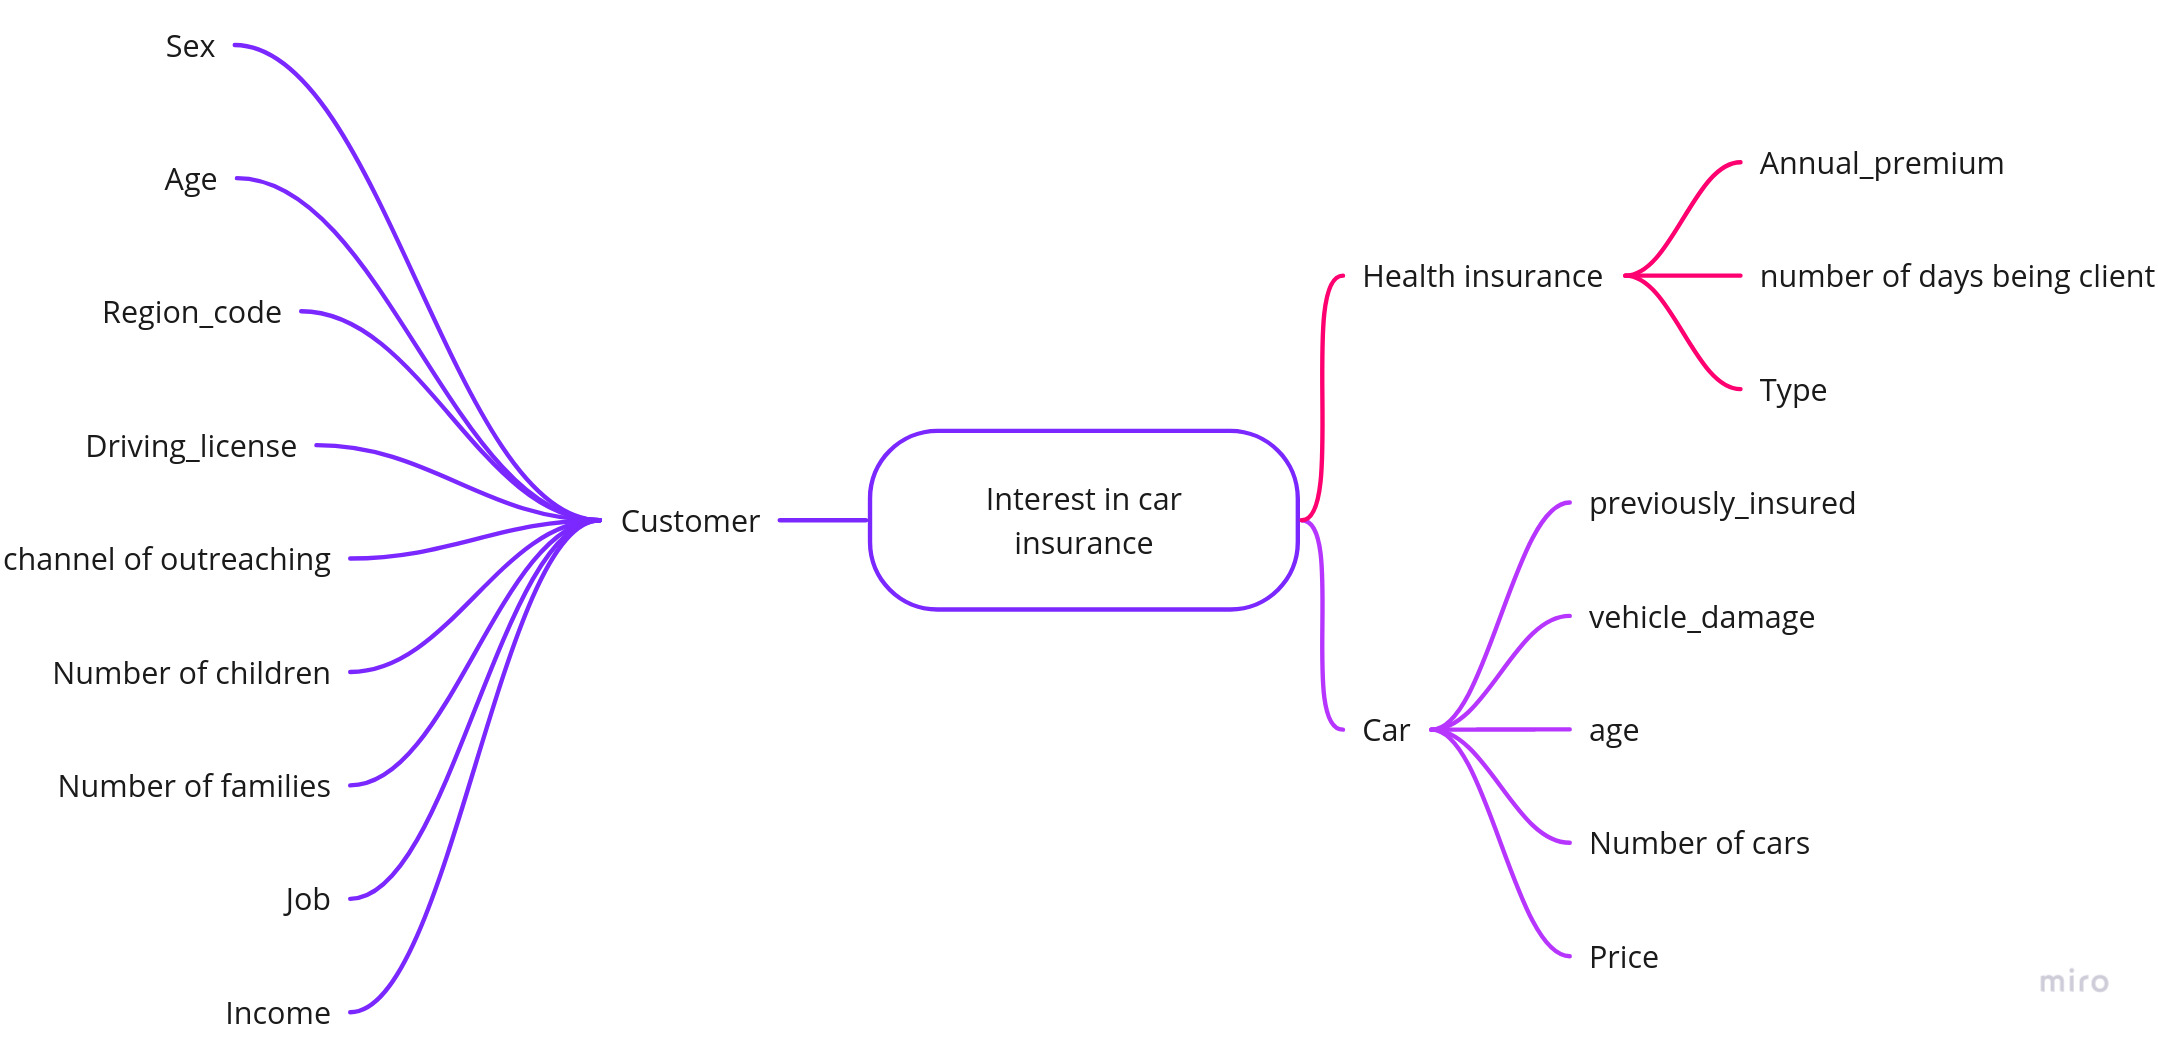

In [15]:
Image('Mind_Map.jpg')

## Customer Hypothesis

1. The proportion of men interested in getting a car insurance is 10% higher than women
2. The proportion of customers with more than 55 years old interested in getting a car insurance is 15% higher than customers between 35 and 55 years old
3. The proportion of younger customers (until 35 years old) interested in getting a car insurance is 10% higher than older ones (more than 55 years old).
4. The proportion of customers with driving license interested in getting a car insurance is 20% higher than customers without driving license.

## Health Insurance Hypothesis
5. The proportion of long-time customers (200 days or more) interested in getting a car insurance is 10% higher than newer ones
6. The proportion of customers who pays more than \\$40,000 in their health insurance and are  interested in getting a car insurance is 15\%  higher than customers who pays less than \\$20,000

## Car Hypothesis
7. The proportion of customers whose cars have less than 1 year old and are interested in getting a car insurance  is 15% higher than customers whose cars have more than 2 years old.
8. The proportion of customers whose cars suffered a damage in the past and are interested in getting a car insurance is 20% higher than customers who cars have not suffered a damage.
9. The proportion of customers who do not have a car insurance and are interested in getting a car insurance is 25% higher than customers who already have one.

## Feature Engineering

In [6]:
df2['age_categ'] = df1['age'].apply(lambda x: '< 35' if x < 35 else 'between 35 and 55' if 35 <= x <= 55 else '> 55')
df2['annual_premium_categ'] = df2['annual_premium'].apply(lambda x: '< 20,000' if x < 20000 else 'between 20,000 and 40,000' if 20000 <= x <= 40000 
                            else '> 40,000')
df2['vintage_month'] = df2['vintage'].apply(lambda x: math.trunc(x/30) if math.trunc(x/30 ) > 0 else 1 )
df2['annual_premium_and_vintage'] = df2['annual_premium'] / df2['vintage']
df2['annual_premium_and_vintage_month'] = df2['annual_premium']/df2['vintage_month']
df2['annual_premium_per_month']  = df2['annual_premium'].apply(lambda x: x/12)       


annual_premium_avg_age_dct  = {}
annual_premium_avg_age_df=df2[['annual_premium', 'age_categ']].groupby('age_categ').mean().reset_index()
for i in annual_premium_avg_age_df.values:
    annual_premium_avg_age_dct[i[0]] = i[1]   
df2['annual_premium_avg_age'] = df2['age_categ'].map(annual_premium_avg_age_dct)

annual_premium_median_age_dct  = {}
annual_premium_median_age_df=df2[['annual_premium', 'age_categ']].groupby('age_categ').median().reset_index()
for i in annual_premium_median_age_df.values:
    annual_premium_median_age_dct[i[0]] = i[1]   
df2['annual_premium_median_age'] = df2['age_categ'].map(annual_premium_median_age_dct)
                                            
annual_premium_month_avg_age_dct  = {}
annual_premium_month_avg_age_df=df2[['annual_premium_per_month', 'age_categ']].groupby('age_categ').mean().reset_index()
for i in annual_premium_month_avg_age_df.values:
    annual_premium_month_avg_age_dct[i[0]] = i[1]   
df2['annual_premium_month_avg_age'] = df2['age_categ'].map(annual_premium_month_avg_age_dct)  
                                            
annual_premium_month_median_age_dct  = {}
annual_premium_month_median_age_df=df2[['annual_premium_per_month', 'age_categ']].groupby('age_categ').median().reset_index()
for i in annual_premium_month_median_age_df.values:
    annual_premium_month_median_age_dct[i[0]] = i[1]   
df2['annual_premium_month_median_age'] = df2['age_categ'].map(annual_premium_month_median_age_dct)                                            
                                            
                                           
vintage_avg_age_dct  = {}
vintage_avg_age_df=df2[['vintage', 'age_categ']].groupby('age_categ').mean().reset_index()
for i in vintage_avg_age_df.values:
    vintage_avg_age_dct[i[0]] = i[1]
df2['vintage_avg_age'] = df2['age_categ'].map(vintage_avg_age_dct)
                                            
vintage_month_avg_age_dct  = {}
vintage_month_avg_age_df=df2[['vintage_month', 'age_categ']].groupby('age_categ').mean().reset_index()
for i in vintage_month_avg_age_df.values:
    vintage_month_avg_age_dct[i[0]] = i[1]
df2['vintage_month_avg_age'] = df2['age_categ'].map(vintage_month_avg_age_dct)
                                                                                 
annual_premium_avg_sales_channel_dct  = {}
annual_premium_avg_sales_channel_df=df2[['annual_premium', 'policy_sales_channel']].groupby('policy_sales_channel').mean().reset_index()
for i in annual_premium_avg_sales_channel_df.values:
    annual_premium_avg_sales_channel_dct[i[0]] = i[1]   
df2['annual_premium_avg_sales_channel'] = df2['policy_sales_channel'].map(annual_premium_avg_sales_channel_dct)         
                                            
annual_premium_month_avg_sales_channel_dct  = {}
annual_premium_month_avg_sales_channel_df=df2[['annual_premium_per_month', 'policy_sales_channel']].groupby('policy_sales_channel').mean().reset_index()
for i in annual_premium_month_avg_sales_channel_df.values:
    annual_premium_month_avg_sales_channel_dct[i[0]] = i[1]   
df2['annual_premium_month_avg_age'] = df2['policy_sales_channel'].map(annual_premium_month_avg_sales_channel_dct)  
                                            
vintage_month_avg_sales_channel_dct  = {}
vintage_month_avg_sales_channel_df=df2[['vintage_month', 'policy_sales_channel']].groupby('policy_sales_channel').mean().reset_index()
for i in vintage_month_avg_sales_channel_df.values:
    vintage_month_avg_sales_channel_dct[i[0]] = i[1]
df2['vintage_month_avg_sales_channel'] = df2['policy_sales_channel'].map(vintage_month_avg_sales_channel_dct)                                            

# Exploratory Data Analysis

In [7]:
df3 = df2.copy()

## Univariate Analysis

### Response Variable

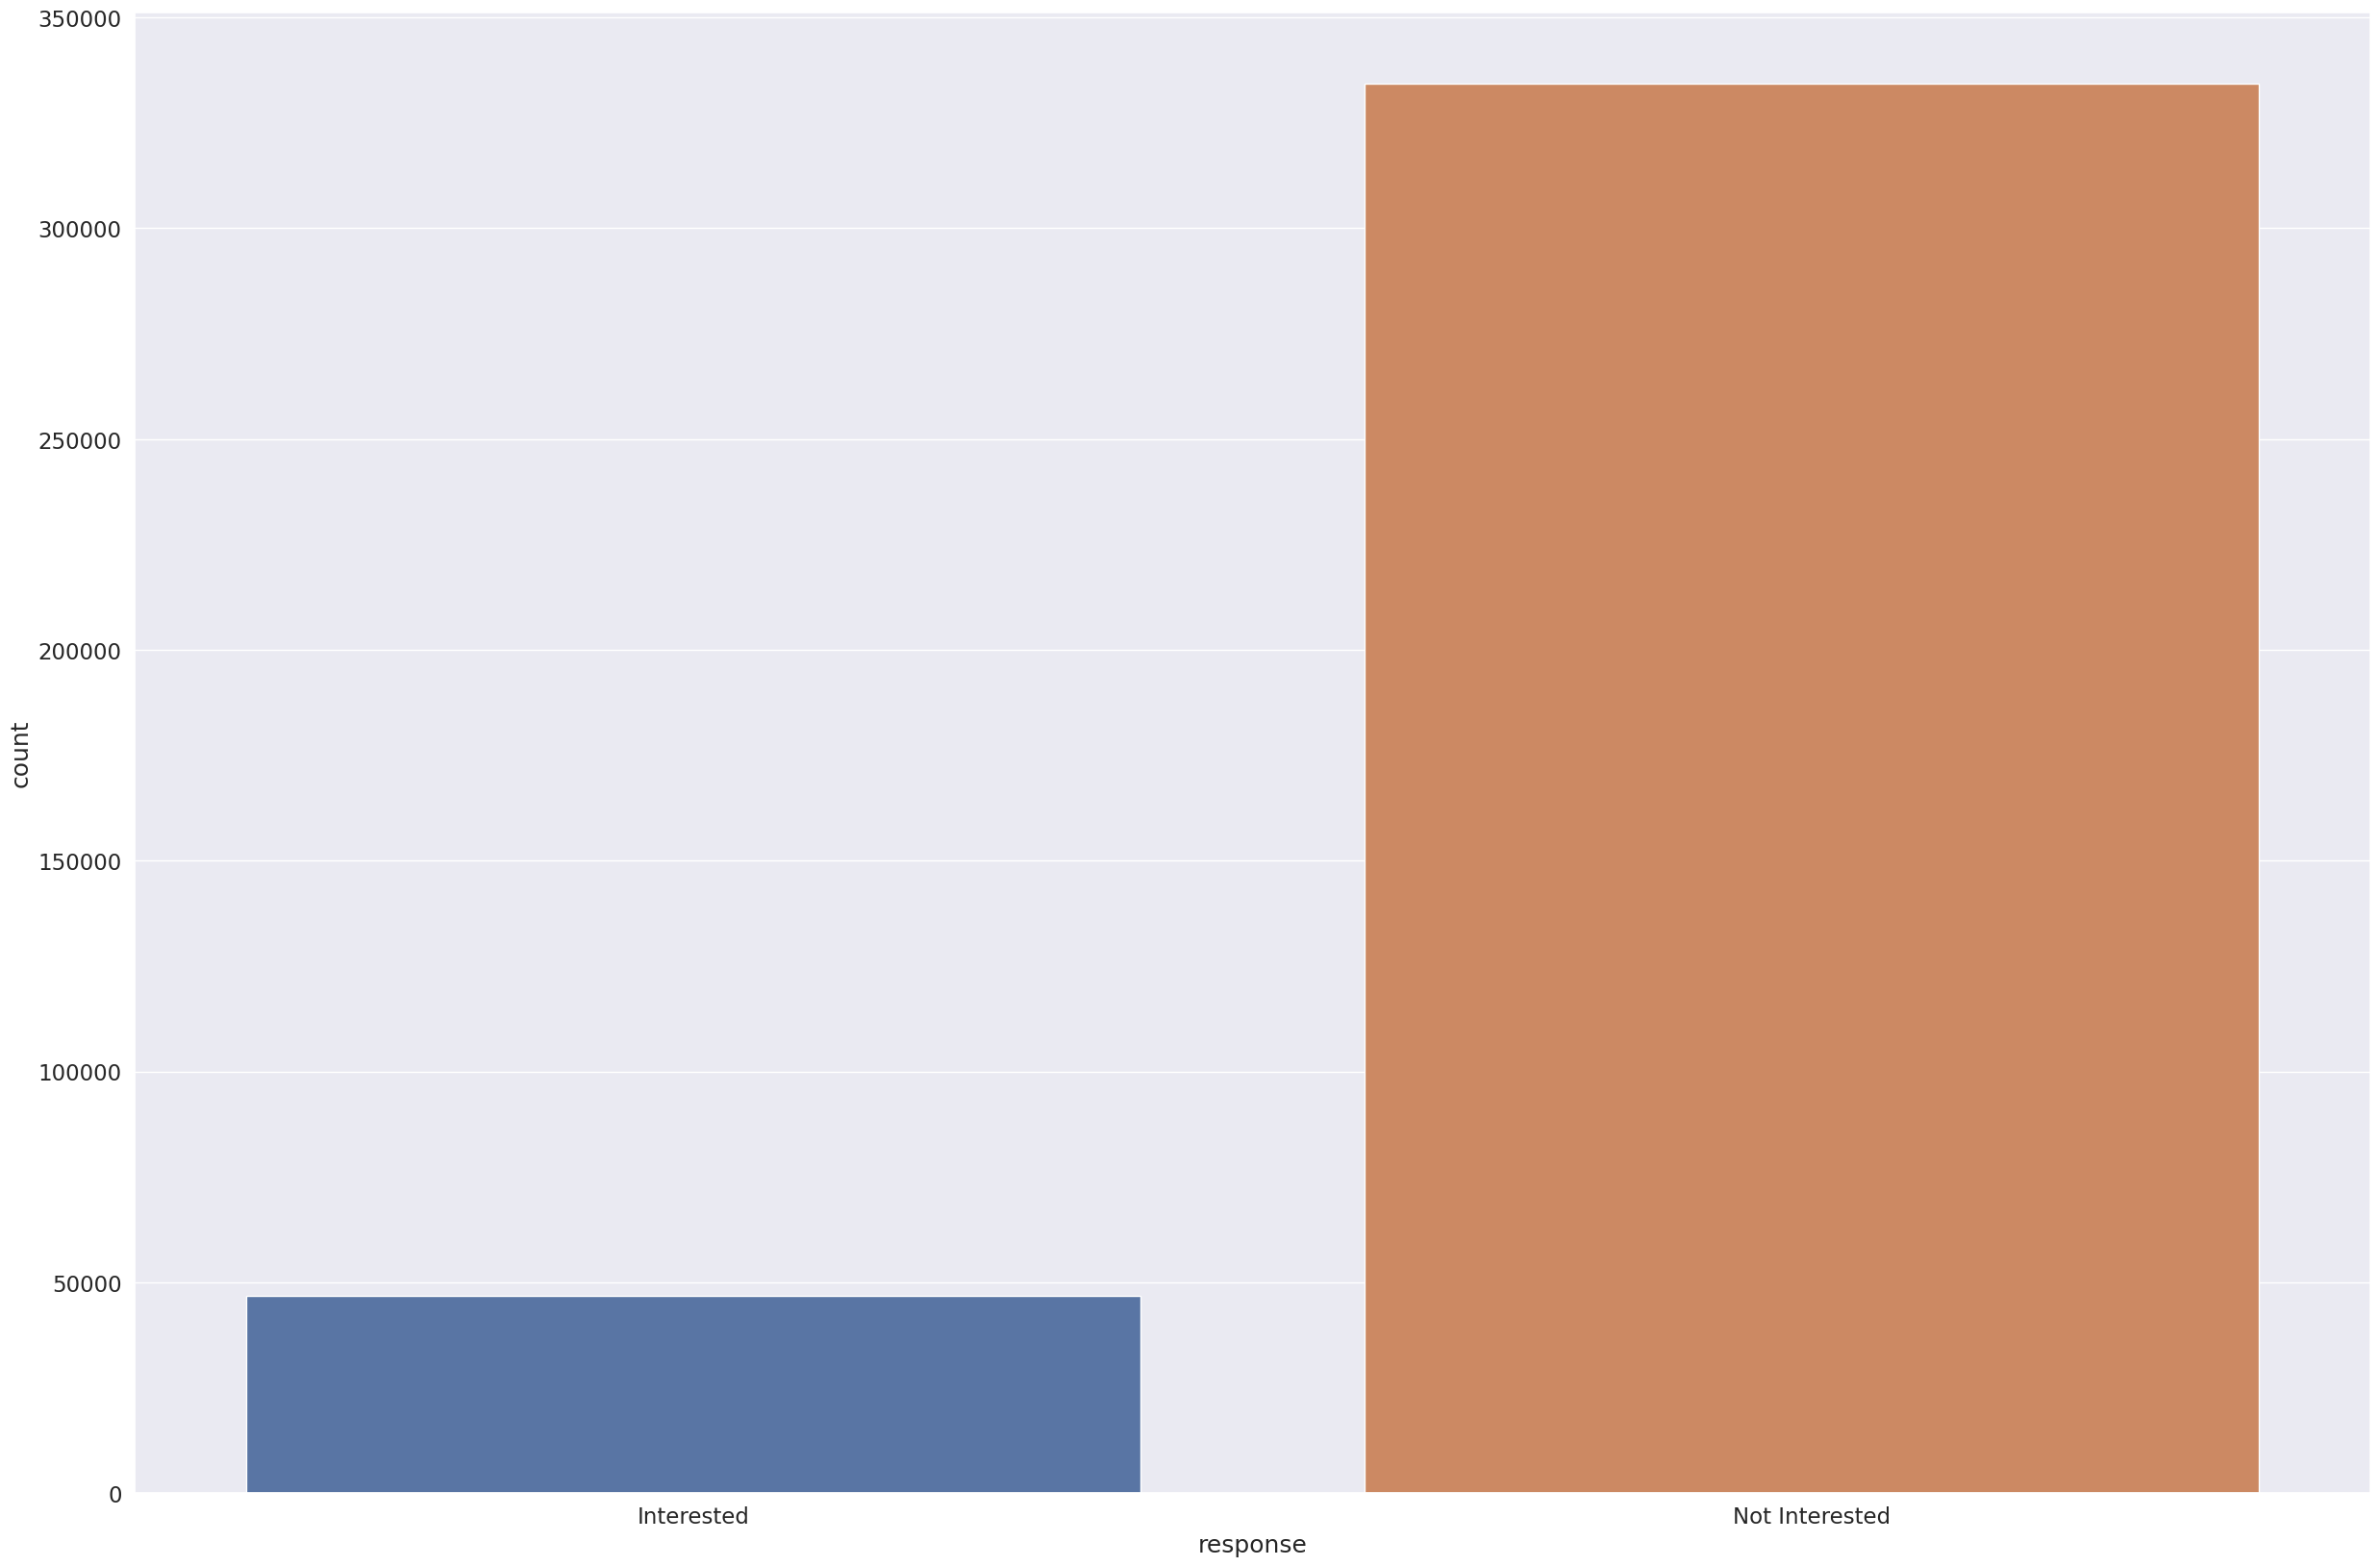

In [18]:
sns.countplot(x=df3['response'] );

### Categorical Variables


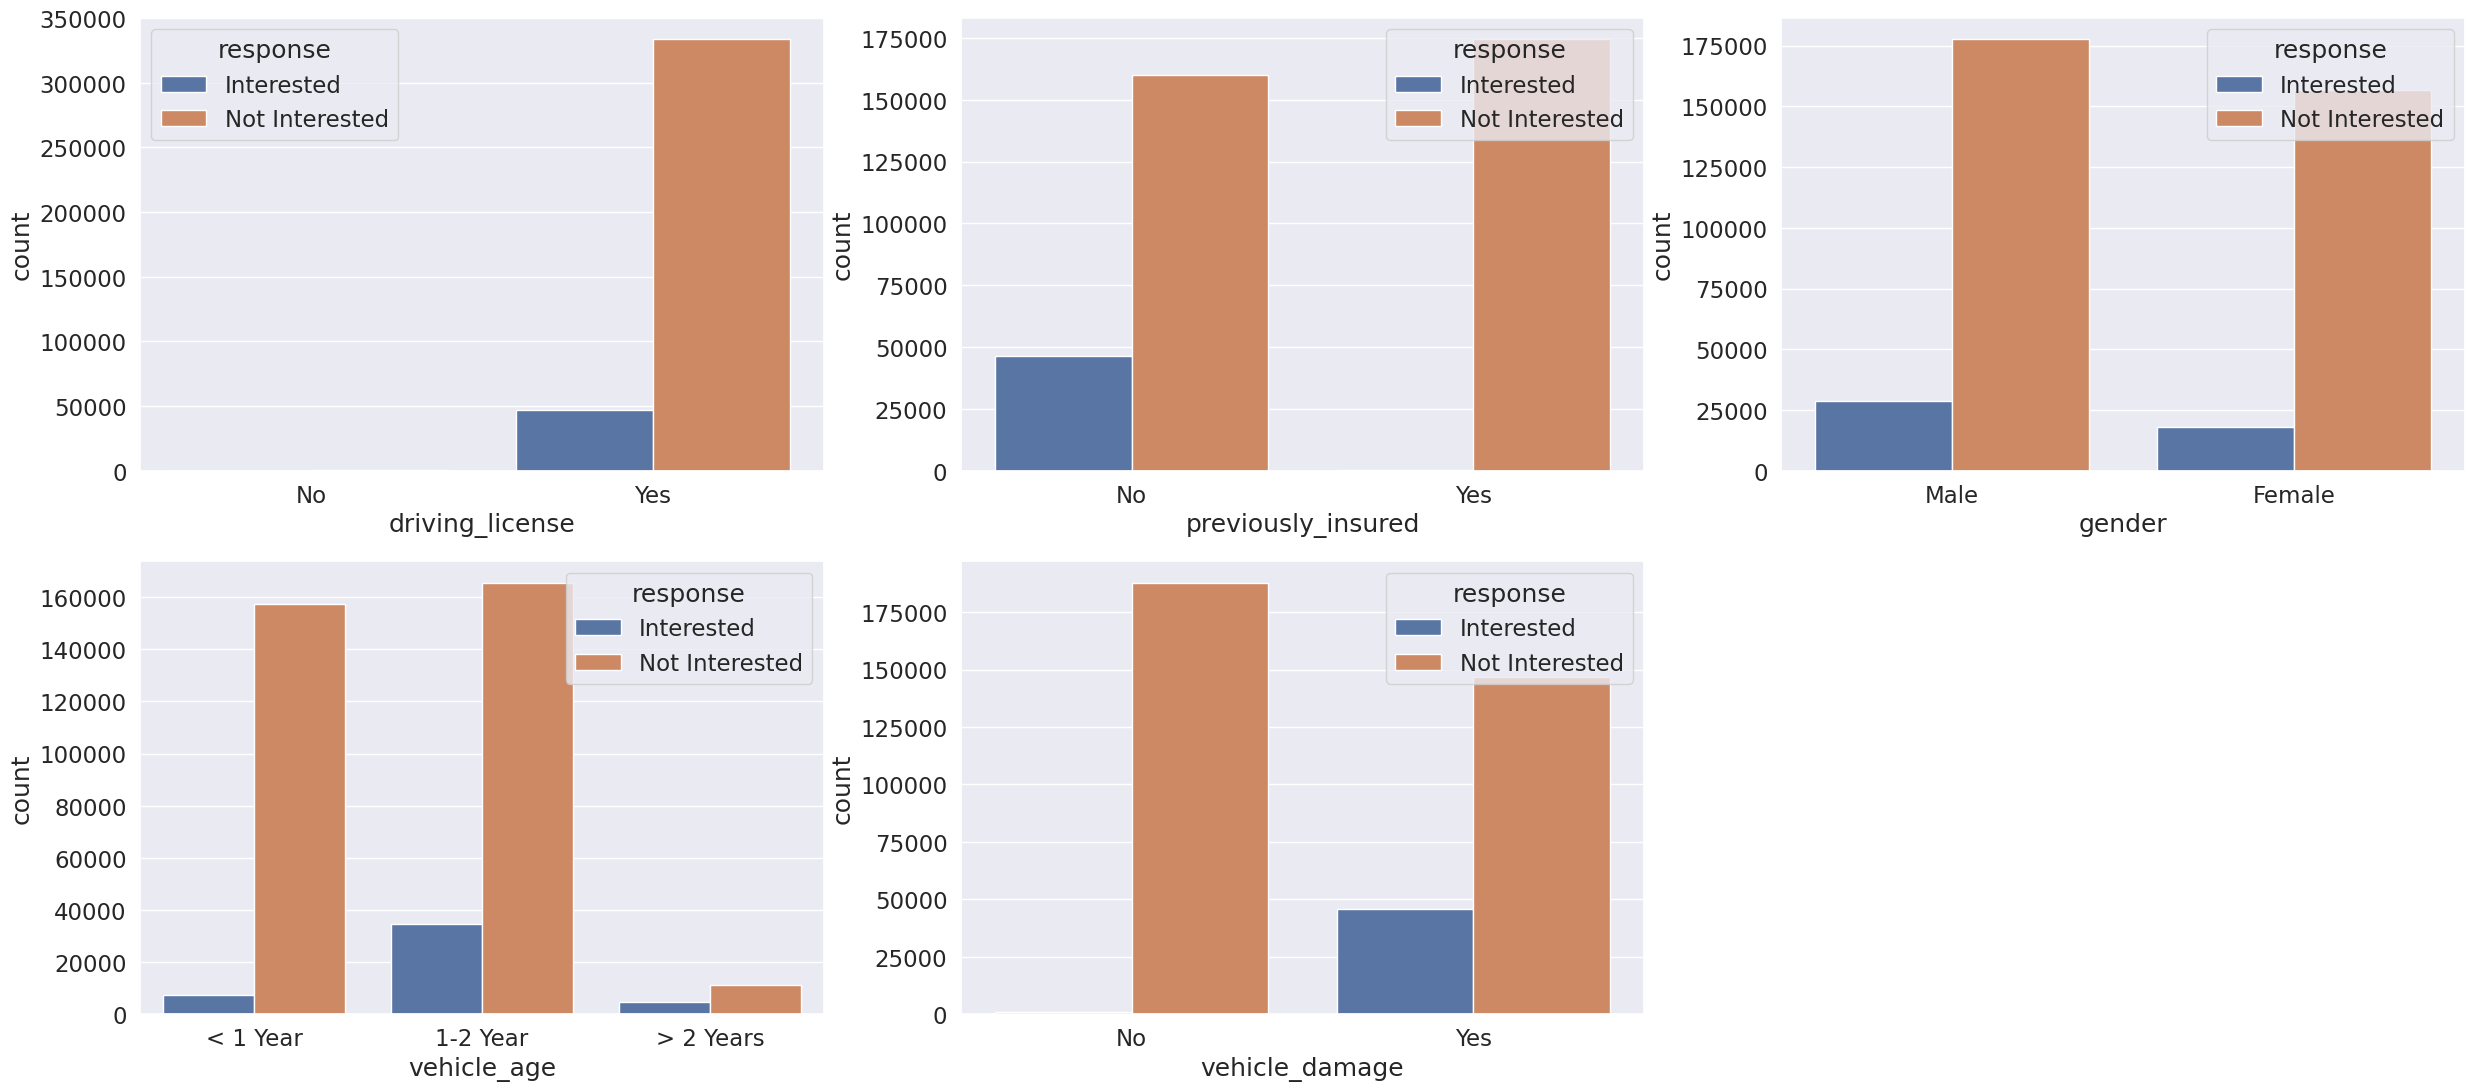

In [19]:
plt.subplot(3,3,1)
sns.countplot(x='driving_license', hue=('response'), data=df3, order=['No','Yes'] );

plt.subplot(3,3,2)
sns.countplot(x='previously_insured', hue=('response'), data=df3, order=['No','Yes']);

plt.subplot(3,3,3)
sns.countplot(x='gender', hue=('response'), data=df3 );

plt.subplot(3,3,4)
sns.countplot(x='vehicle_age', hue=('response'), data=df3, order=['< 1 Year','1-2 Year','> 2 Years' ] );

plt.subplot(3,3,5)
sns.countplot(x='vehicle_damage', hue=('response'), data=df3, order=['No','Yes']);

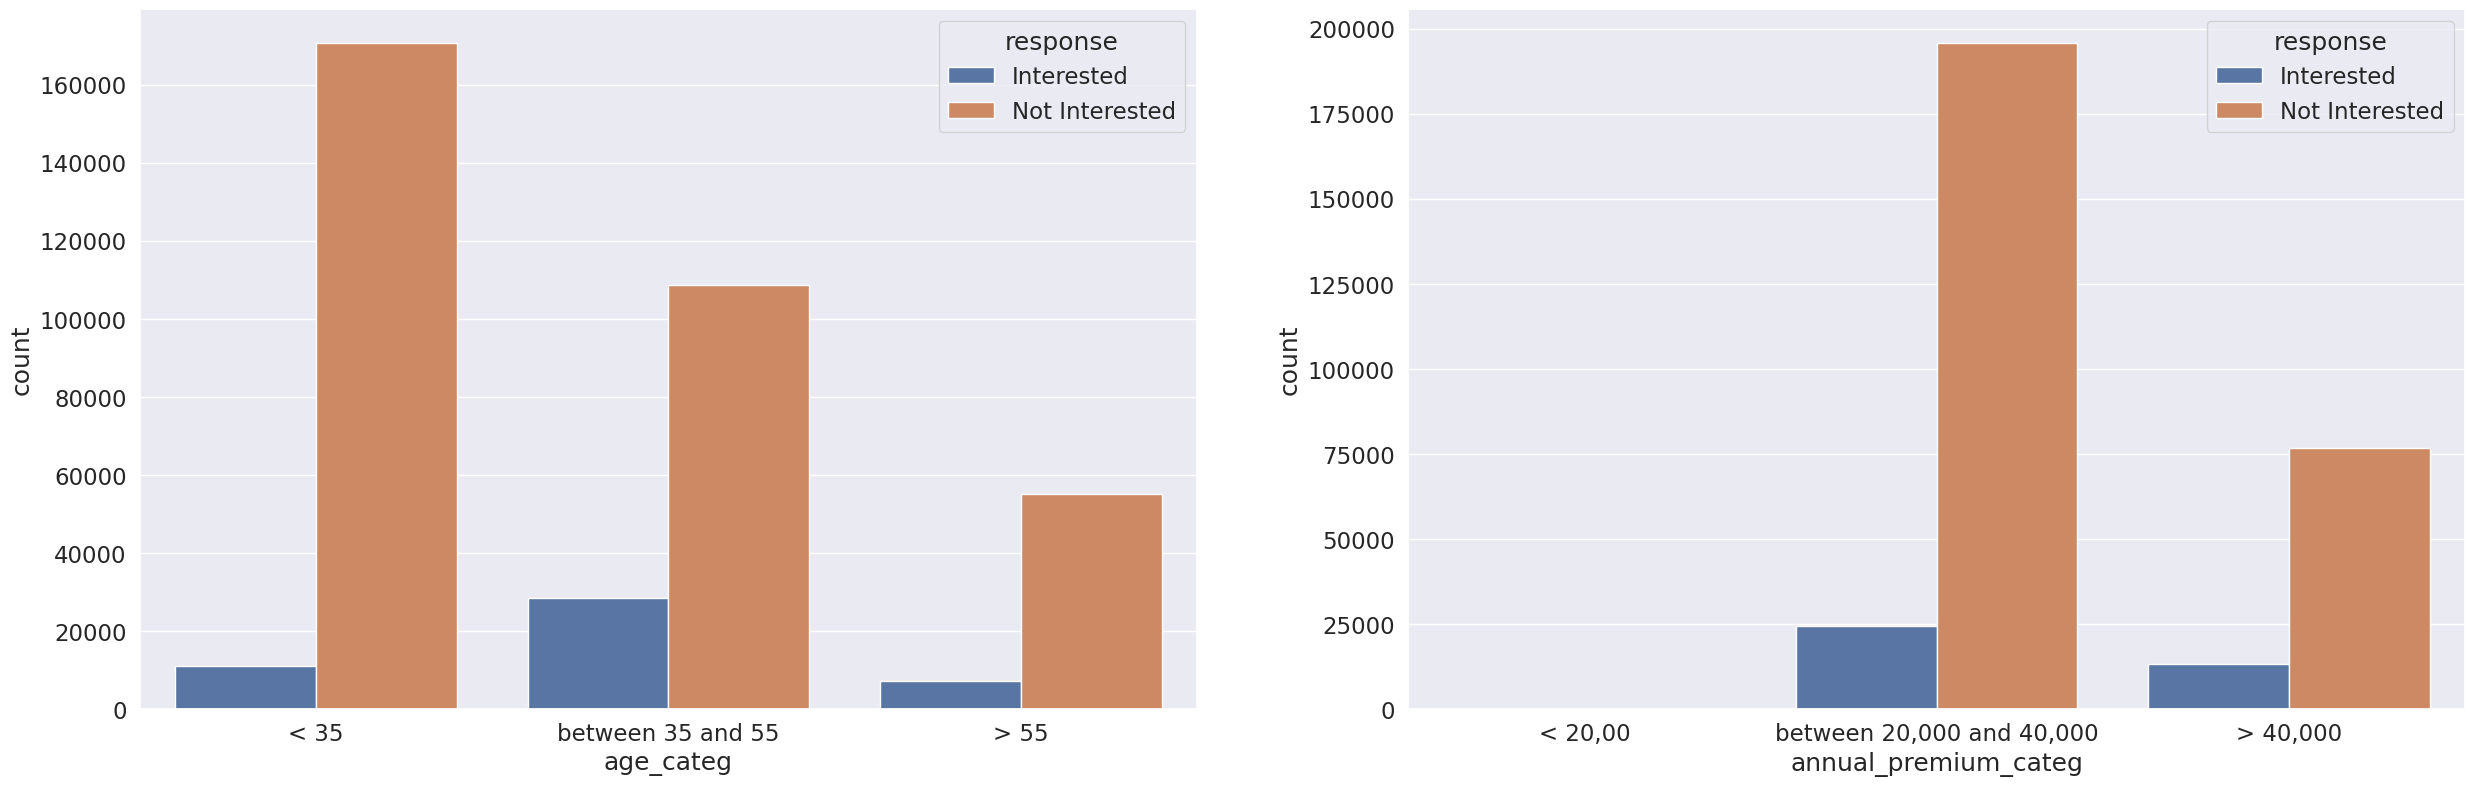

In [20]:
plt.subplot(2,2,1)
sns.countplot(x='age_categ', hue=('response'), data=df3, order=['< 35','between 35 and 55',  '> 55'] );

plt.subplot(2,2,2)
sns.countplot(x='annual_premium_categ', hue=('response'), data=df3, order=['< 20,00', 'between 20,000 and 40,000', '> 40,000'] );

## Bivariate Analysis

### H1. The proportion of men interested in getting a car insurance is 10% higher than women

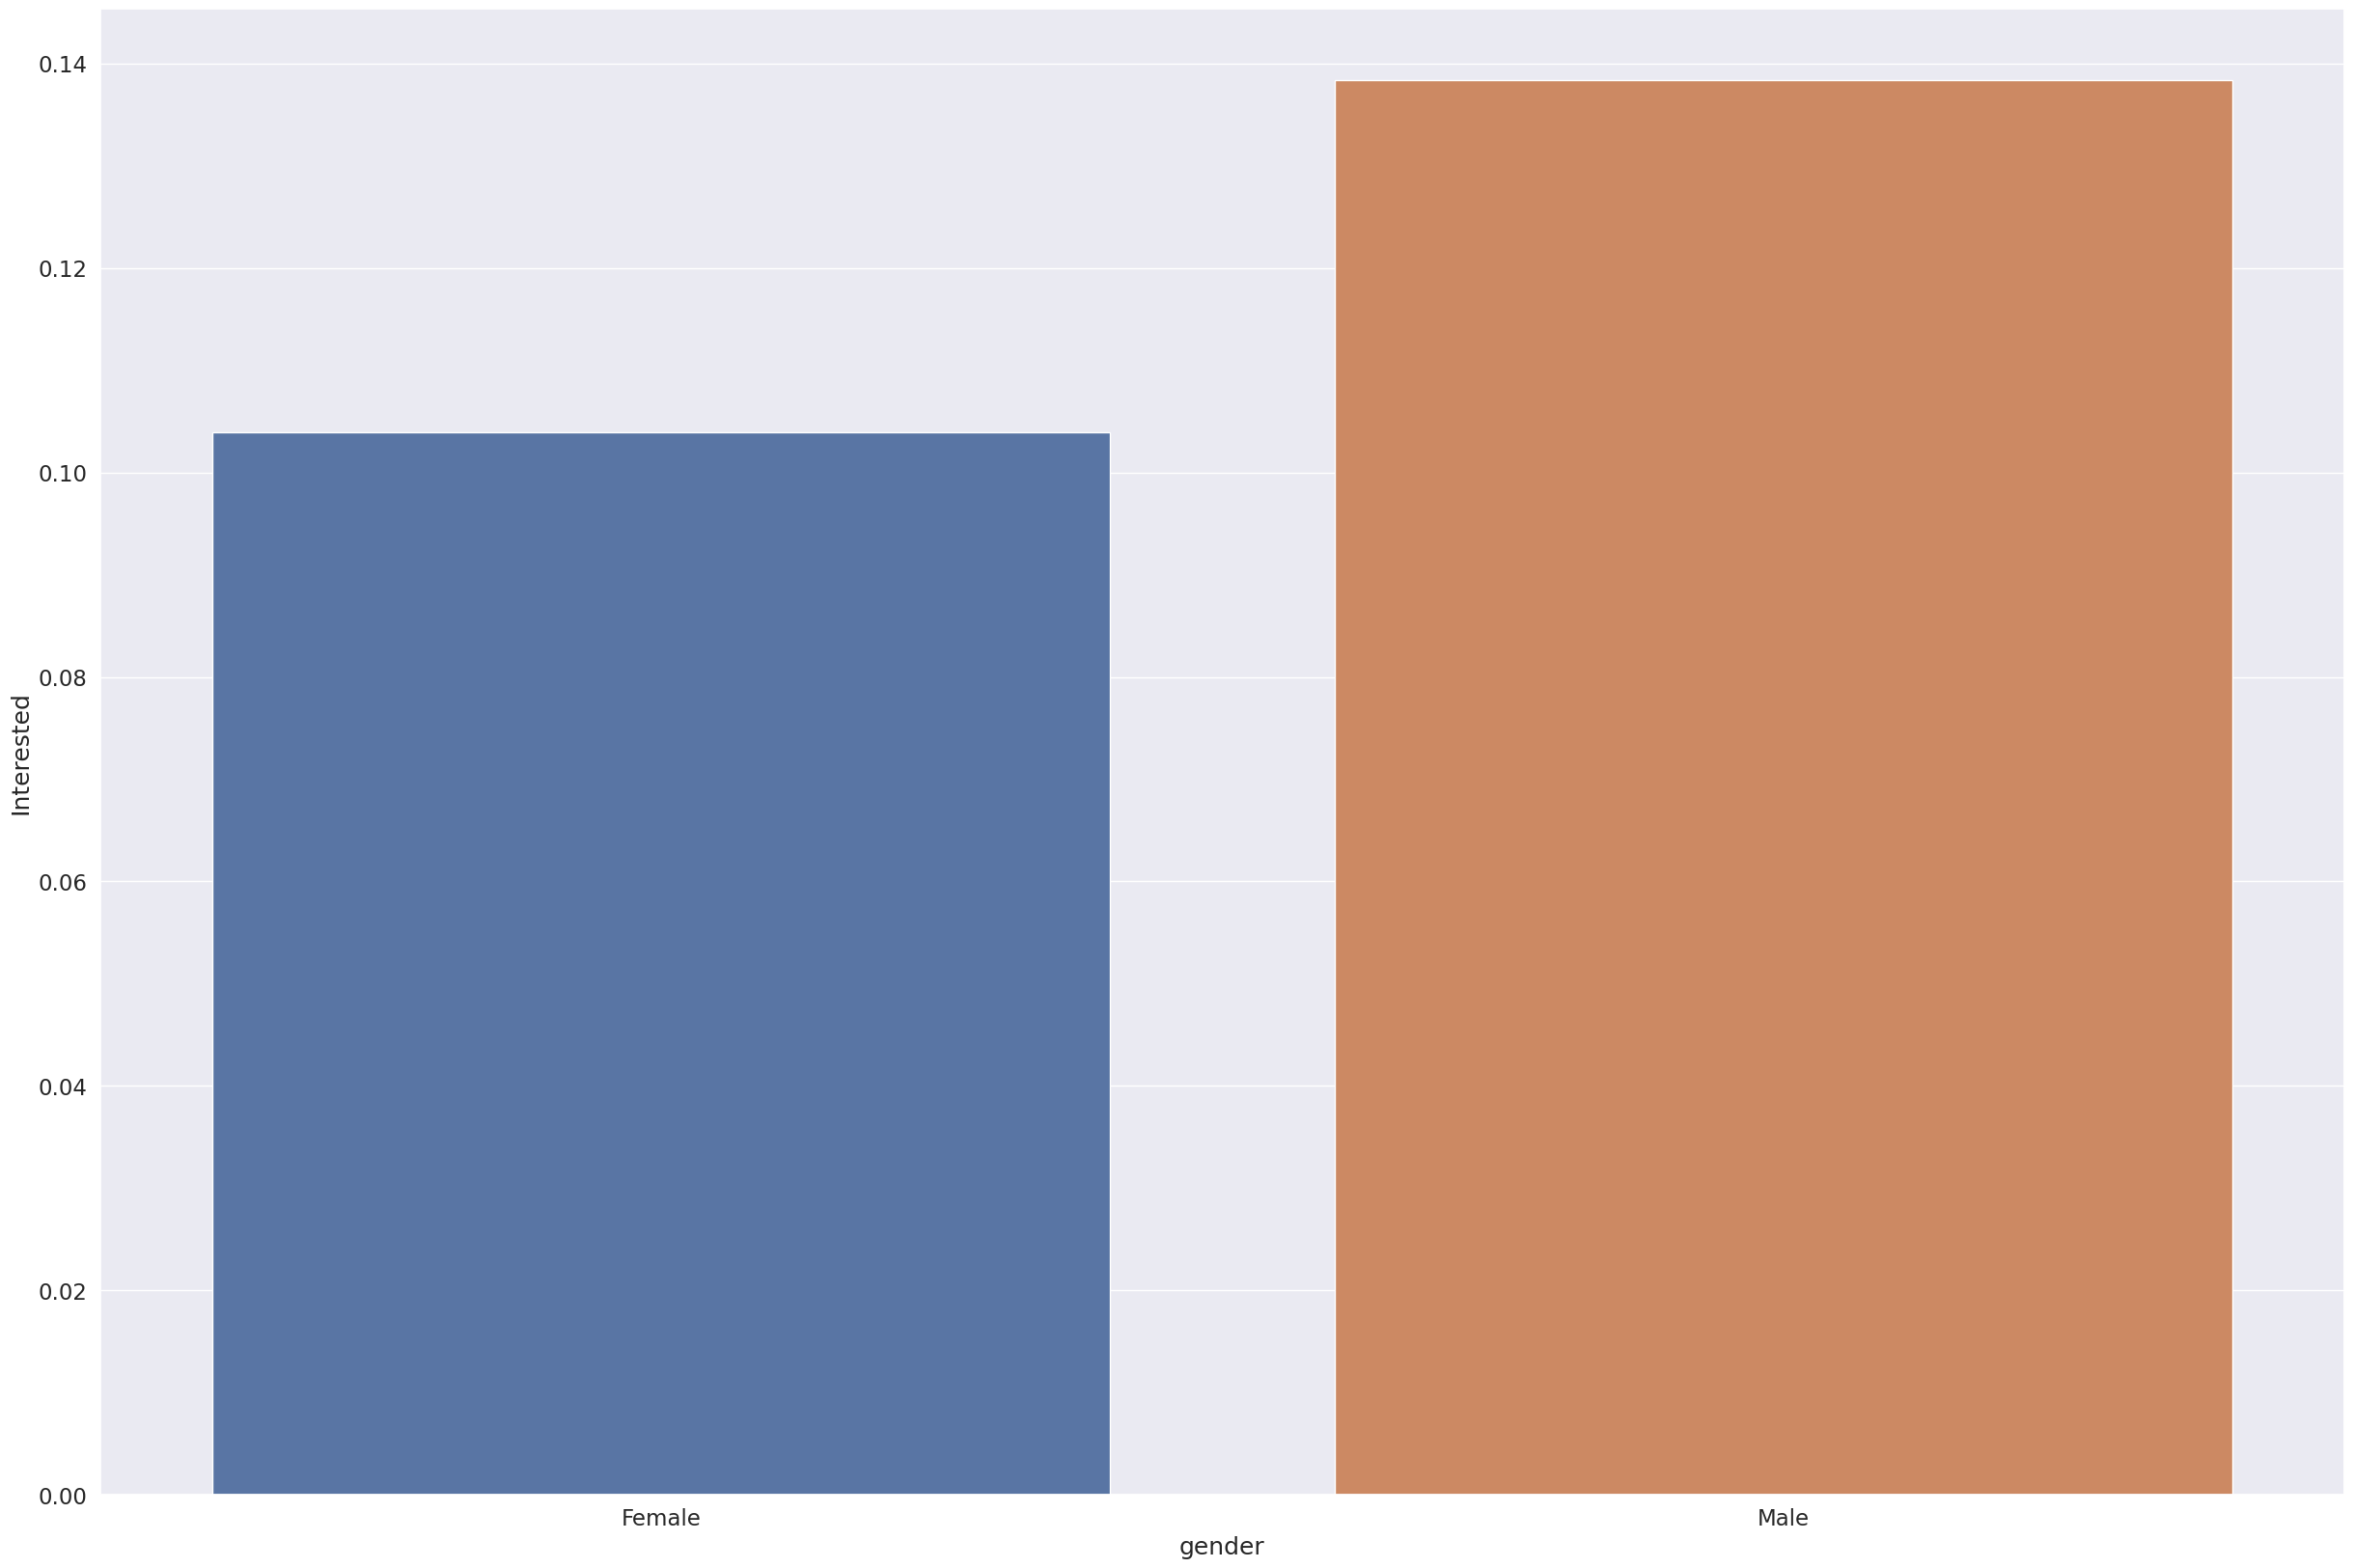

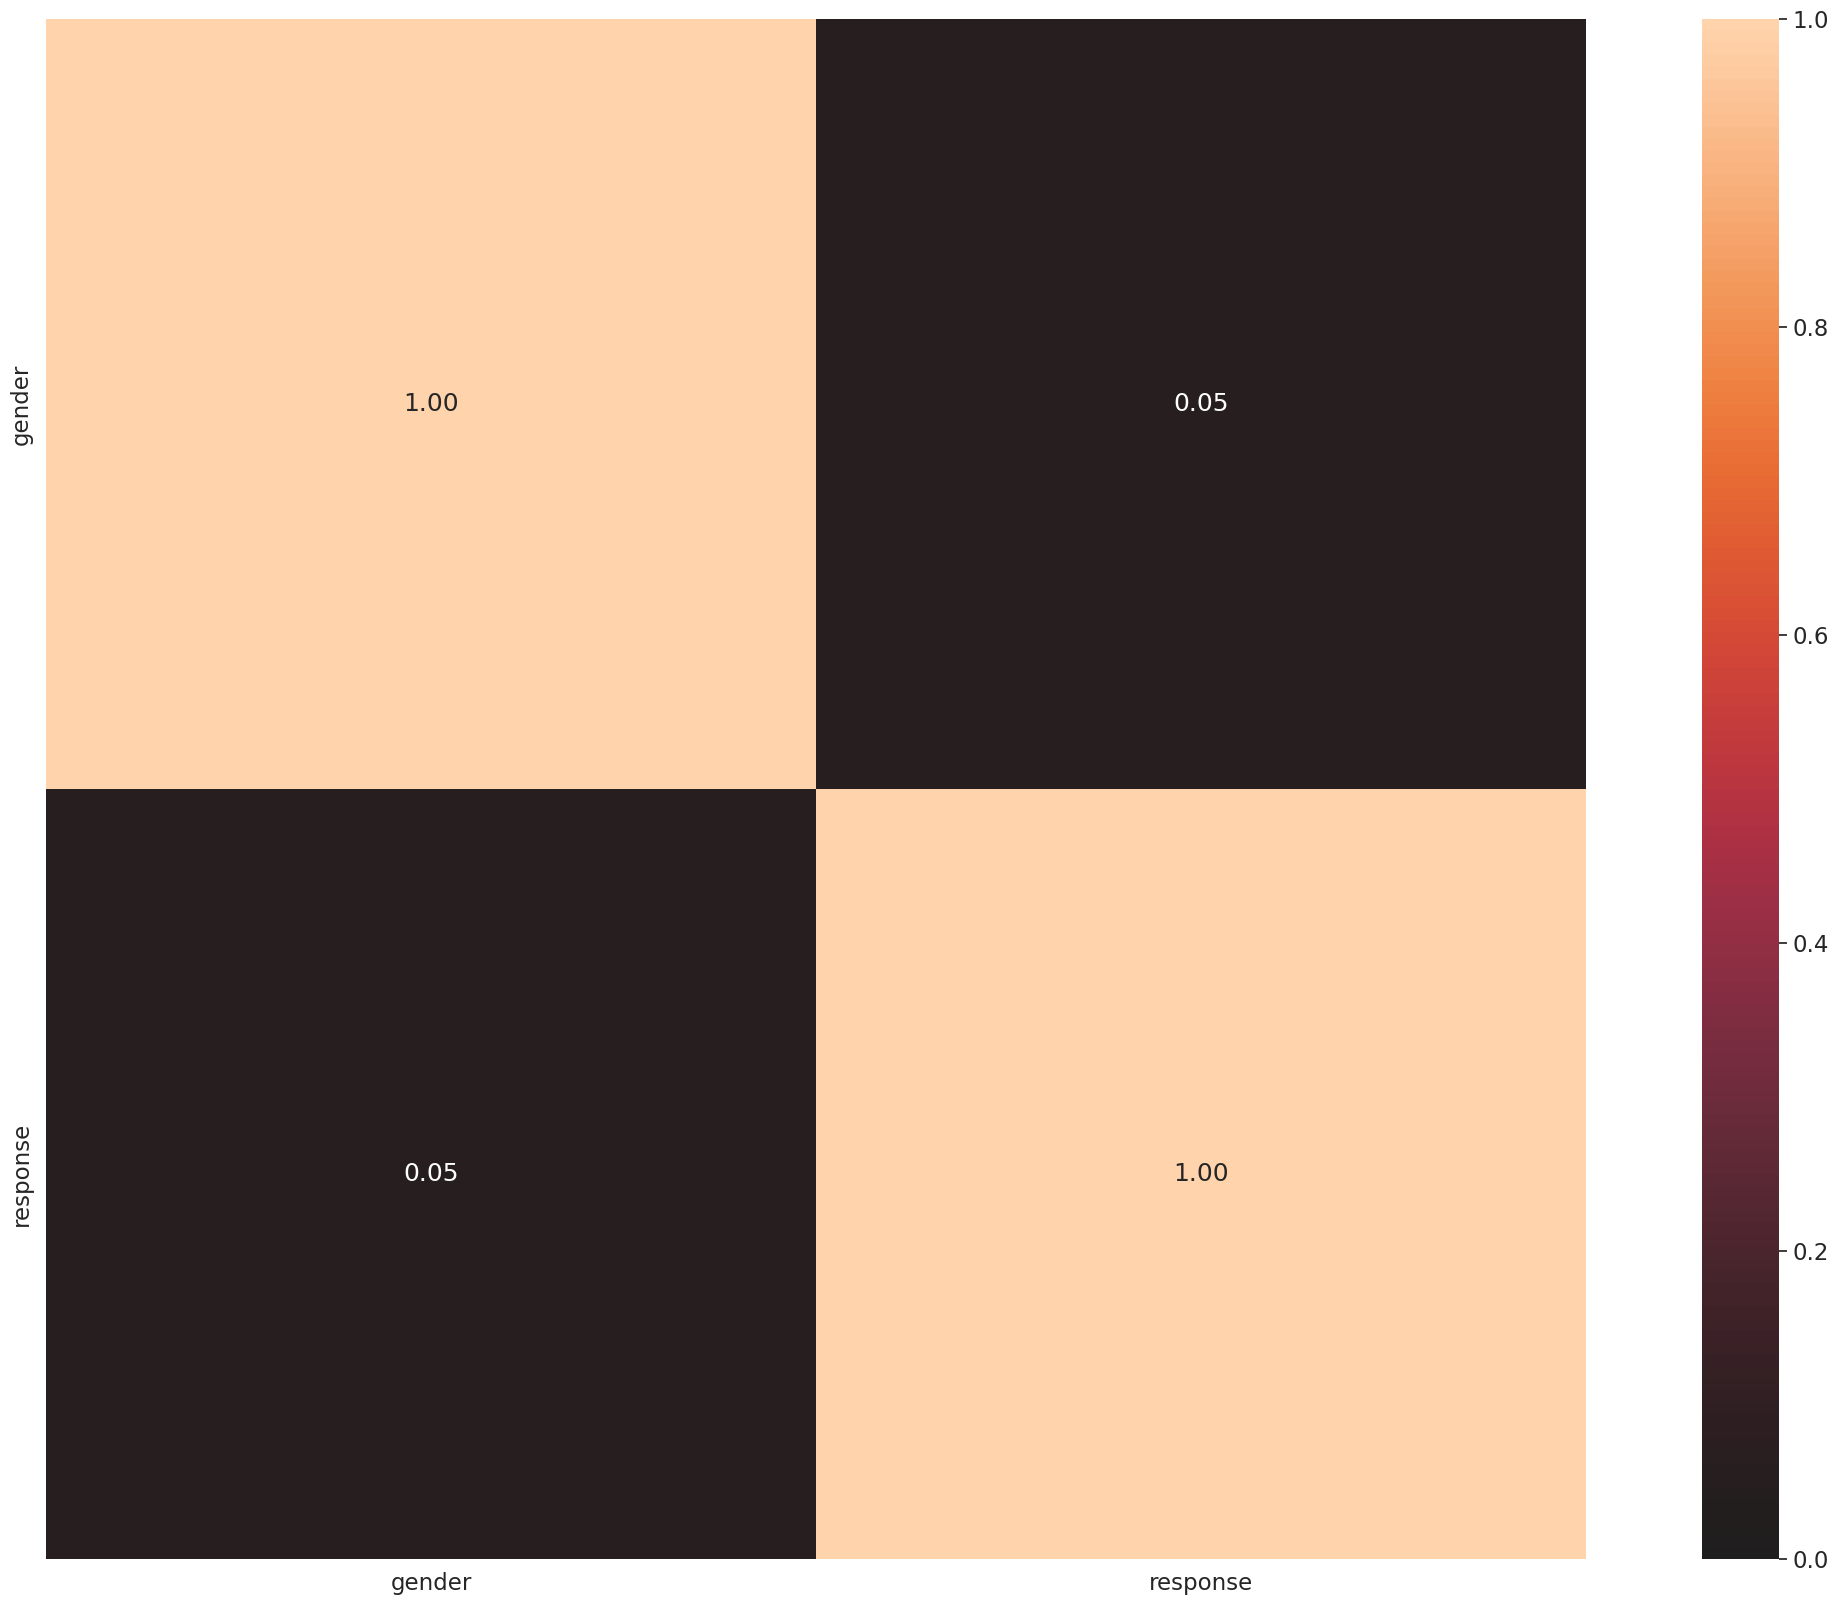

response  Interested  Not Interested     All
gender                                      
Female         18185          156835  175020
Male           28525          177564  206089
All            46710          334399  381109
The P-Value of the ChiSq Test is: 1.3920277273068068e-225


response  Interested  Not Interested
gender                              
Female          0.10            0.90
Male            0.14            0.86

In [21]:
df3_aux1 = pd.crosstab(index=df3['gender'], columns=df3['response'], normalize='index' )
df3_aux2 = pd.crosstab(index=df3['gender'], columns=df3['response'],margins=True)
chisquared_test = chi2_contingency(df3_aux2)
sns.barplot(y='Interested',x='gender', data=df3_aux1.reset_index() [ ['gender','Interested'] ] );
nominal.associations(df3[['gender','response'] ] )
print(df3_aux2)
print('The P-Value of the ChiSq Test is:', chisquared_test[1])
df3_aux1

False. Actually proportion of men interested is 40% higher than women. The chi-squared test reject null hypothesis of independencies between gender and interested in car insurance. Correlation is weak.

### H2. The proportion of customers with more than 55 years old interested in getting a car insurance is 15% higher than customers between 35 and 55 years old

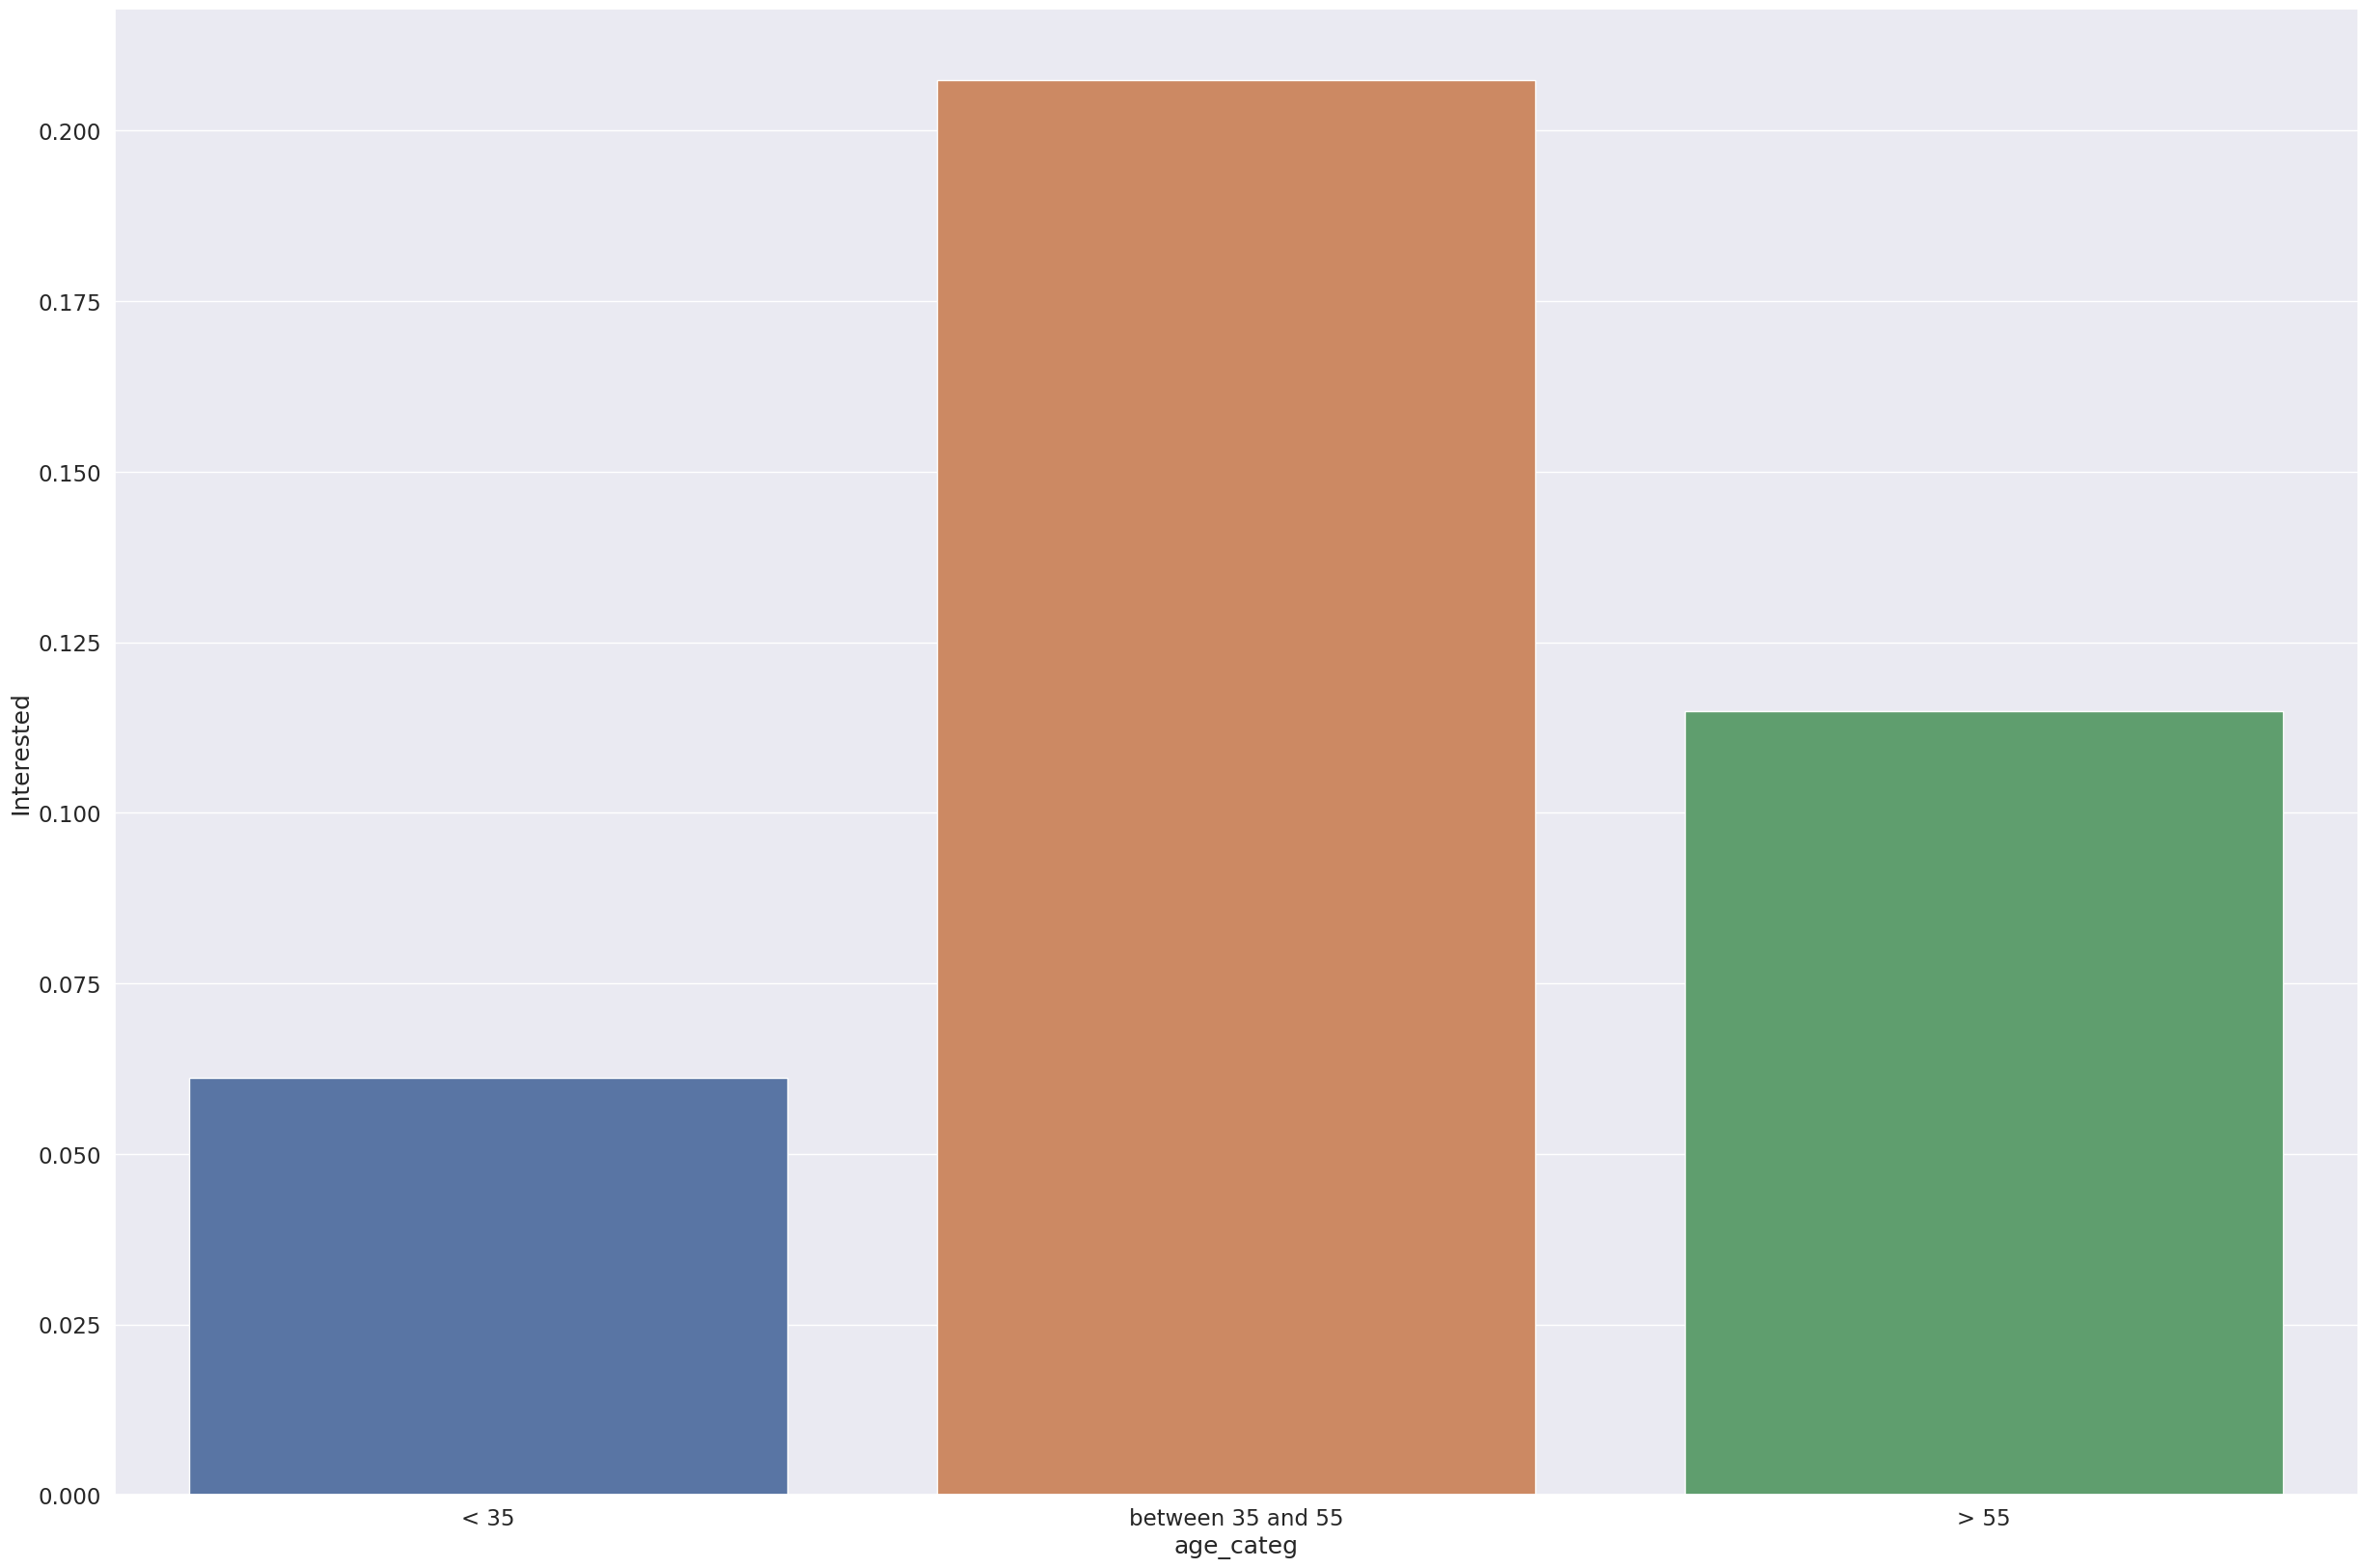

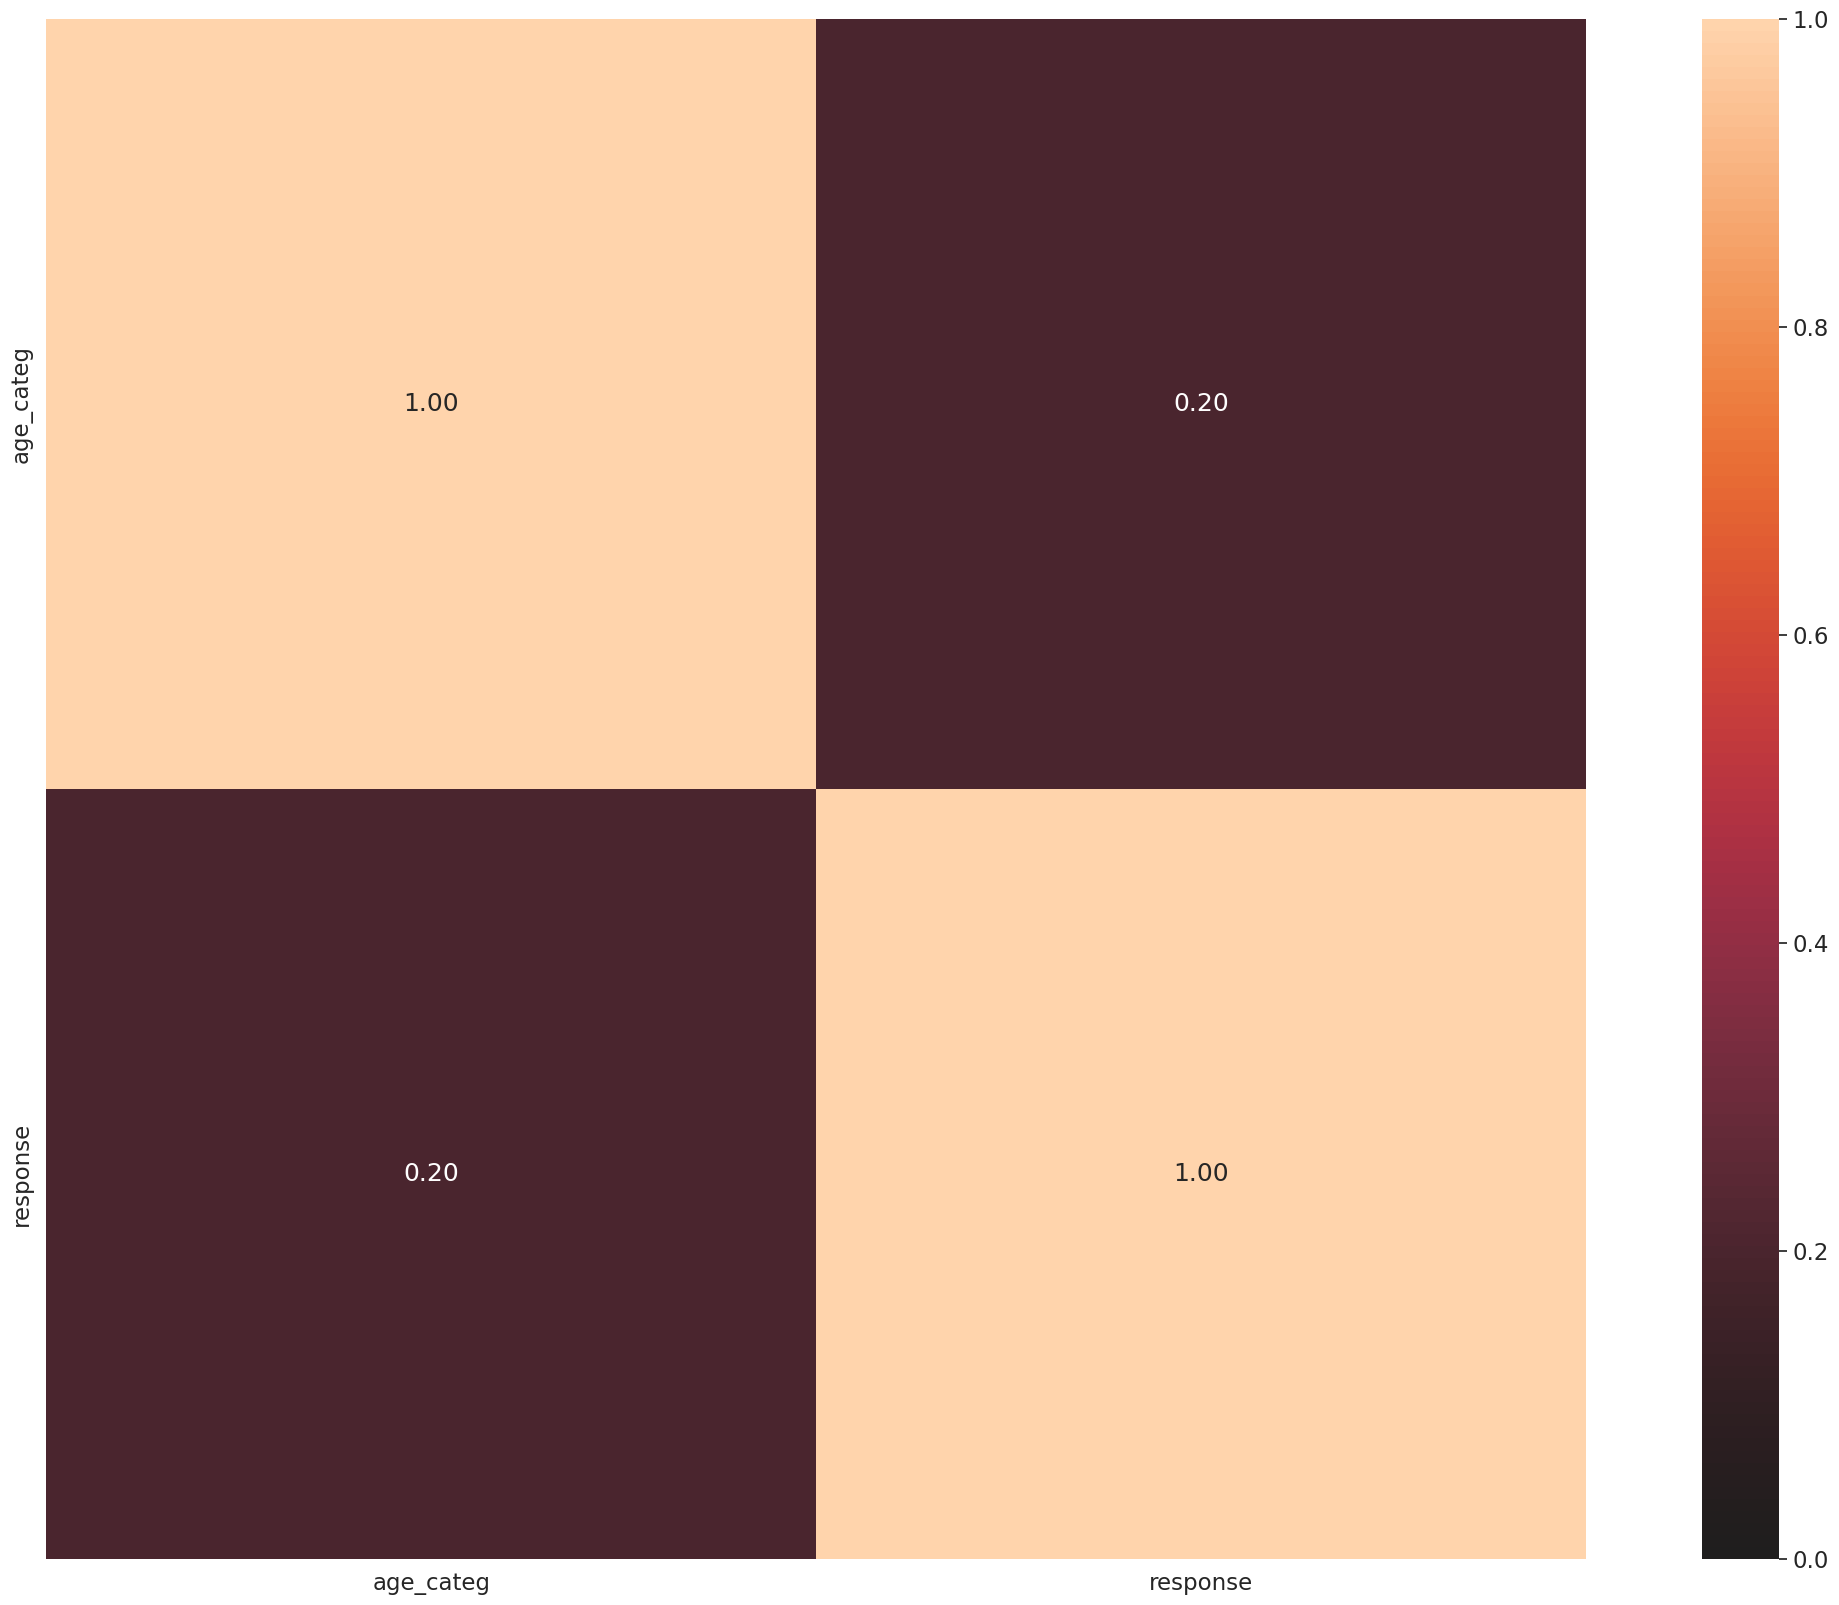

response           Interested  Not Interested     All
age_categ                                            
< 35                    11133          170743  181876
> 55                     7150           55066   62216
between 35 and 55       28427          108590  137017
All                     46710          334399  381109
The P-Value of the ChiSq Test is: 0.0


response           Interested  Not Interested
age_categ                                    
< 35                     0.06            0.94
> 55                     0.11            0.89
between 35 and 55        0.21            0.79

In [48]:
df3_aux1 = pd.crosstab(index=df3['age_categ'], columns=df3['response'], normalize='index' )
df3_aux2 = pd.crosstab(index=df3['age_categ'], columns=df3['response'],margins=True)
chisquared_test = chi2_contingency(df3_aux2)
sns.barplot(y='Interested',x='age_categ', data=df3_aux1.reset_index() [ ['age_categ','Interested'] ], order=['< 35', 'between 35 and 55', '> 55'] );
nominal.associations(df3[['age_categ','response'] ] )
print(df3_aux2)
print('The P-Value of the ChiSq Test is:', chisquared_test[1])
df3_aux1

False. In fact the proportion of customers between 35 and 55 years old interested in getting a car insurance is almost double of proportion of customers who has more than 55 years old. 
Chi-squared test show no independencies between features and correlation is moderate.

### H4.  The proportion of customers with driving license interested in getting a car insurance is 30% higher than customers without driving license.

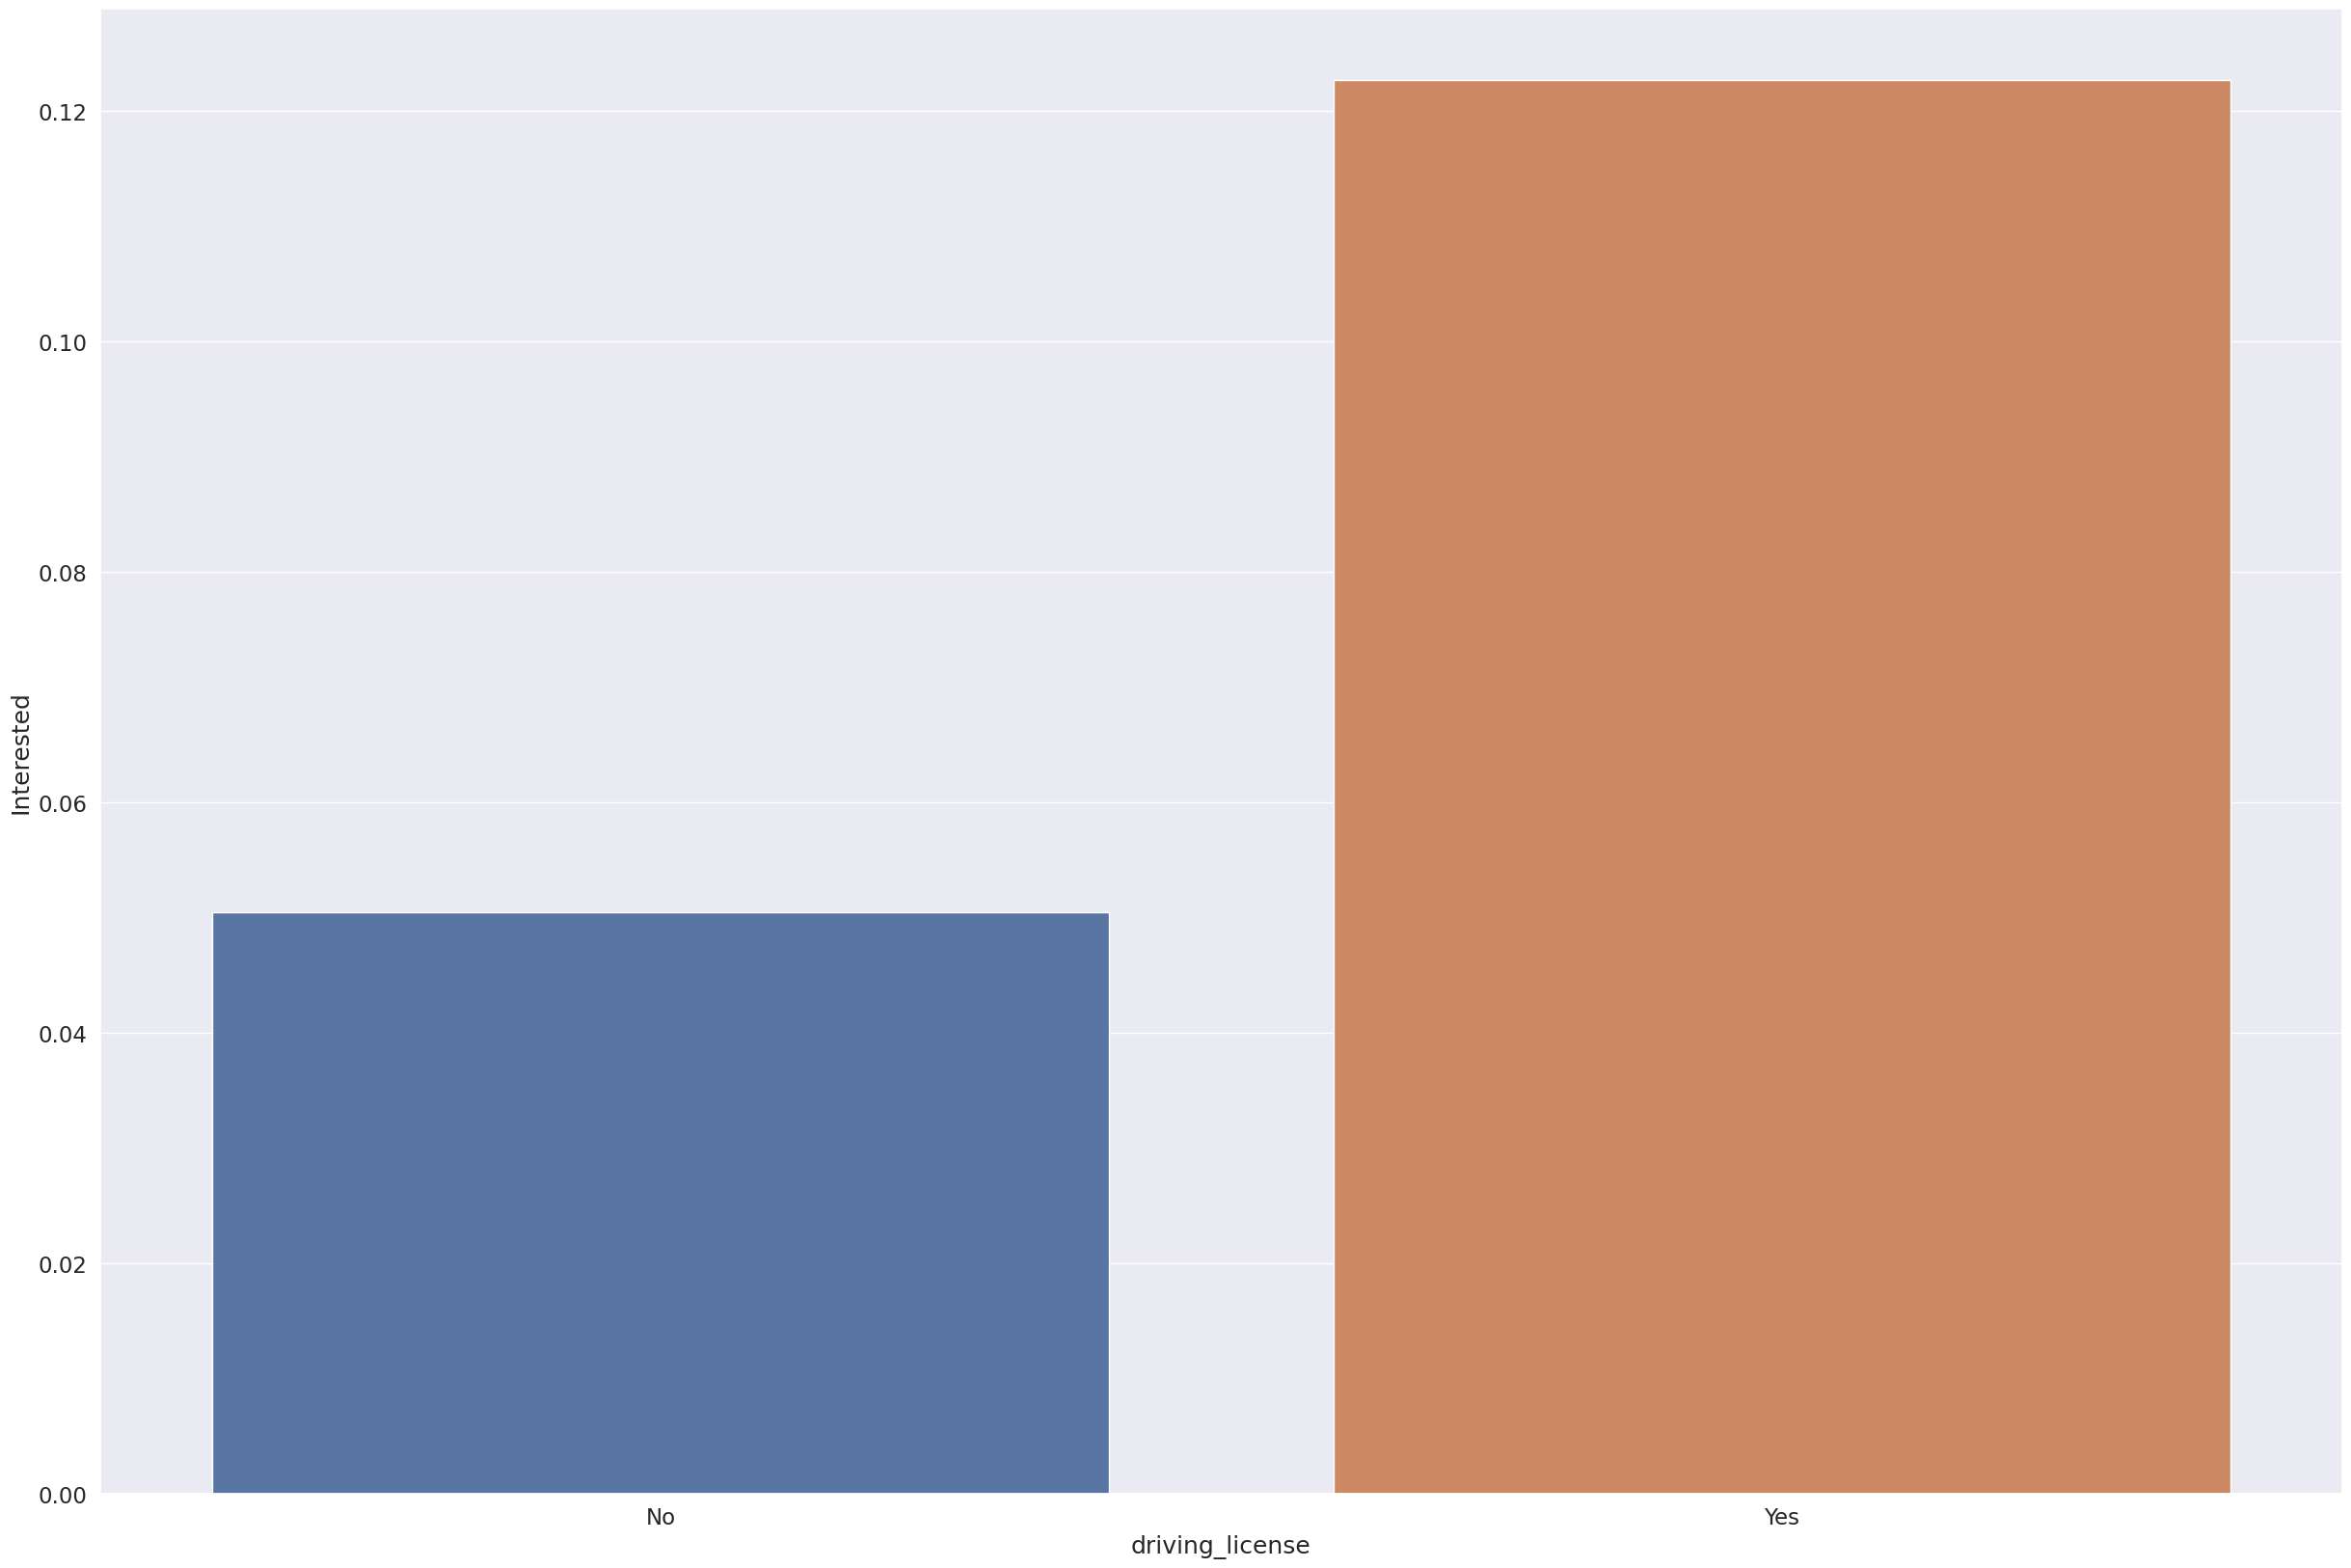

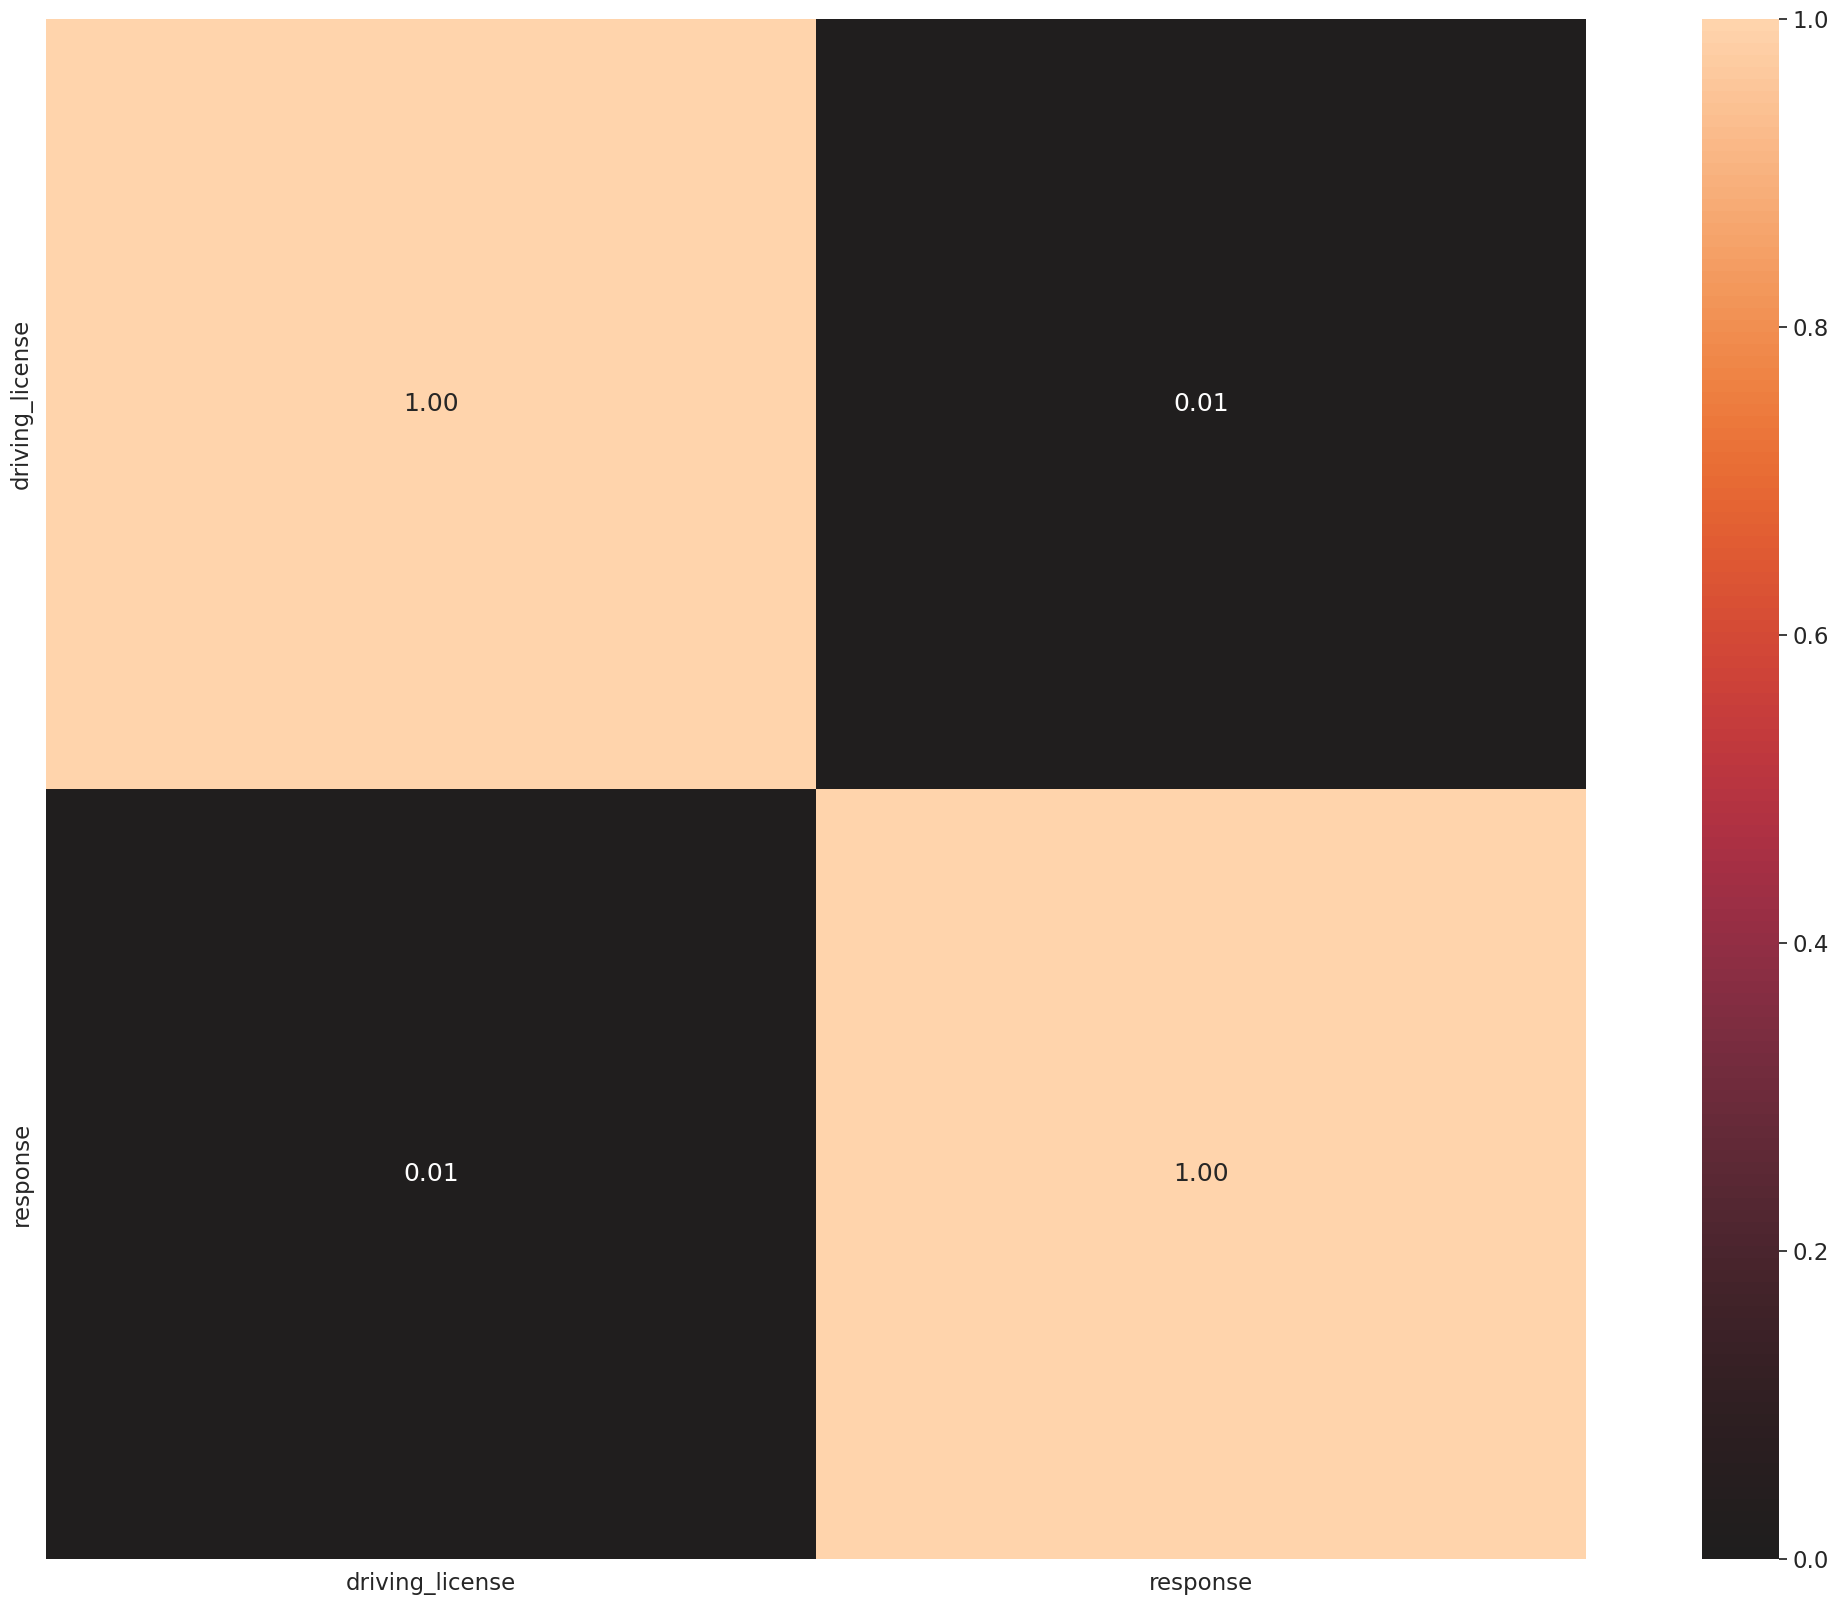

response         Interested  Not Interested     All
driving_license                                    
No                       41             771     812
Yes                   46669          333628  380297
All                   46710          334399  381109
The P-Value of the ChiSq Test is: 6.031780396108634e-08


response         Interested  Not Interested
driving_license                            
No                     0.05            0.95
Yes                    0.12            0.88

In [28]:
df3_aux1 = pd.crosstab(index=df3['driving_license'], columns=df3['response'], normalize='index' )
df3_aux2 = pd.crosstab(index=df3['driving_license'], columns=df3['response'],margins=True)
chisquared_test = chi2_contingency(df3_aux2)
sns.barplot(y='Interested',x='driving_license', data=df3_aux1.reset_index() [ ['driving_license','Interested'] ] );
nominal.associations(df3[['driving_license','response'] ] )
print(df3_aux2)
print('The P-Value of the ChiSq Test is:', chisquared_test[1])
df3_aux1

True. The proportion of customers with driving license interested in getting a car is more than double of proportion of customers who do not have.
Chi-squared test reject null hypothesis of independence between features

### H6. The proportion of customers who pays more than \\$40,000 in their health insurance and are  interested in getting a car insurance is 20%  higher than customers who pays less than \\$20,000

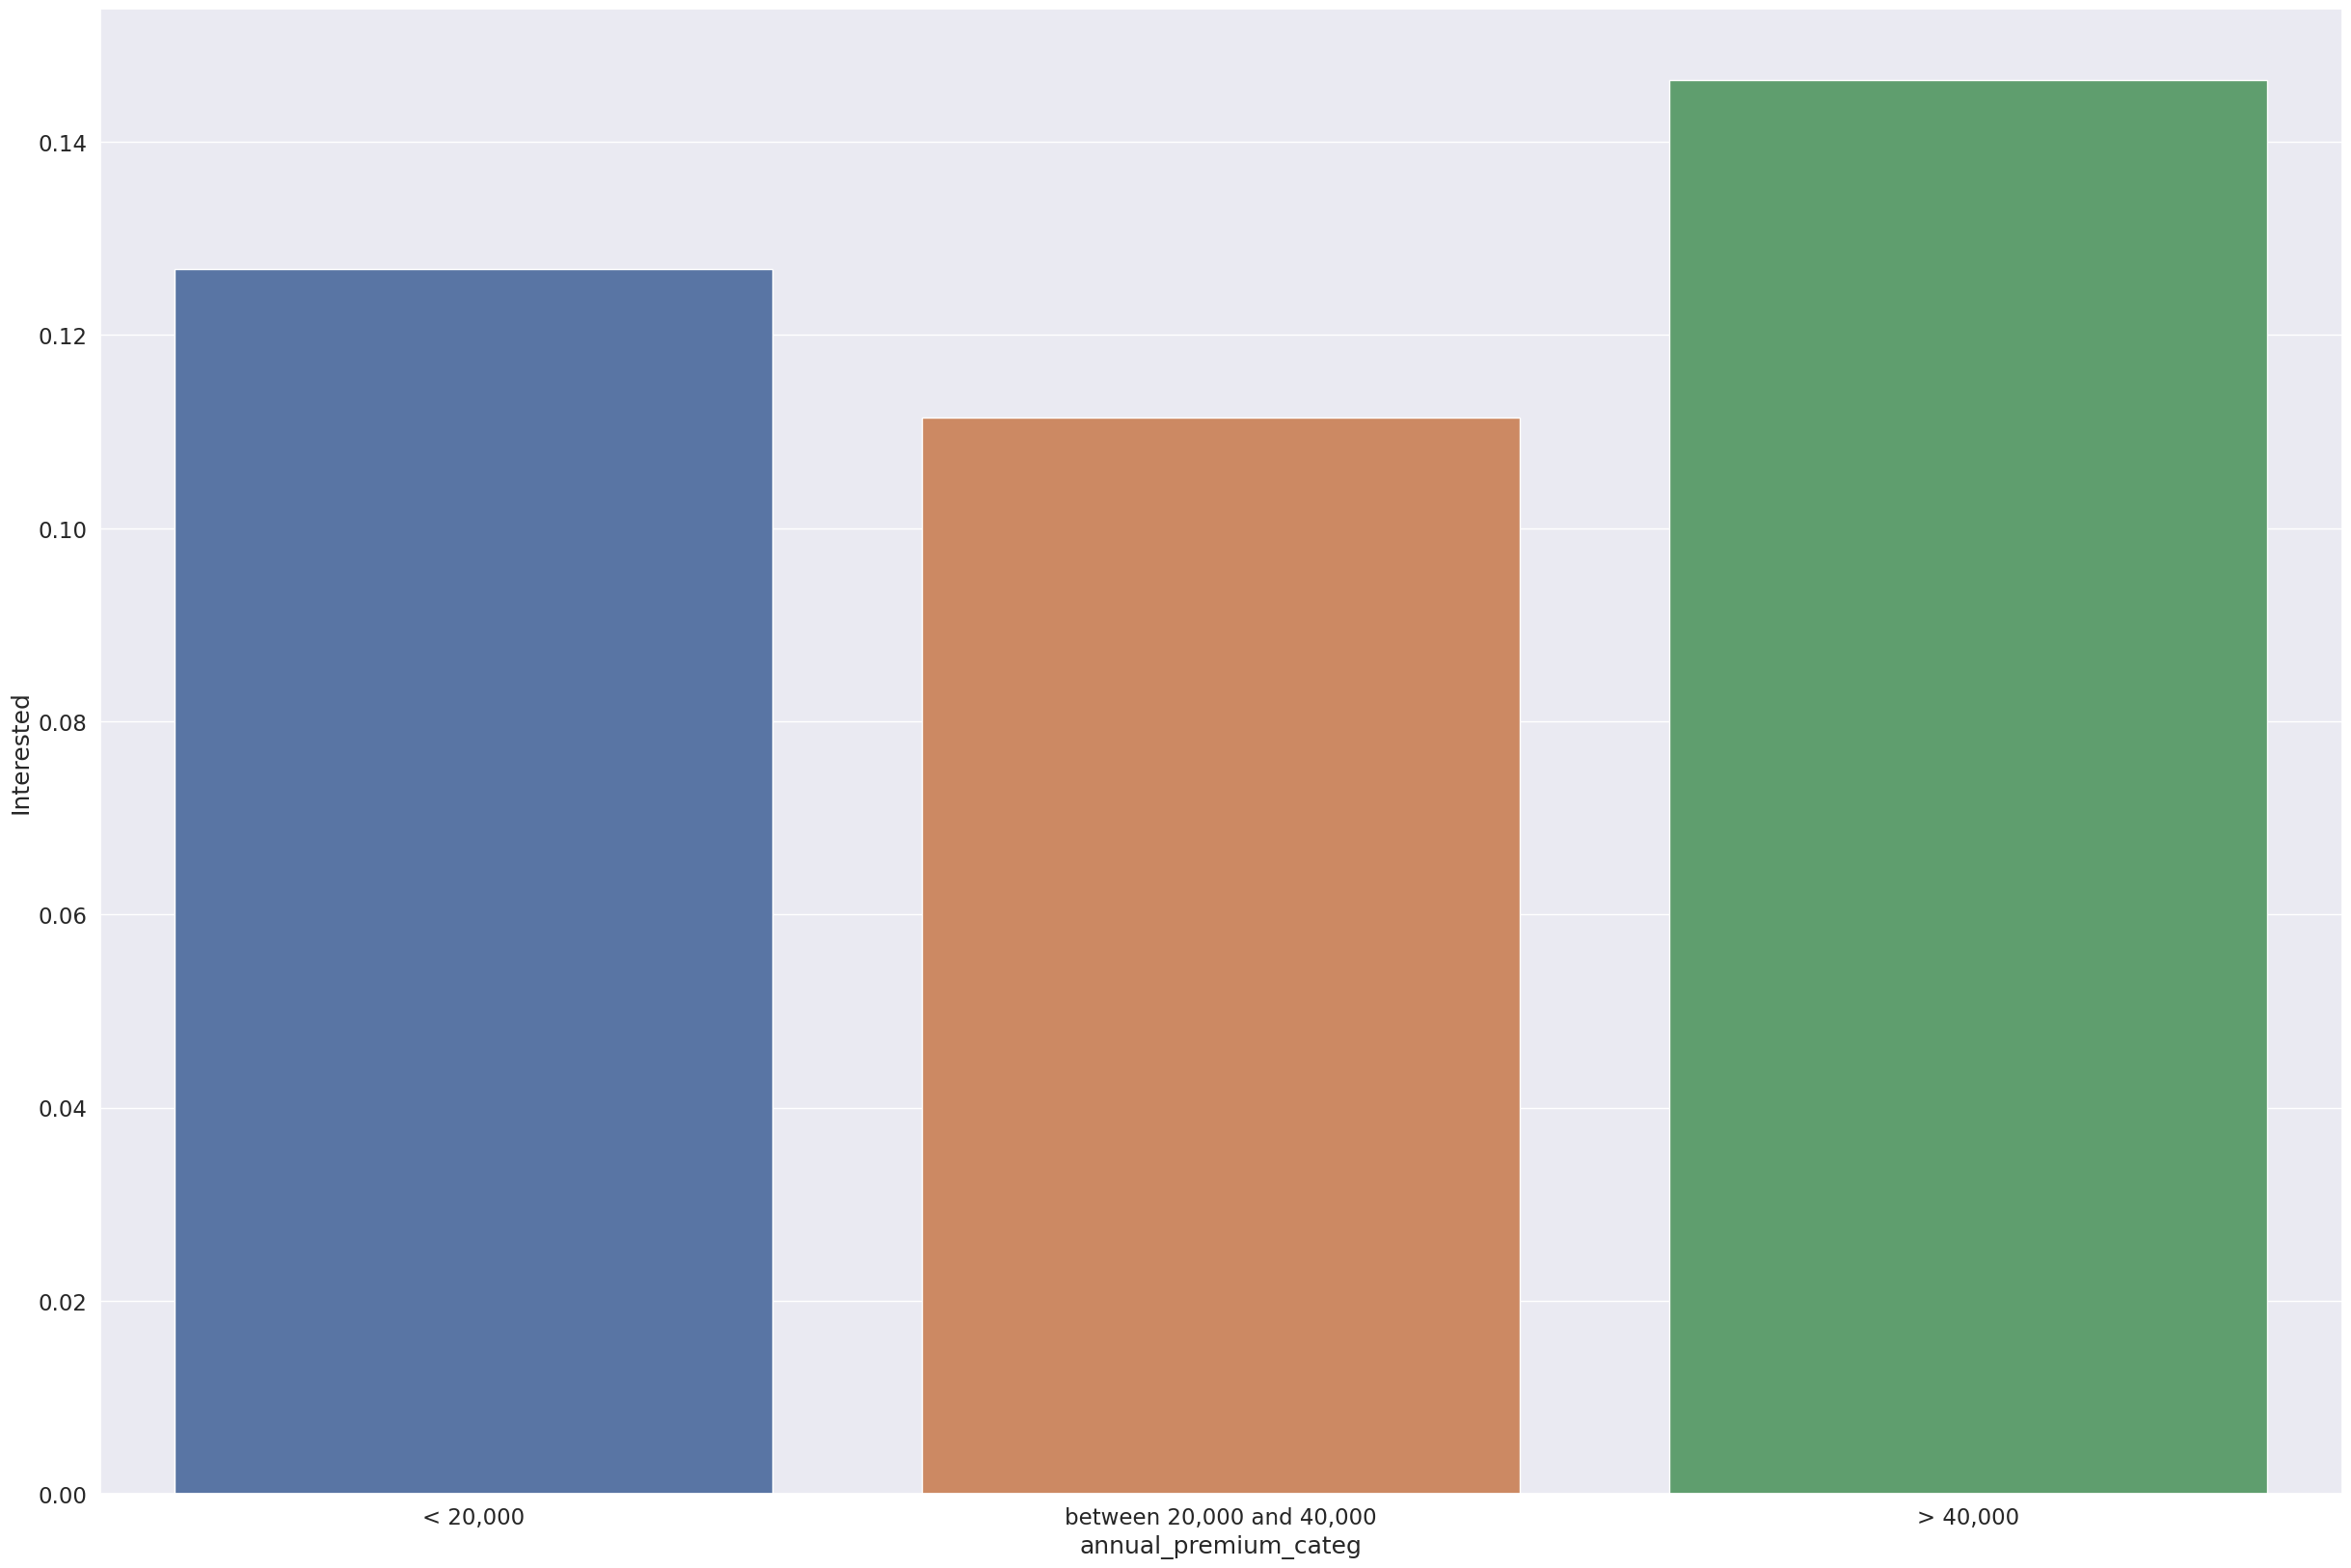

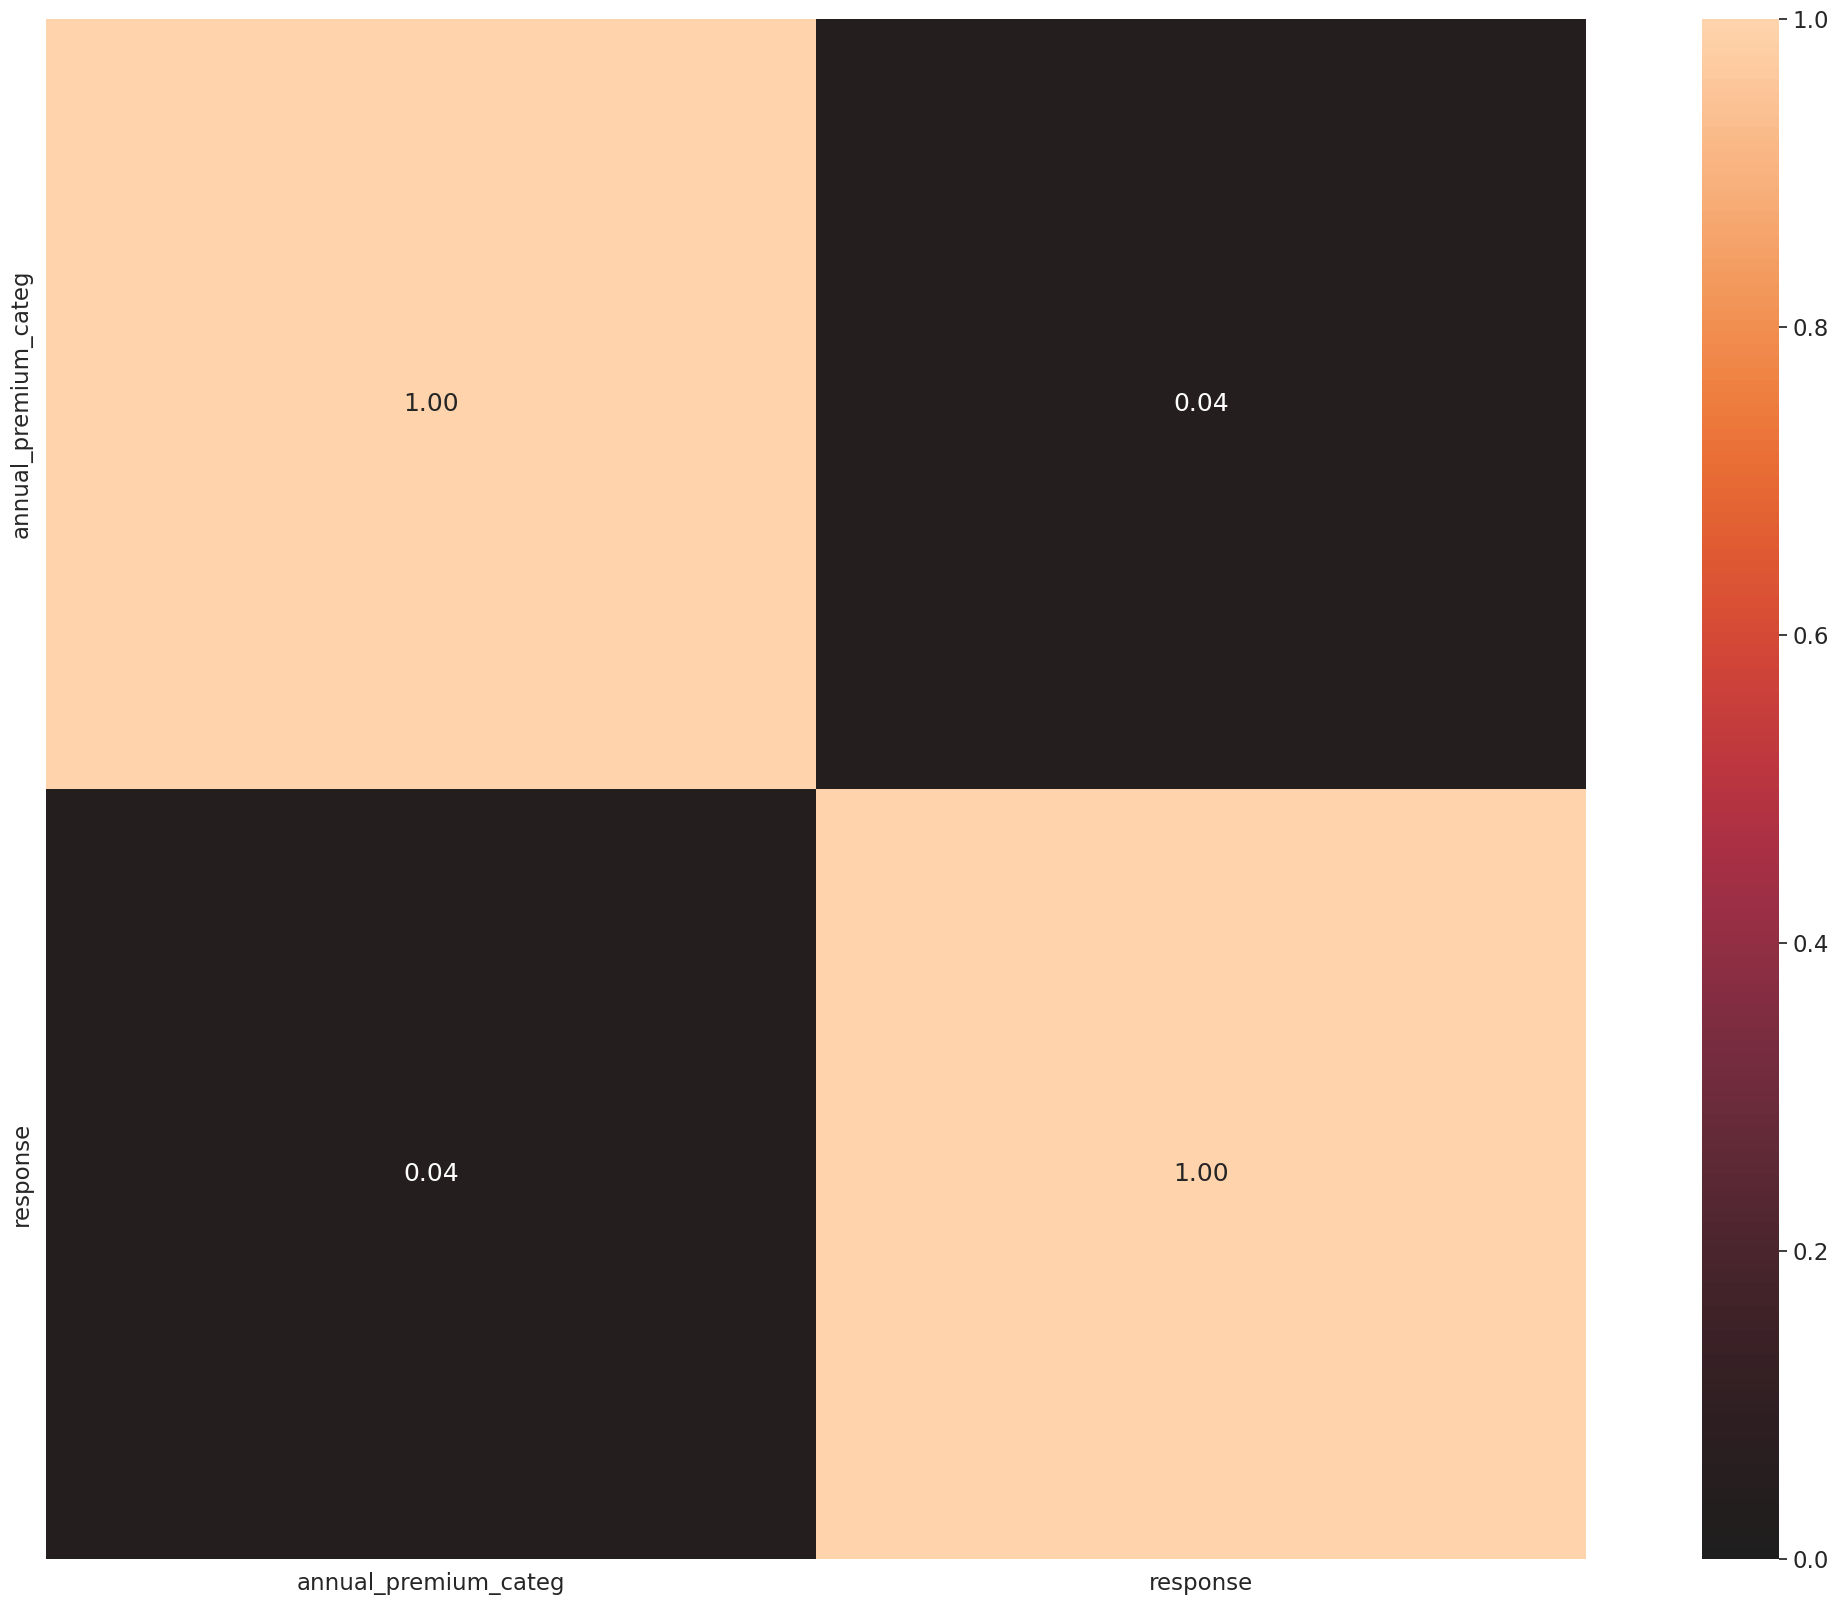

response                   Interested  Not Interested     All
annual_premium_categ                                         
< 20,000                         8962           61722   70684
> 40,000                        13178           76804   89982
between 20,000 and 40,000       24570          195873  220443
All                             46710          334399  381109
The P-Value of the ChiSq Test is: 5.105087785132141e-157


response                   Interested  Not Interested
annual_premium_categ                                 
< 20,000                         0.13            0.87
> 40,000                         0.15            0.85
between 20,000 and 40,000        0.11            0.89

In [46]:
df3_aux1 = pd.crosstab(index=df3['annual_premium_categ'], columns=df3['response'], normalize='index' )
df3_aux2 = pd.crosstab(index=df3['annual_premium_categ'], columns=df3['response'],margins=True)
chisquared_test = chi2_contingency(df3_aux2)
sns.barplot(y='Interested',x='annual_premium_categ', data=df3_aux1.reset_index() [ ['annual_premium_categ','Interested'] ] , 
           order=['< 20,000','between 20,000 and 40,000', '> 40,000'] );
nominal.associations(df3[['annual_premium_categ','response'] ] )
print(df3_aux2)
print('The P-Value of the ChiSq Test is:', chisquared_test[1] )
df3_aux1

False. The proportion of customers who pays more than \\$40,000 in their health insurance is approximately 15\% higher than who pays above $20,000. Chi-squared test shows we can reject the null hypothesis of independence. Correlation is weak.

### H7. The proportion of customers whose cars have less than 1 year old and are interested in getting a car insurance  is 15% higher than customers whose cars have more than 2 years old.

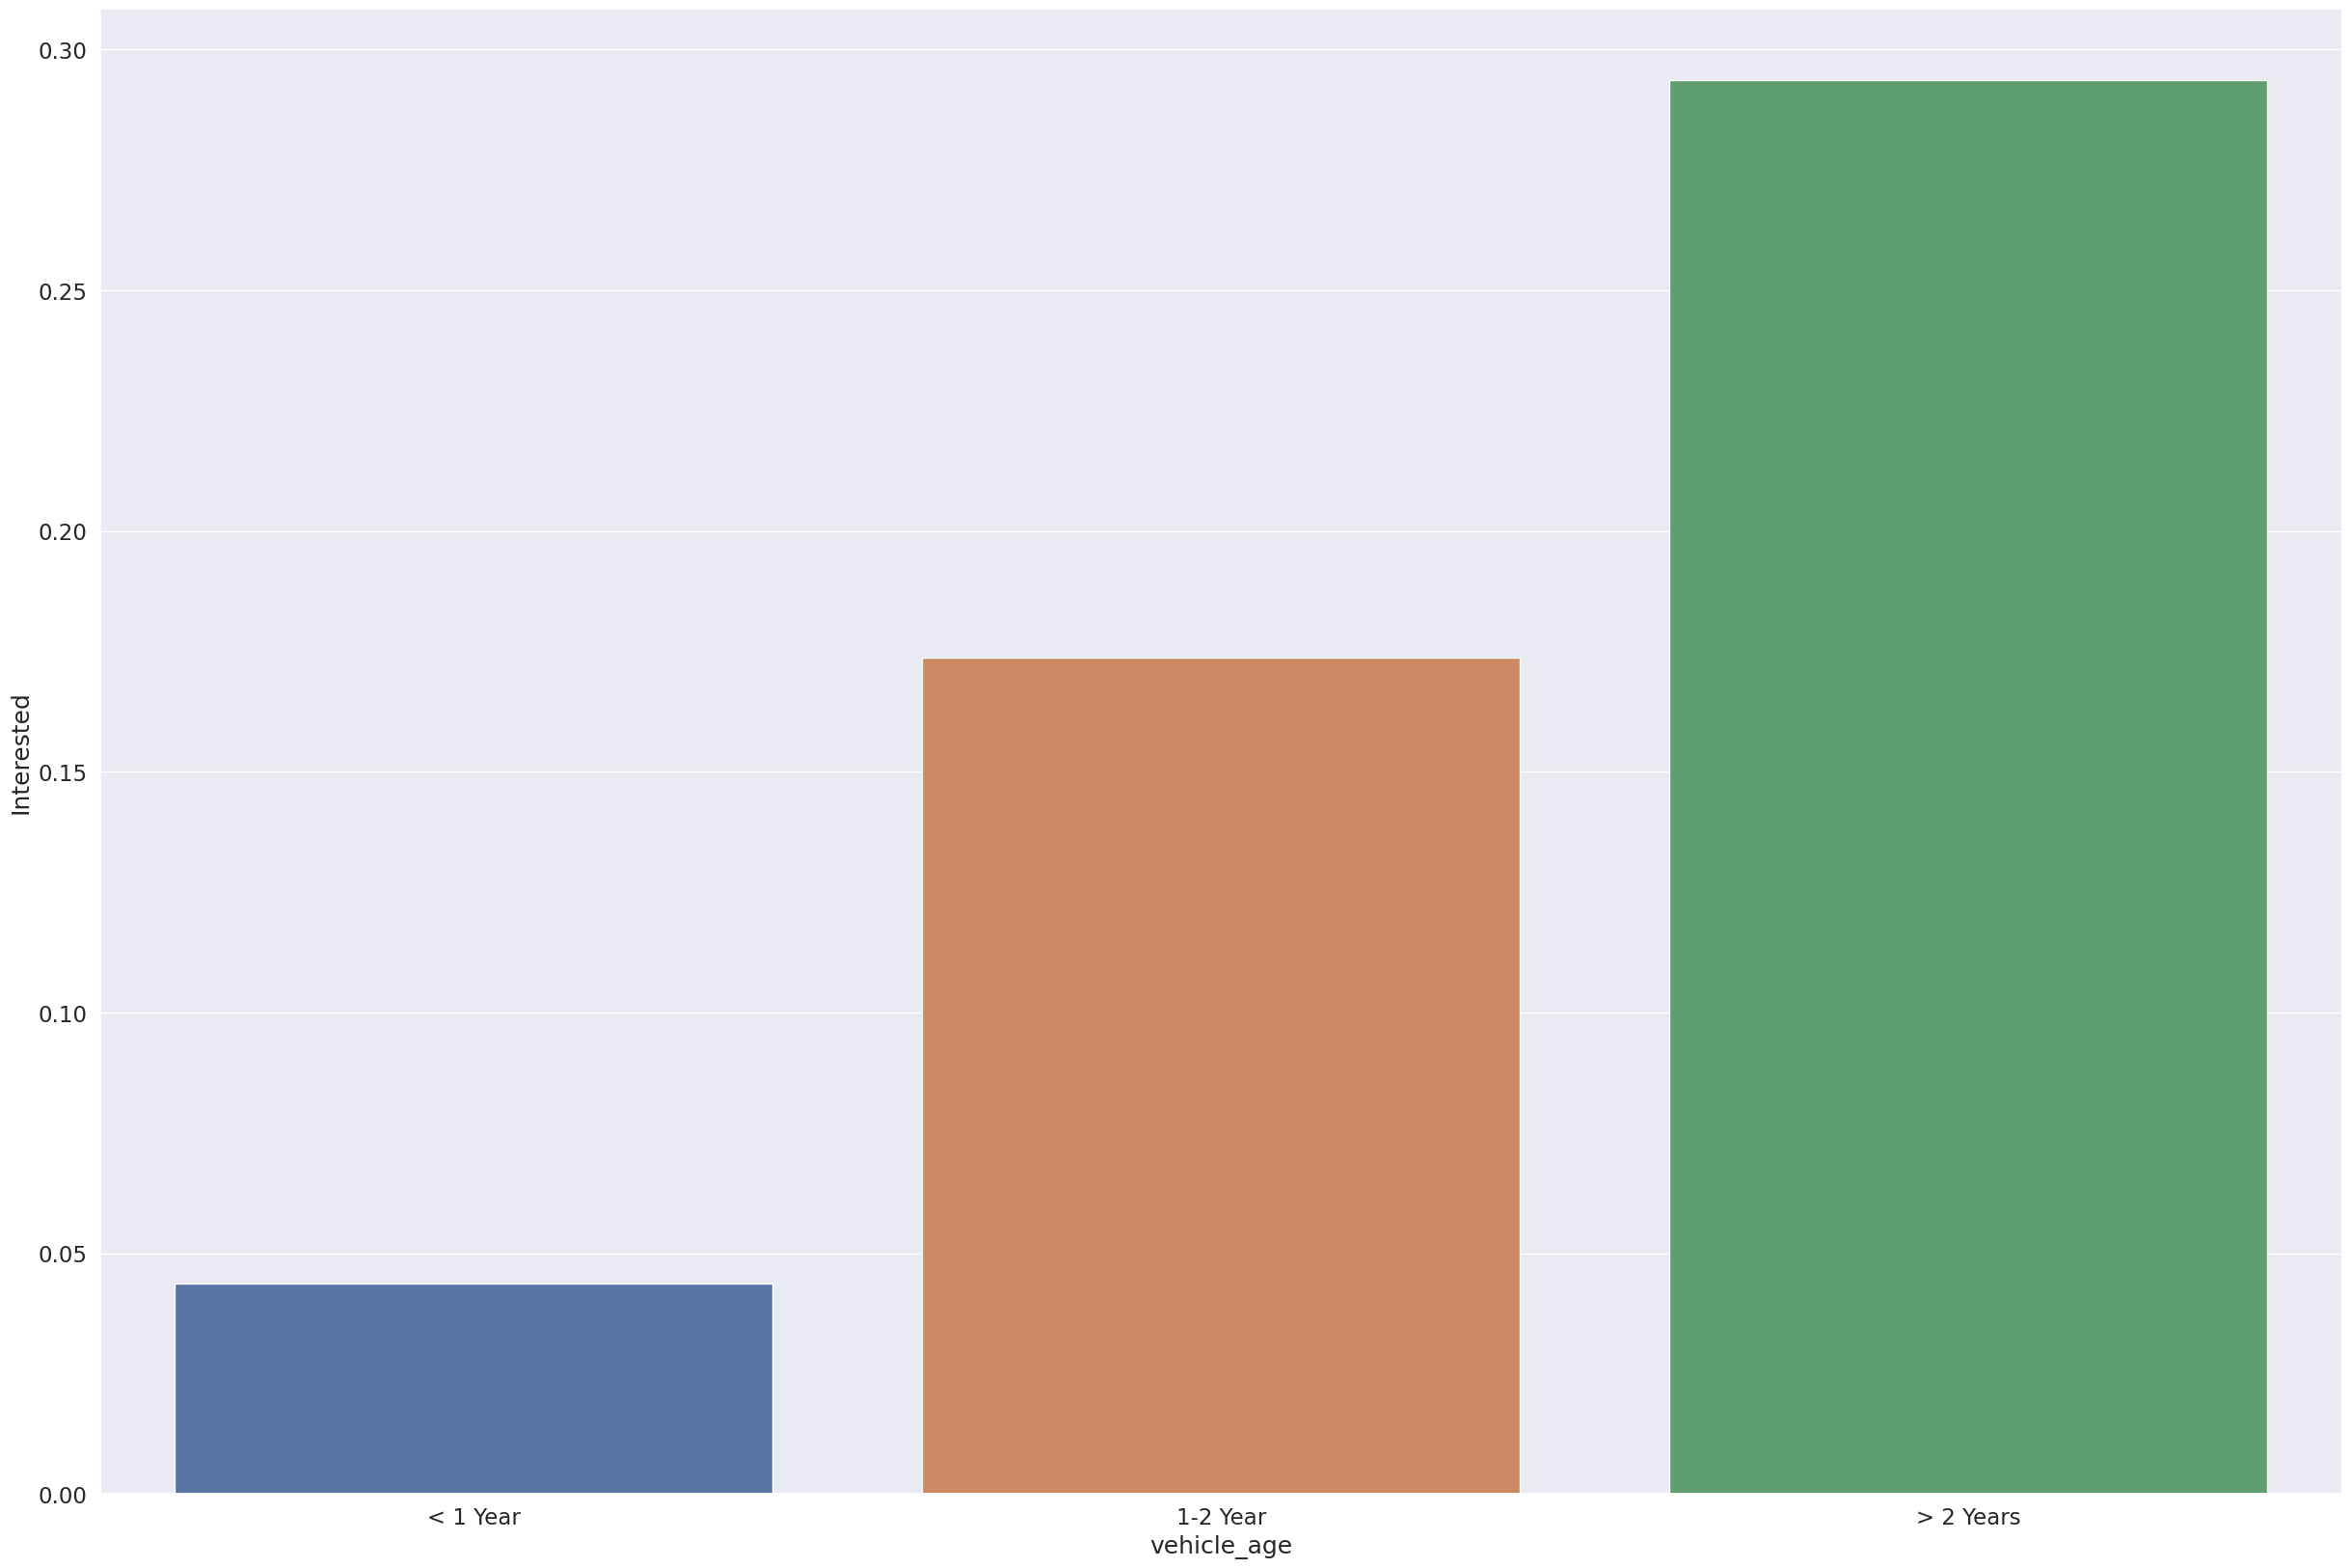

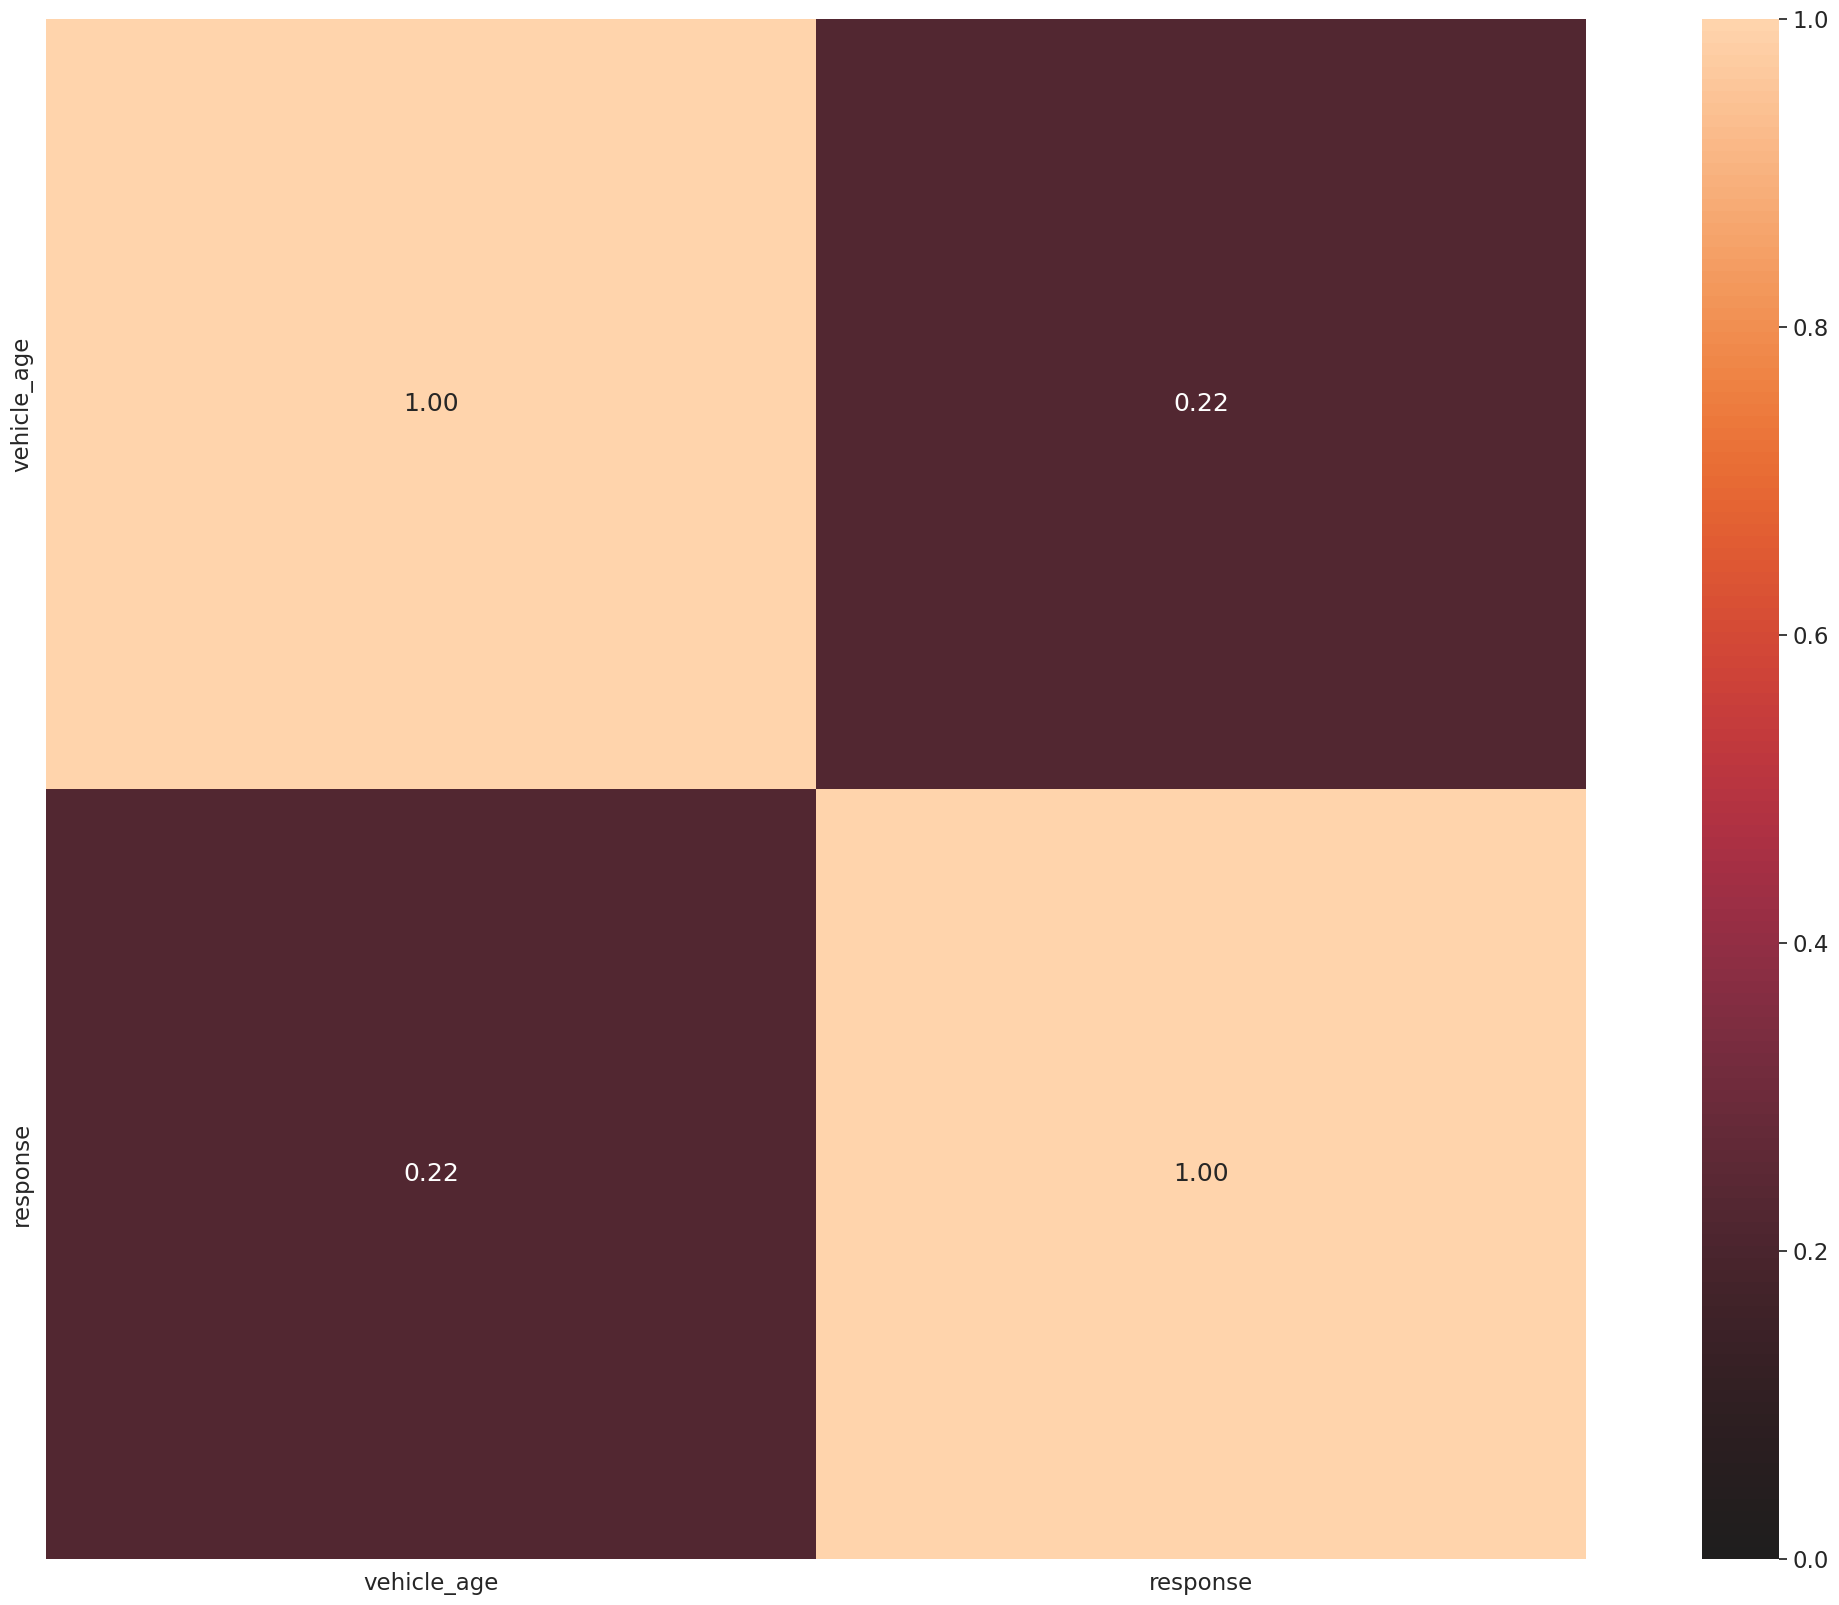

response     Interested  Not Interested     All
vehicle_age                                    
1-2 Year          34806          165510  200316
< 1 Year           7202          157584  164786
> 2 Years          4702           11305   16007
All               46710          334399  381109
The P-Value of the ChiSq Test is: 0.0


response     Interested  Not Interested
vehicle_age                            
1-2 Year           0.17            0.83
< 1 Year           0.04            0.96
> 2 Years          0.29            0.71

In [43]:
df3_aux1 = pd.crosstab(index=df3['vehicle_age'], columns=df3['response'], normalize='index' )
df3_aux2 = pd.crosstab(index=df3['vehicle_age'], columns=df3['response'],margins=True)
chisquared_test = chi2_contingency(df3_aux2)
sns.barplot(y='Interested',x='vehicle_age', data=df3_aux1.reset_index() [ ['vehicle_age','Interested'] ] , 
           order=['< 1 Year','1-2 Year','> 2 Years' ]  );
nominal.associations(df3[['vehicle_age','response'] ] )
print(df3_aux2)
print('The P-Value of the ChiSq Test is:', chisquared_test[1] )
df3_aux1

False. The proportion of customers who have cars with more than 2 years and are interested in getting a car insurance is about 700% higher than customers with newer cars (less than a year). Chi-squared test reject null hypothesis of independence. Correlation is moderate

###  H8. The proportion of customers whose cars suffered a damage in the past and are interested in getting a car insurance is 20% than customers who cars have not suffered a damage.

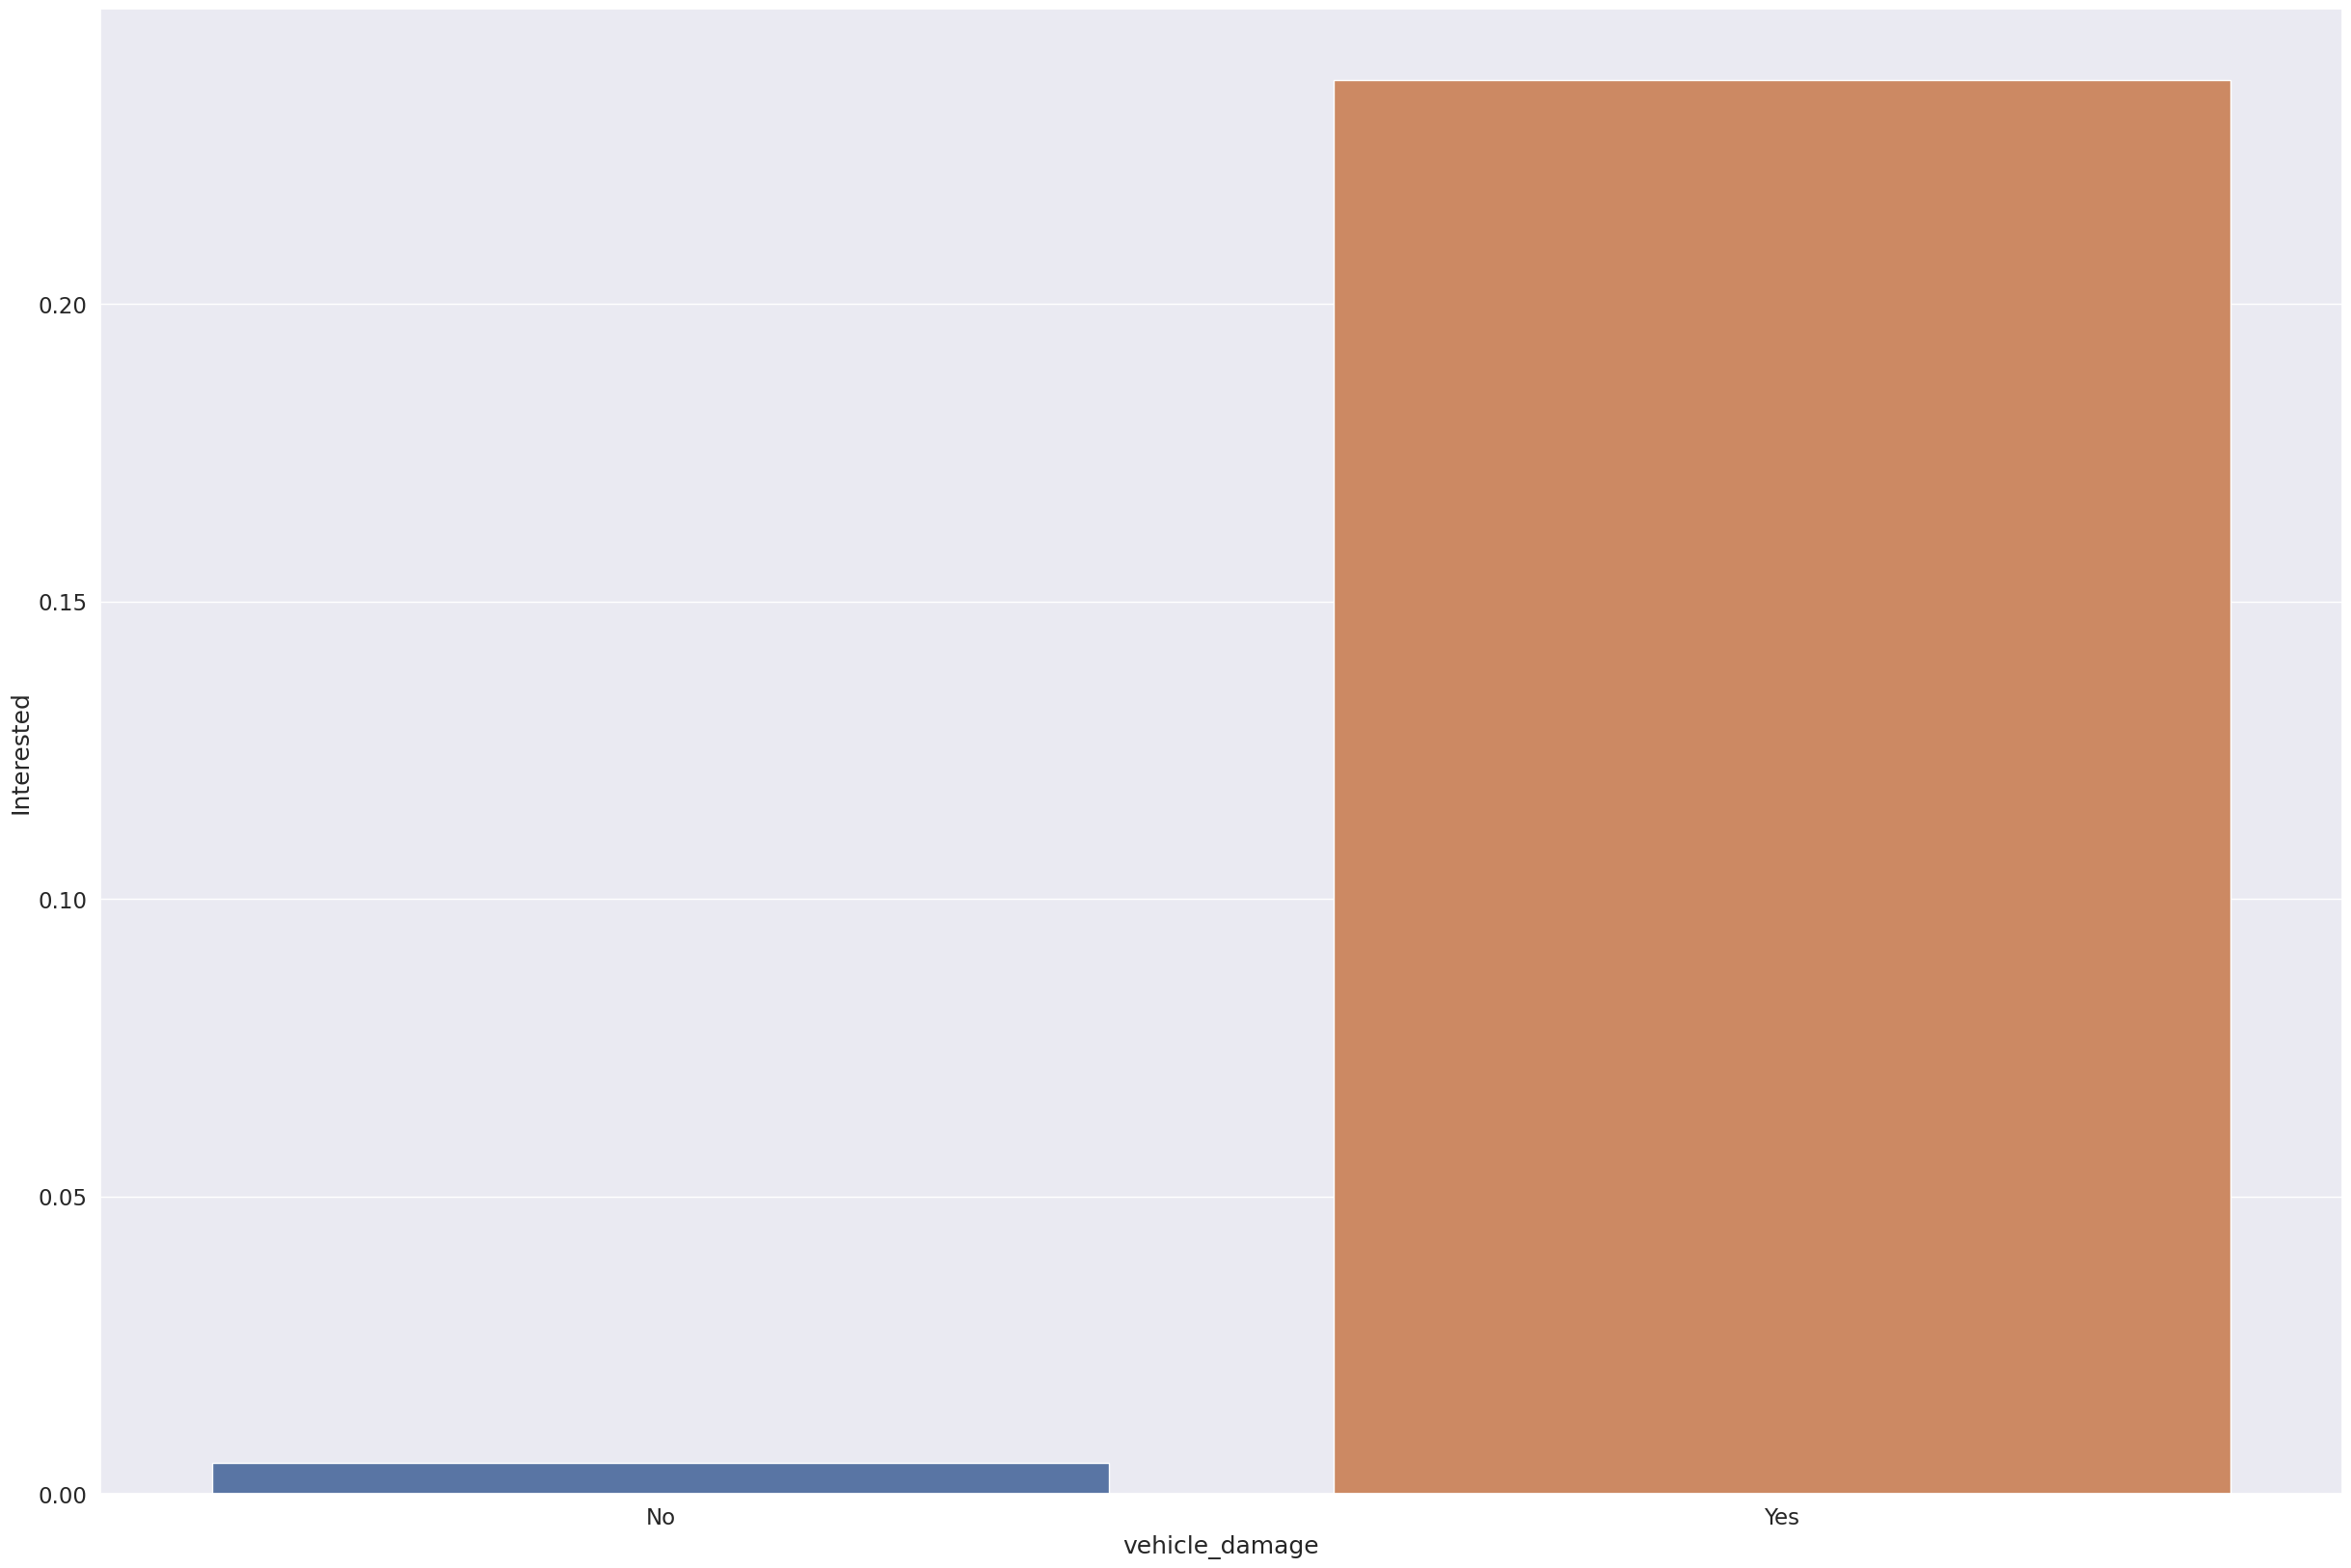

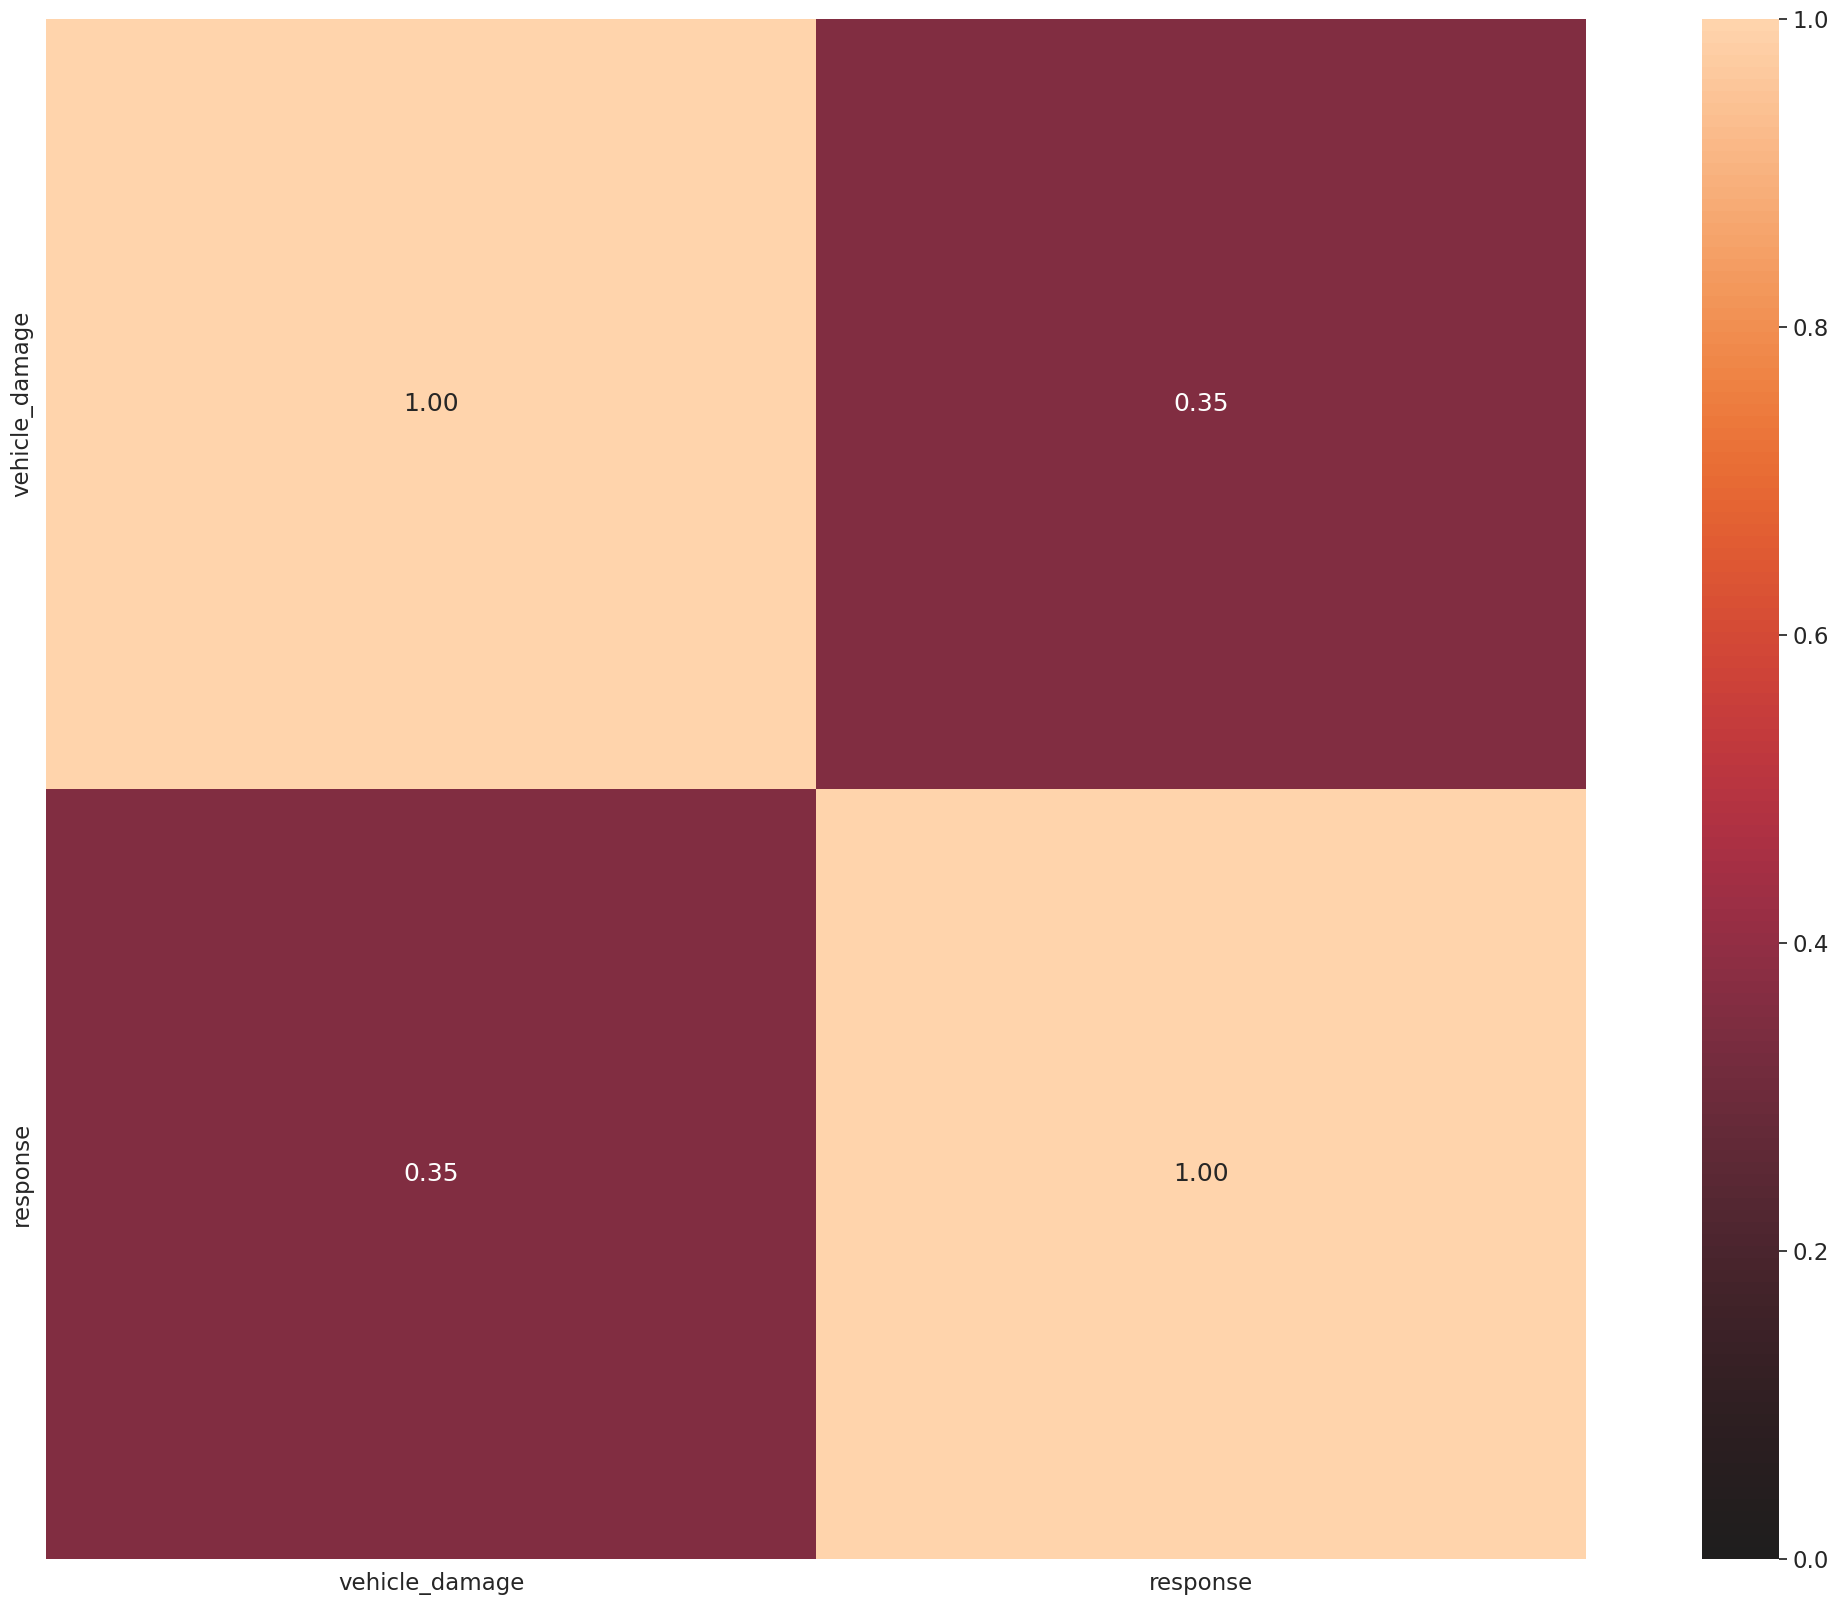

response        Interested  Not Interested     All
vehicle_damage                                    
No                     982          187714  188696
Yes                  45728          146685  192413
All                  46710          334399  381109
The P-Value of the ChiSq Test is: 0.0


response        Interested  Not Interested
vehicle_damage                            
No                    0.01            0.99
Yes                   0.24            0.76

In [35]:
df3_aux1 = pd.crosstab(index=df3['vehicle_damage'], columns=df3['response'], normalize='index' )
df3_aux2 = pd.crosstab(index=df3['vehicle_damage'], columns=df3['response'],margins=True)
chisquared_test = chi2_contingency(df3_aux2)
sns.barplot(y='Interested',x='vehicle_damage', data=df3_aux1.reset_index() [ ['vehicle_damage','Interested'] ]  );
nominal.associations(df3[['vehicle_damage','response'] ] )
print(df3_aux2)
print('The P-Value of the ChiSq Test is:', chisquared_test[1] )
df3_aux1

False. The proporcional is much higher than 20% and it is about 2400%. Chi-squared test rejects null hypothesis of independence. Correlation is moderate.

###  H9 The proportion of customers who do not have a car insurance and are interested in getting a car insurance is 25% higher than customers who already have one.

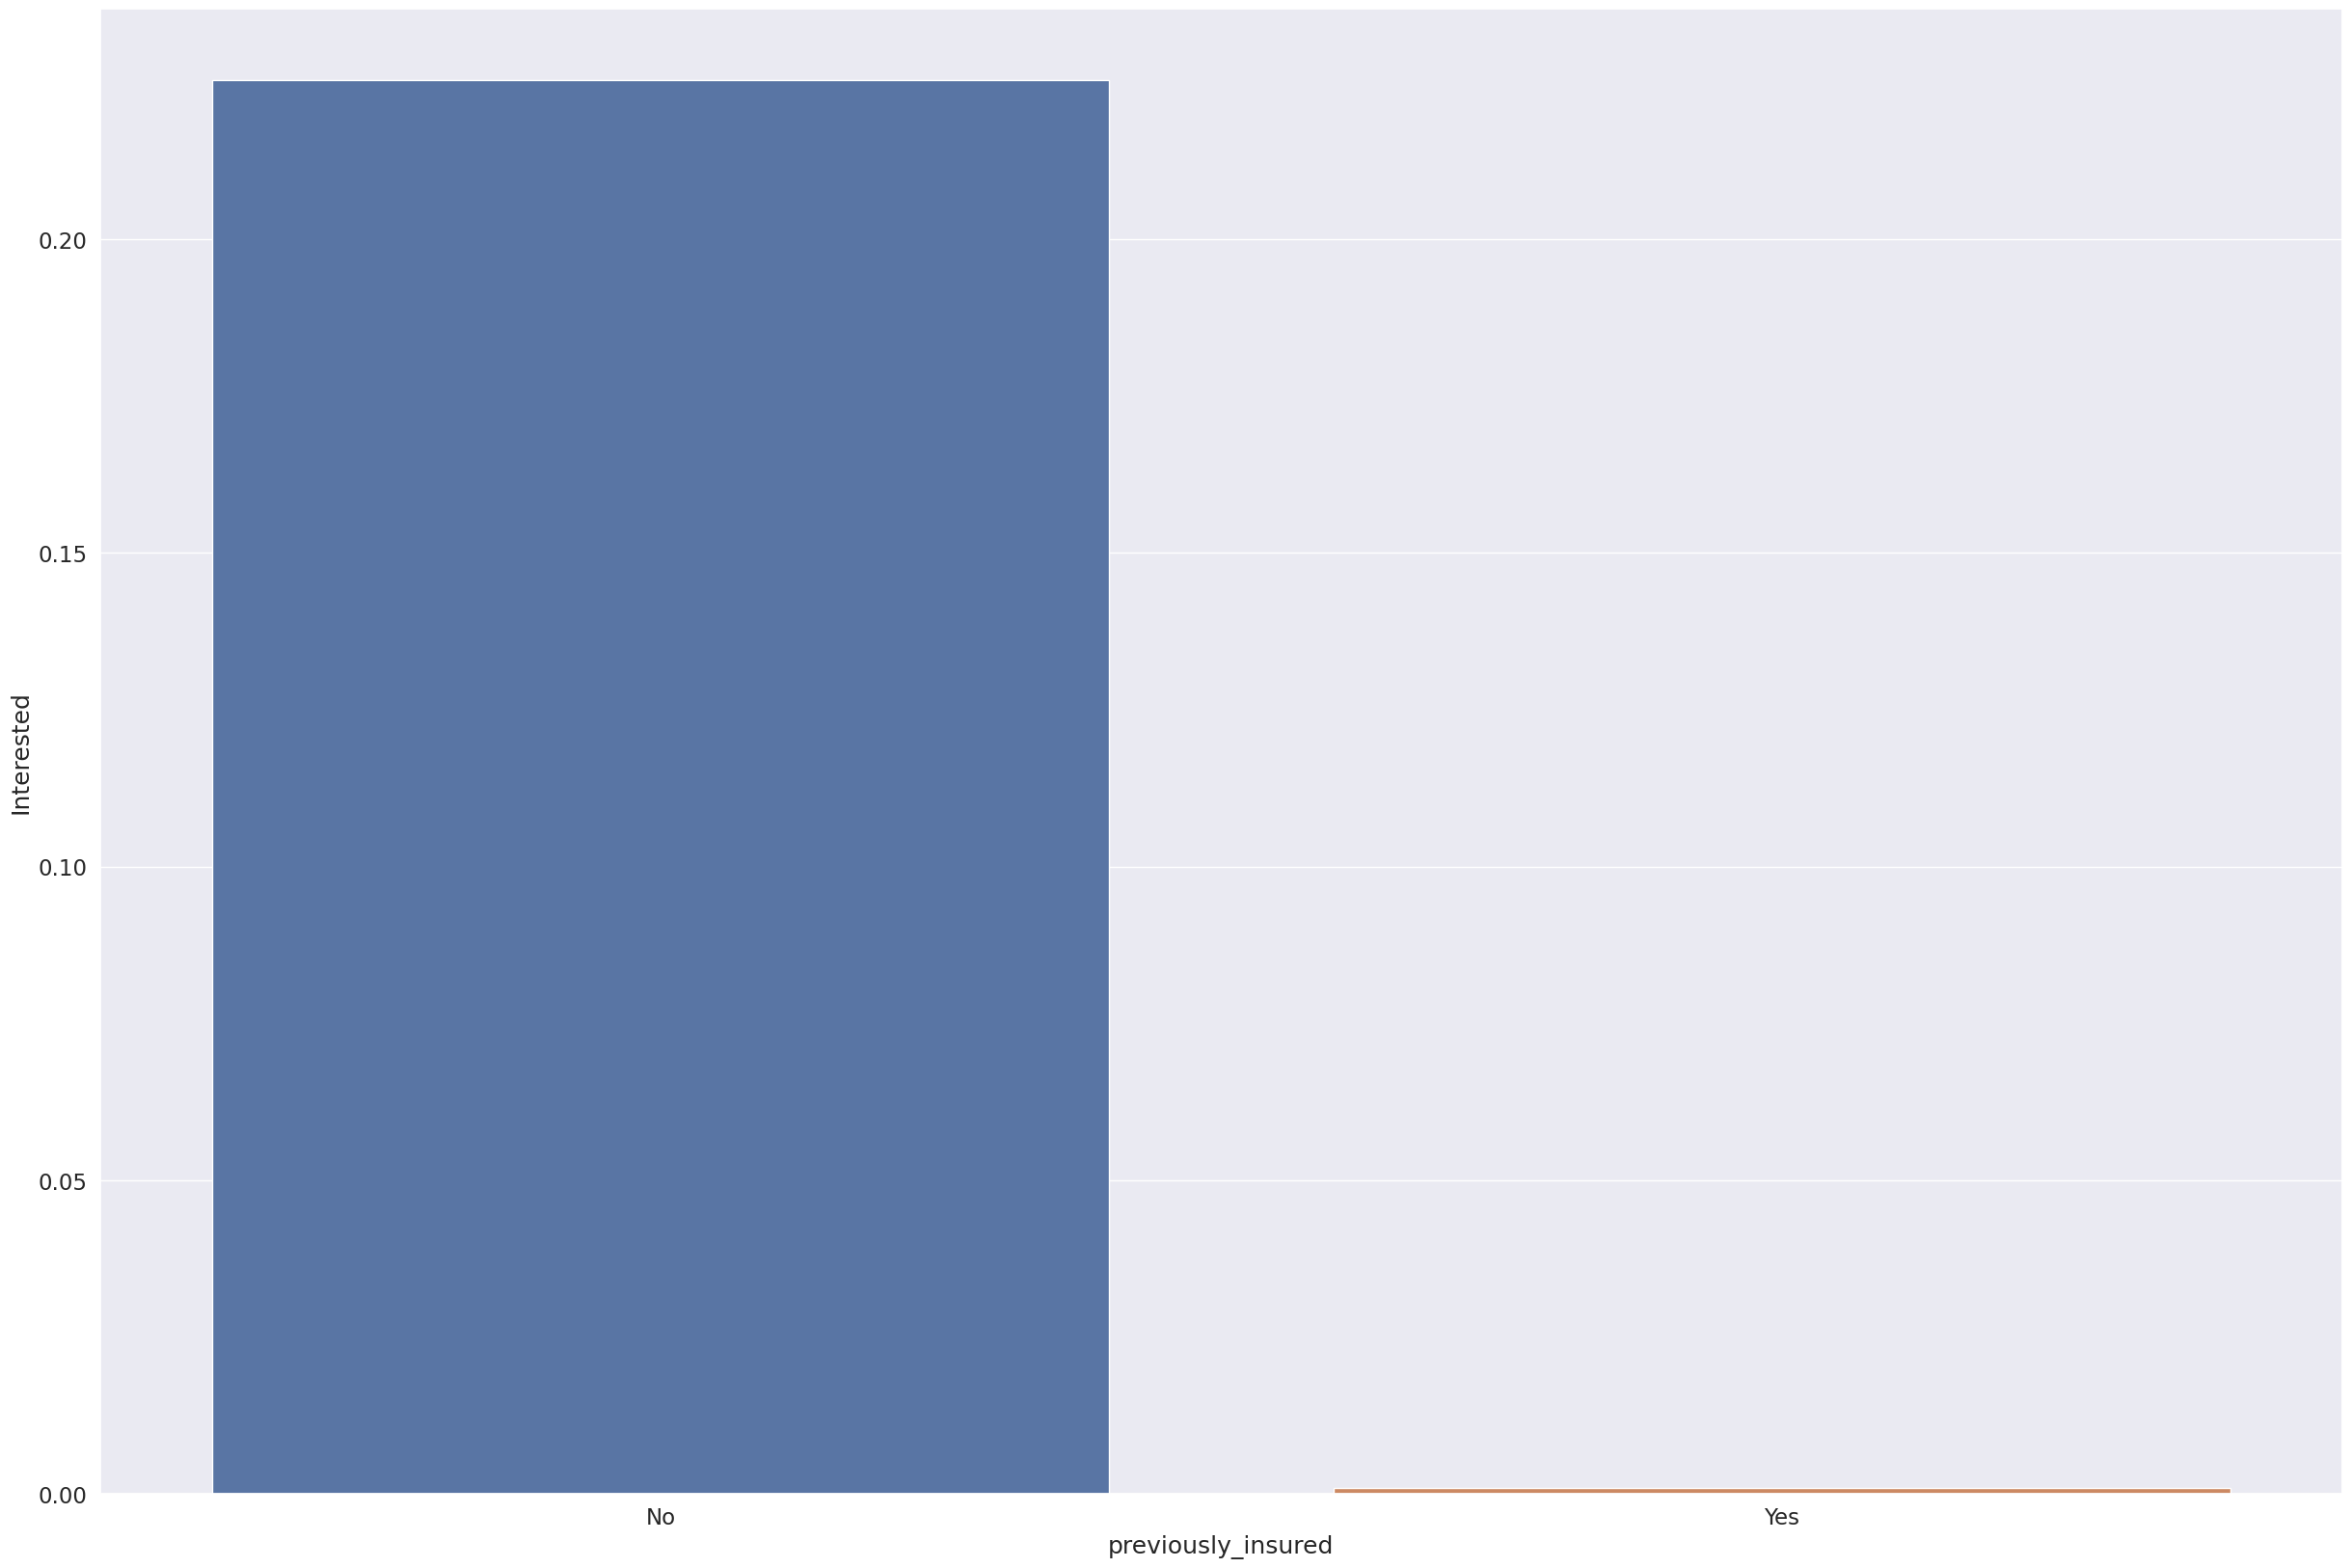

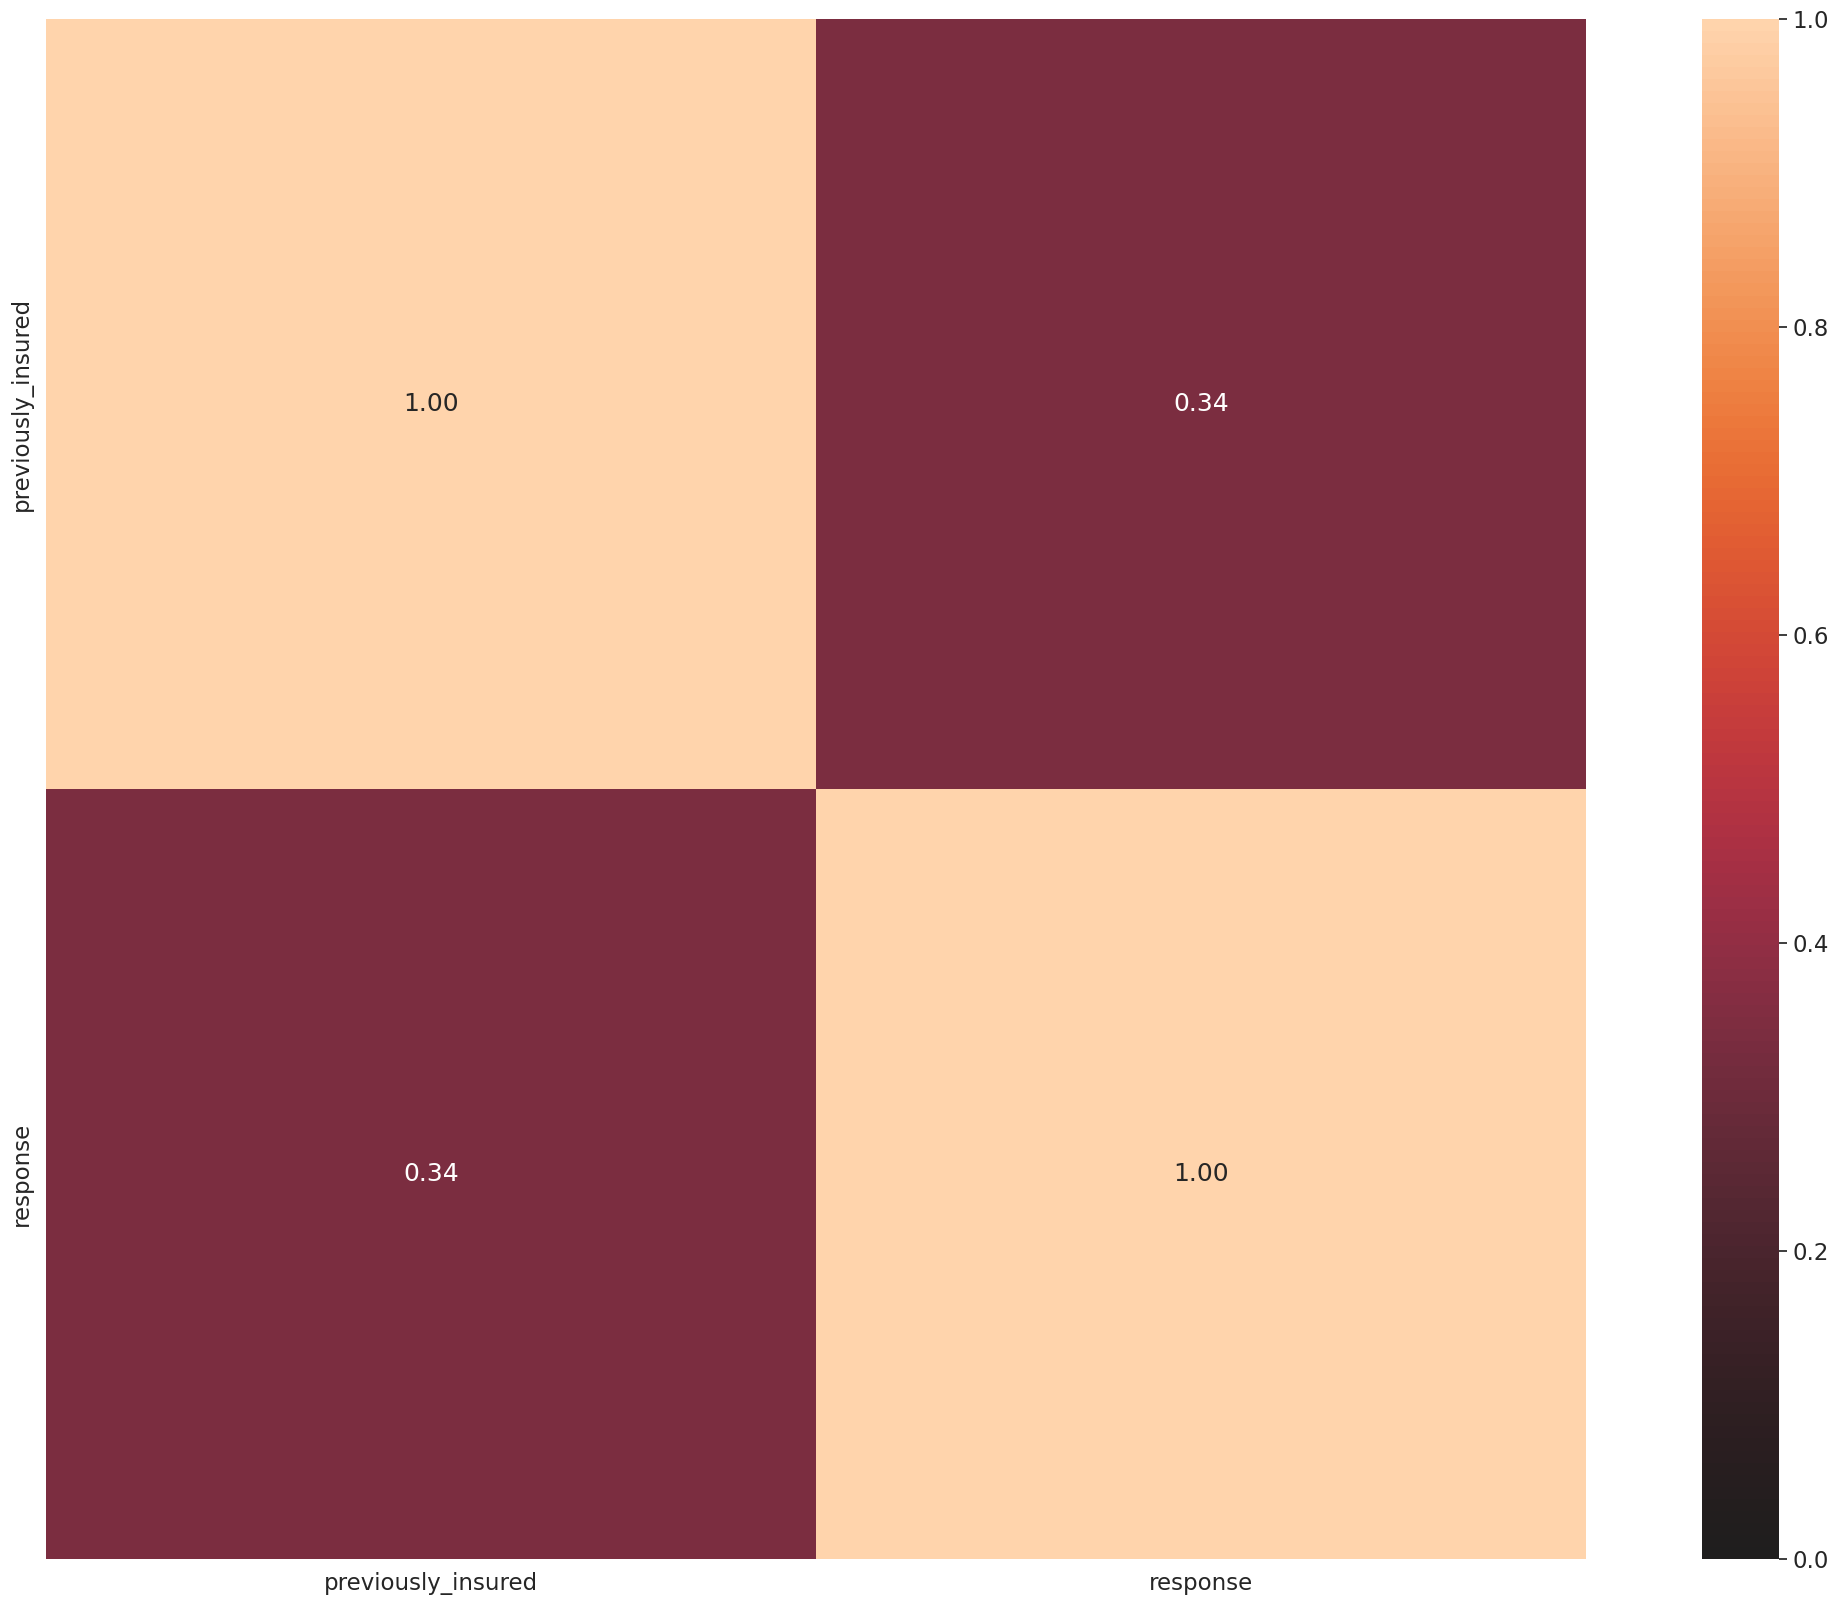

response            Interested  Not Interested     All
previously_insured                                    
No                       46552          159929  206481
Yes                        158          174470  174628
All                      46710          334399  381109
The P-Value of the ChiSq Test is: 0.0


response            Interested  Not Interested
previously_insured                            
No                        0.23            0.77
Yes                       0.00            1.00

In [36]:
df3_aux1 = pd.crosstab(index=df3['previously_insured'], columns=df3['response'], normalize='index' )
df3_aux2 = pd.crosstab(index=df3['previously_insured'], columns=df3['response'],margins=True)
chisquared_test = chi2_contingency(df3_aux2)
sns.barplot(y='Interested',x='previously_insured', data=df3_aux1.reset_index() [ ['previously_insured','Interested'] ]  );
nominal.associations(df3[ ['previously_insured','response'] ] )
print(df3_aux2)
print('The P-Value of the ChiSq Test is:', chisquared_test[1] )
df3_aux1

False. Proportion of customers who already has a car insurance and are interested in getting another one is almost zero and ones without car insurance is 23%. Chi-squared test rejects null hypothesis of independence. Correlation is moderate

In [37]:
tab = [['Hipothesis','Conclusion','Relevancy'],
      ['H1','False','Weak'],
      ['H2','False','Weak'],
       ['H4','True','Weak'],
       ['H6','False','Weak'],
       ['H7','False','Weak'],
       ['H8','False','Moderate'],
       ['H9','False','Moderate'] ]
print(tabulate(tab,headers='firstrow') )



Hipothesis    Conclusion    Relevancy
------------  ------------  -----------
H1            False         Weak
H2            False         Weak
H4            True          Weak
H6            False         Weak
H7            False         Weak
H8            False         Moderate
H9            False         Moderate


## Multivariate analysis

/home/dbcordeiro/anaconda3/envs/insurance_cross-sell/lib/python3.10/site-packages/dython/nominal.py:289: RuntimeWarning: Rounded eta = 1.000000000000001 to 1. This is probably due to floating point precision issues.
  warnings.warn(


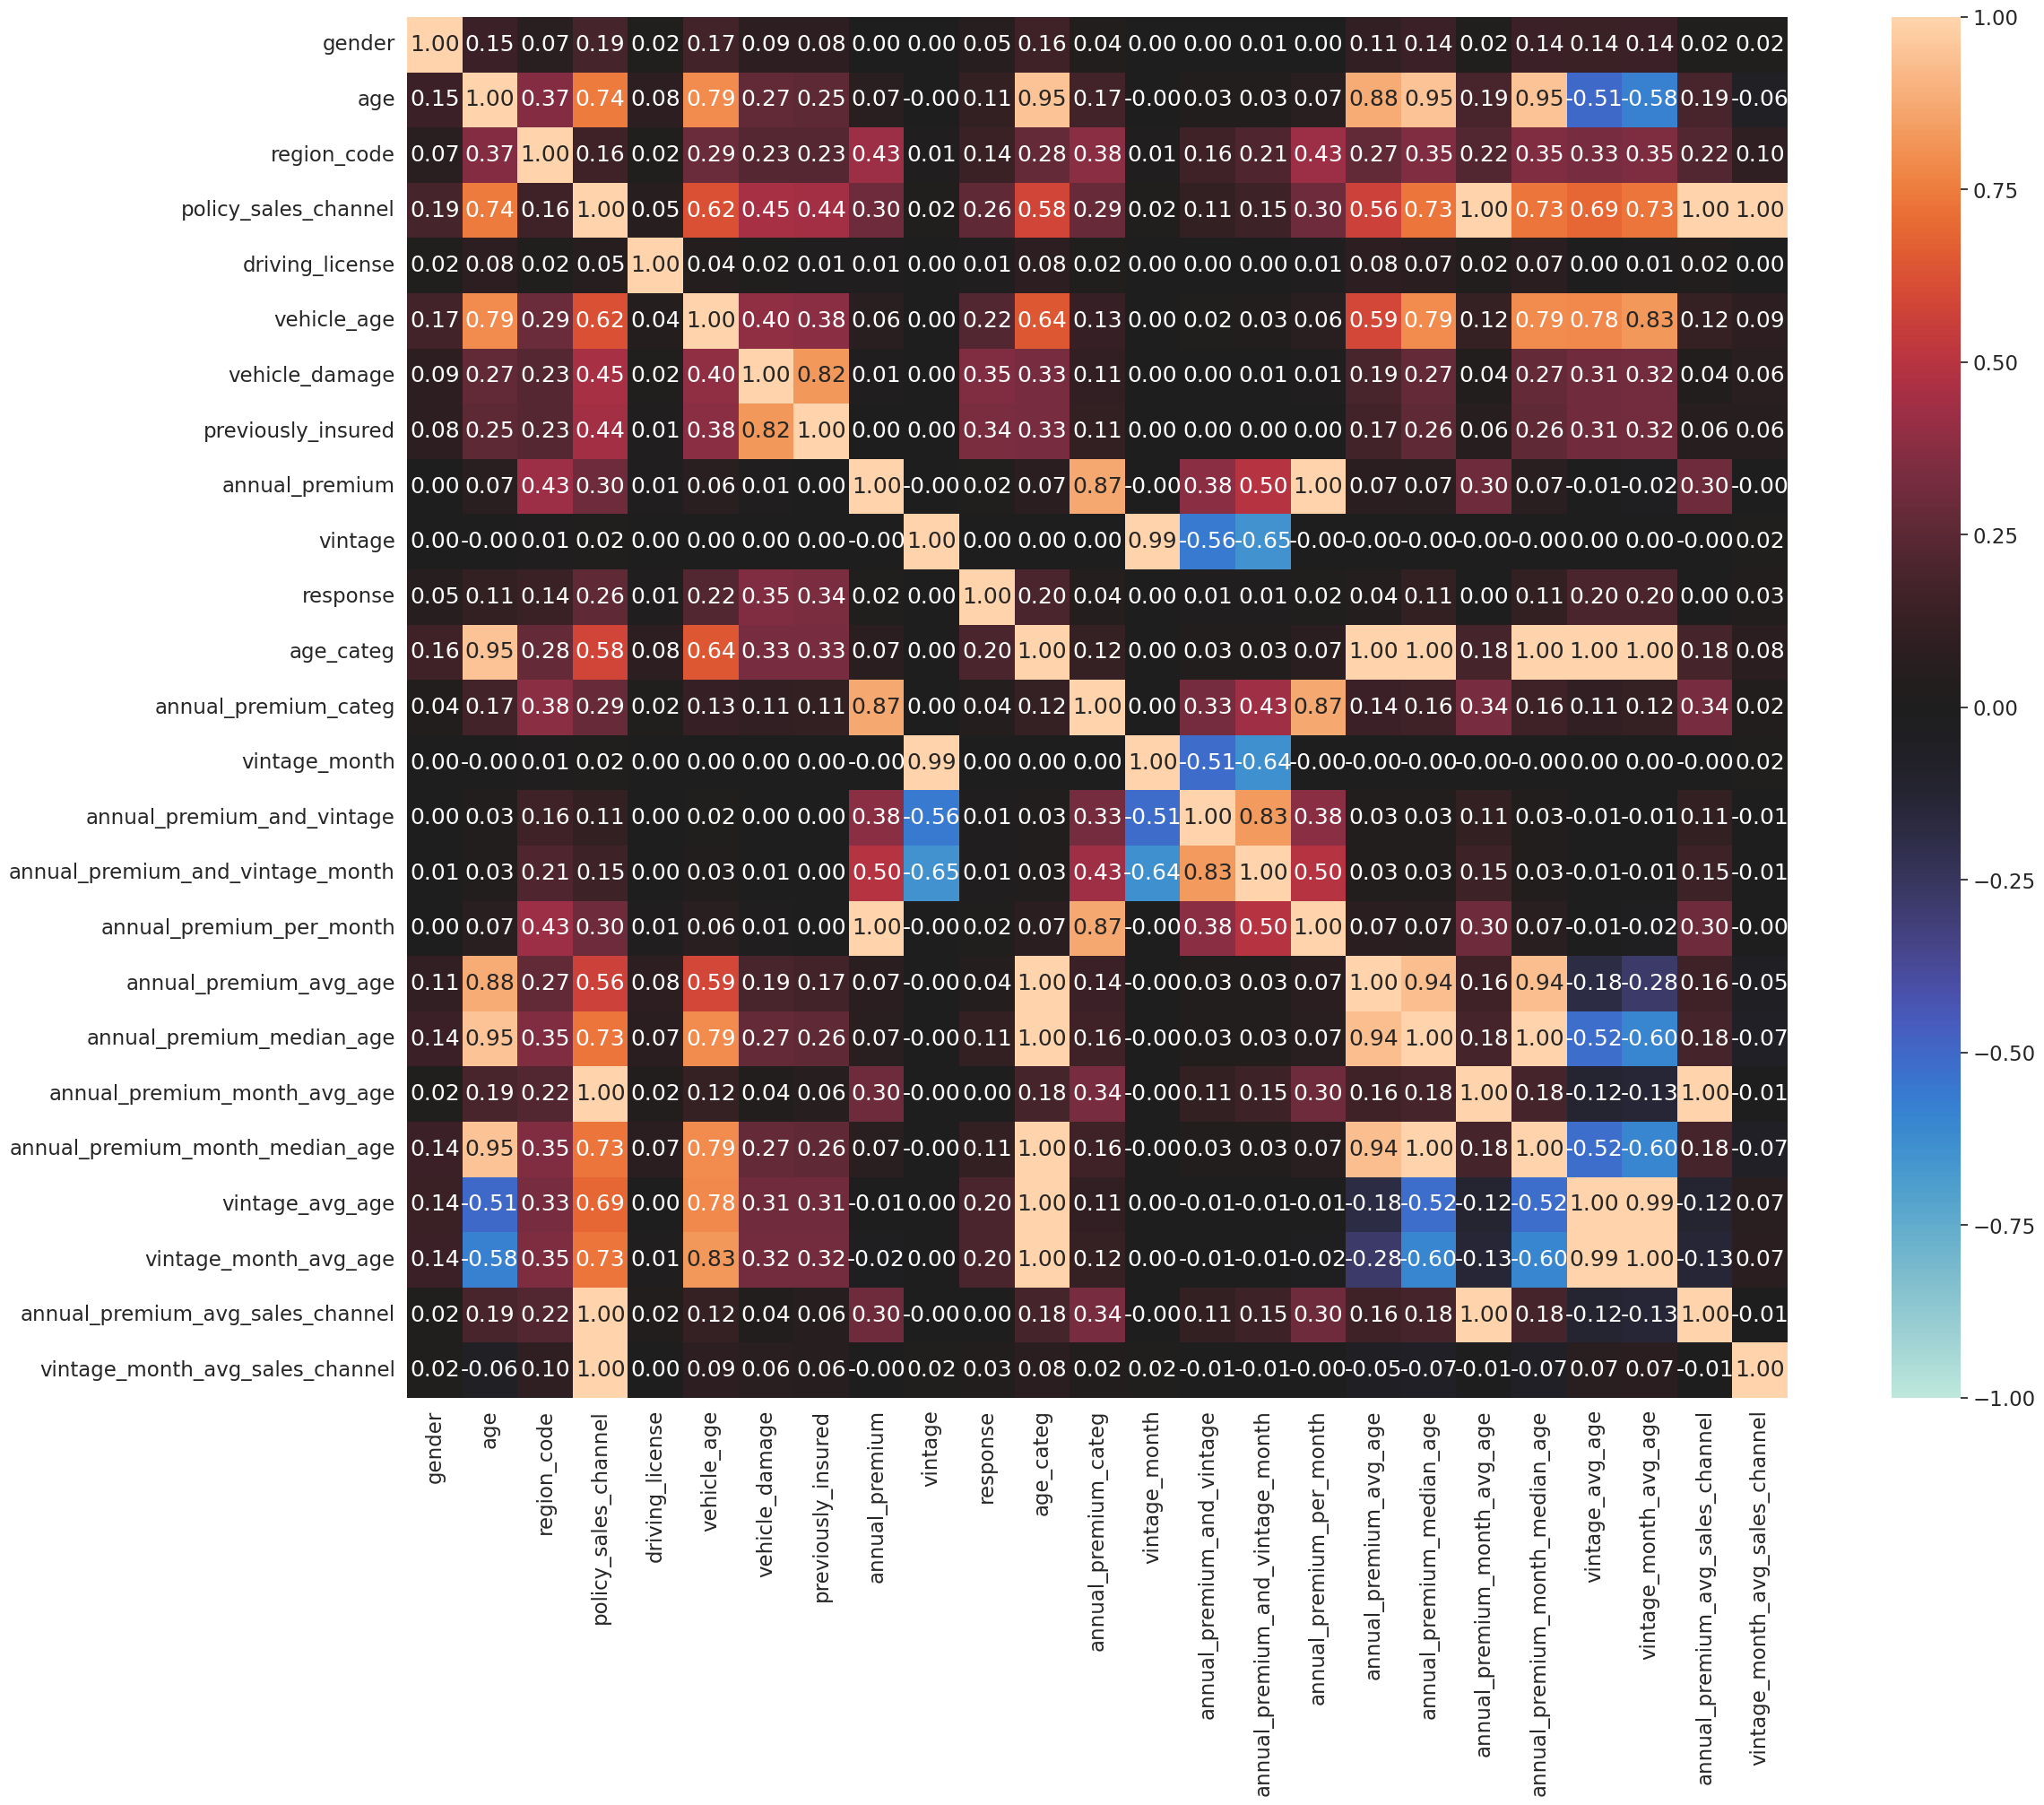

In [38]:
nominal.associations(df3.drop('id',axis = 1) );

# Data Preparation

In [8]:
df4 = df3.copy()
le = LabelEncoder()
df4['region_code'] = le.fit_transform(df4['region_code'])
df4['policy_sales_channel'] = le.fit_transform(df4['policy_sales_channel'])
predictors = df4.drop('response', axis=1)
response = df4['response']

## Split dataframe into training and test dataset

In [9]:
X_train, X_validation, y_train,y_validation = train_test_split(predictors, response, random_state=42,
                                                               stratify=response)
df4 = pd.concat([X_train, y_train], axis=1)

## Transformation

### Rescaling

In [10]:
rs = RobustScaler()
mms = MinMaxScaler()
df4['vintage'] = mms.fit_transform(df4[['vintage']].values)
pickle.dump(mms,open('../src/features/vintage_scaler.pkl', 'wb') )

df4['annual_premium'] = rs.fit_transform(df4[['annual_premium']].values)
pickle.dump(rs,open('../src/features//annual_premium_scaler.pkl', 'wb') )

df4['vintage_month'] = mms.fit_transform(df4[['vintage_month']].values)
pickle.dump(mms,open('../src/features/vintage_month_scaler.pkl', 'wb') )

df4['annual_premium_per_month'] = mms.fit_transform(df4[['annual_premium_per_month']].values)
pickle.dump(mms,open('../src/features/annual_premium_per_month_scaler.pkl', 'wb') )

df4['annual_premium_and_vintage'] = mms.fit_transform(df4[['annual_premium_and_vintage']].values)
pickle.dump(mms,open('../src/features/annual_premium_and_vintage_scaler.pkl', 'wb') )

df4['age'] = mms.fit_transform(df4[['age']].values)
pickle.dump(mms,open('../src/features/age.pkl', 'wb') )

### Encoding

In [11]:
#response - label encoder
y_train = pd.Series(le.fit_transform(y_train), index=y_train.index).apply(lambda x: 1 if x == 0 else 0)

#Gender, previously_insured,vehicle_damage,driver_license - one hot encoding
transformer = make_column_transformer(
    (OneHotEncoder(), ['gender', 'previously_insured','vehicle_damage','driving_license']),
    remainder='drop')
transformed = transformer.fit_transform(df4)
pickle.dump(transformer,open('../src/features/one_hot_encoding_scaler.pkl', 'wb') )

transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out(), index=df4.index)
df4 = pd.concat([df4,transformed_df],axis=1).drop(['gender', 'previously_insured','vehicle_damage','driving_license'], axis=1)


#Age,vehicle_age and annual_premium - ordinal encoding
age_categories = {'< 35':1,'between 35 and 55':2,'> 55':3}
vehicle_age_categories = {'< 1 Year':1,'1-2 Year':2, '> 2 Years':3}
annual_premium_categories = {'< 20,000':1,'between 20,000 and 40,000':2, '> 40,000':3}
df4['age_categ'] = df4['age_categ'].map(age_categories)
df4['vehicle_age'] = df4['vehicle_age'].map(vehicle_age_categories)
df4['annual_premium_categ'] = df4['annual_premium_categ'].map(annual_premium_categories)

## Validation Preparation

In [12]:
#Response
y_validation = pd.Series(le.transform(y_validation), index=y_validation.index).apply(lambda x: 1 if x == 0 else 0)

#Gender, previously_insured,vehicle_damage,driver_license - one hot encoding
transformed = transformer.transform(X_validation)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out(), index=X_validation.index)
X_validation = pd.concat([X_validation,transformed_df],axis=1).drop(['gender', 'previously_insured','vehicle_damage','driving_license'], axis=1)

#Transformation
X_validation['vintage'] = mms.transform(X_validation[['vintage']].values)
X_validation['annual_premium'] = rs.transform(X_validation[['annual_premium']].values)
X_validation['vintage_month'] = mms.transform(X_validation[['vintage_month']].values)
X_validation['annual_premium_per_month'] = mms.transform(X_validation[['annual_premium_per_month']].values)
X_validation['annual_premium_and_vintage'] = mms.transform(X_validation[['annual_premium_and_vintage']].values)
X_validation['annual_premium_and_vintage_month'] = mms.transform(X_validation[['annual_premium_and_vintage_month']].values)
X_validation['age'] = mms.transform(X_validation[['age']].values)

#Age,vehicle_age and annual_premium - ordinal encoding
X_validation['age_categ'] = X_validation['age_categ'].map(age_categories)
X_validation['vehicle_age'] = X_validation['vehicle_age'].map(vehicle_age_categories)
X_validation['annual_premium_categ'] = X_validation['annual_premium_categ'].map(annual_premium_categories)


# Feature Selection

In [13]:
df5 = df4.copy()
X_train = df5.drop(['id','response'],axis=1)
X_validation = X_validation.drop('id',axis=1)

## Feature importance in a random forest

feature  importance
27             annual_premium_and_vintage        0.13
26                                vintage        0.12
25       annual_premium_and_vintage_month        0.10
24                                    age        0.10
23               annual_premium_per_month        0.10
22                         annual_premium        0.10
21                            region_code        0.08
20      onehotencoder__vehicle_damage_Yes        0.04
19       onehotencoder__vehicle_damage_No        0.04
18                          vintage_month        0.03
17  onehotencoder__previously_insured_Yes        0.03
16   onehotencoder__previously_insured_No        0.02
15        vintage_month_avg_sales_channel        0.02
14                            vehicle_age        0.02
13           annual_premium_month_avg_age        0.02
12       annual_premium_avg_sales_channel        0.02
11                   policy_sales_channel        0.01
10             onehotencoder__gender_Male        0.01
9            onehotencoder__gender_Female        0.01
8                   vintage_month_avg_age        0.01
7                    annual_premium_categ        0.00
6                         vintage_avg_age        0.00
5               annual_premium_median_age        0.00
4                  annual_premium_avg_age        0.00
3         annual_premium_month_median_age        0.00
2                               age_categ        0.00
1      onehotencoder__driving_license_Yes        0.00
0       onehotencoder__driving_license_No        0.00

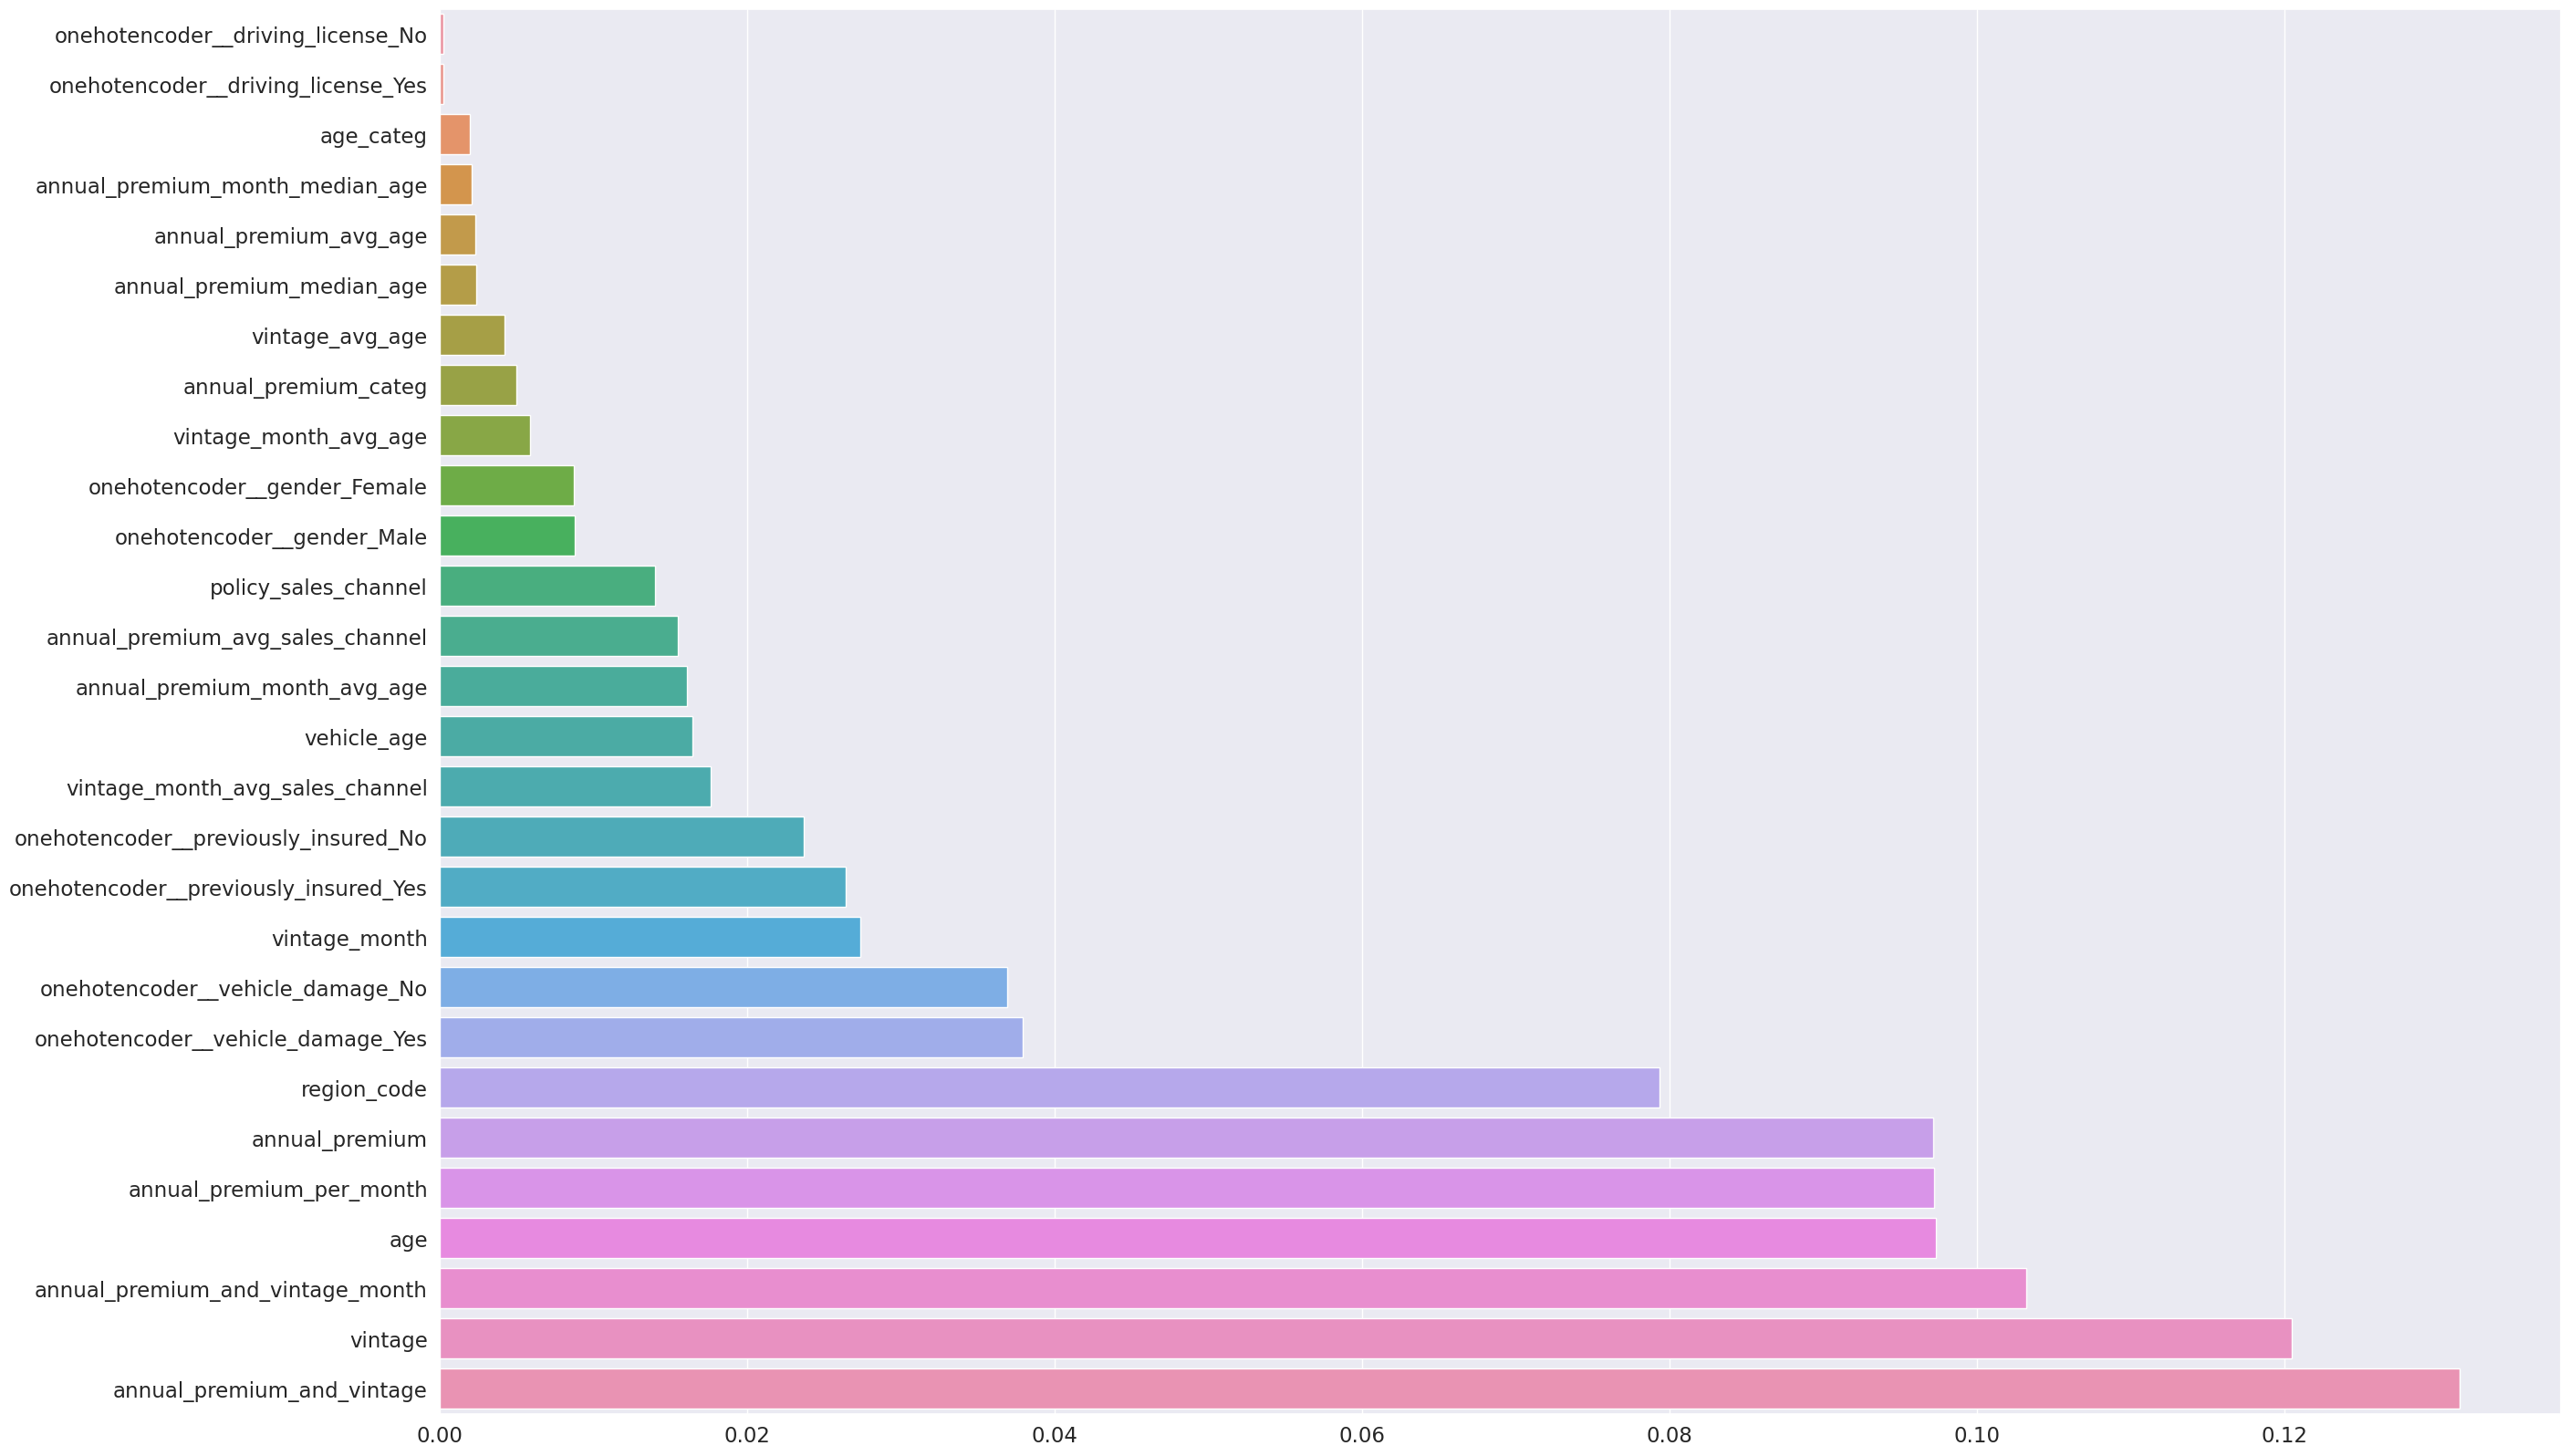

In [14]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500).fit(X_train, y_train)
feature_importance_sorted = rf.feature_importances_.argsort()
sns.barplot(y=rf.feature_names_in_[feature_importance_sorted], x=rf.feature_importances_[feature_importance_sorted] );
df_feature_importance_rf = pd.DataFrame( {'feature':rf.feature_names_in_[feature_importance_sorted], 'importance': rf.feature_importances_[feature_importance_sorted] } )
df_feature_importance_rf.sort_values(by='importance', ascending=False)

## Feature importance in a XGBoost

feature  importance
27       onehotencoder__vehicle_damage_No        0.51
26   onehotencoder__previously_insured_No        0.45
25                                    age        0.01
24      onehotencoder__driving_license_No        0.00
23                            vehicle_age        0.00
22        vintage_month_avg_sales_channel        0.00
21           annual_premium_month_avg_age        0.00
20                   policy_sales_channel        0.00
19                            region_code        0.00
18                         annual_premium        0.00
17       annual_premium_and_vintage_month        0.00
16             annual_premium_and_vintage        0.00
15           onehotencoder__gender_Female        0.00
14                        vintage_avg_age        0.00
13                                vintage        0.00
1       onehotencoder__vehicle_damage_Yes        0.00
12                              age_categ        0.00
11                   annual_premium_categ        0.00
10                          vintage_month        0.00
9      onehotencoder__driving_license_Yes        0.00
8                annual_premium_per_month        0.00
7                  annual_premium_avg_age        0.00
6         annual_premium_month_median_age        0.00
5                   vintage_month_avg_age        0.00
4        annual_premium_avg_sales_channel        0.00
3              onehotencoder__gender_Male        0.00
2   onehotencoder__previously_insured_Yes        0.00
0               annual_premium_median_age        0.00

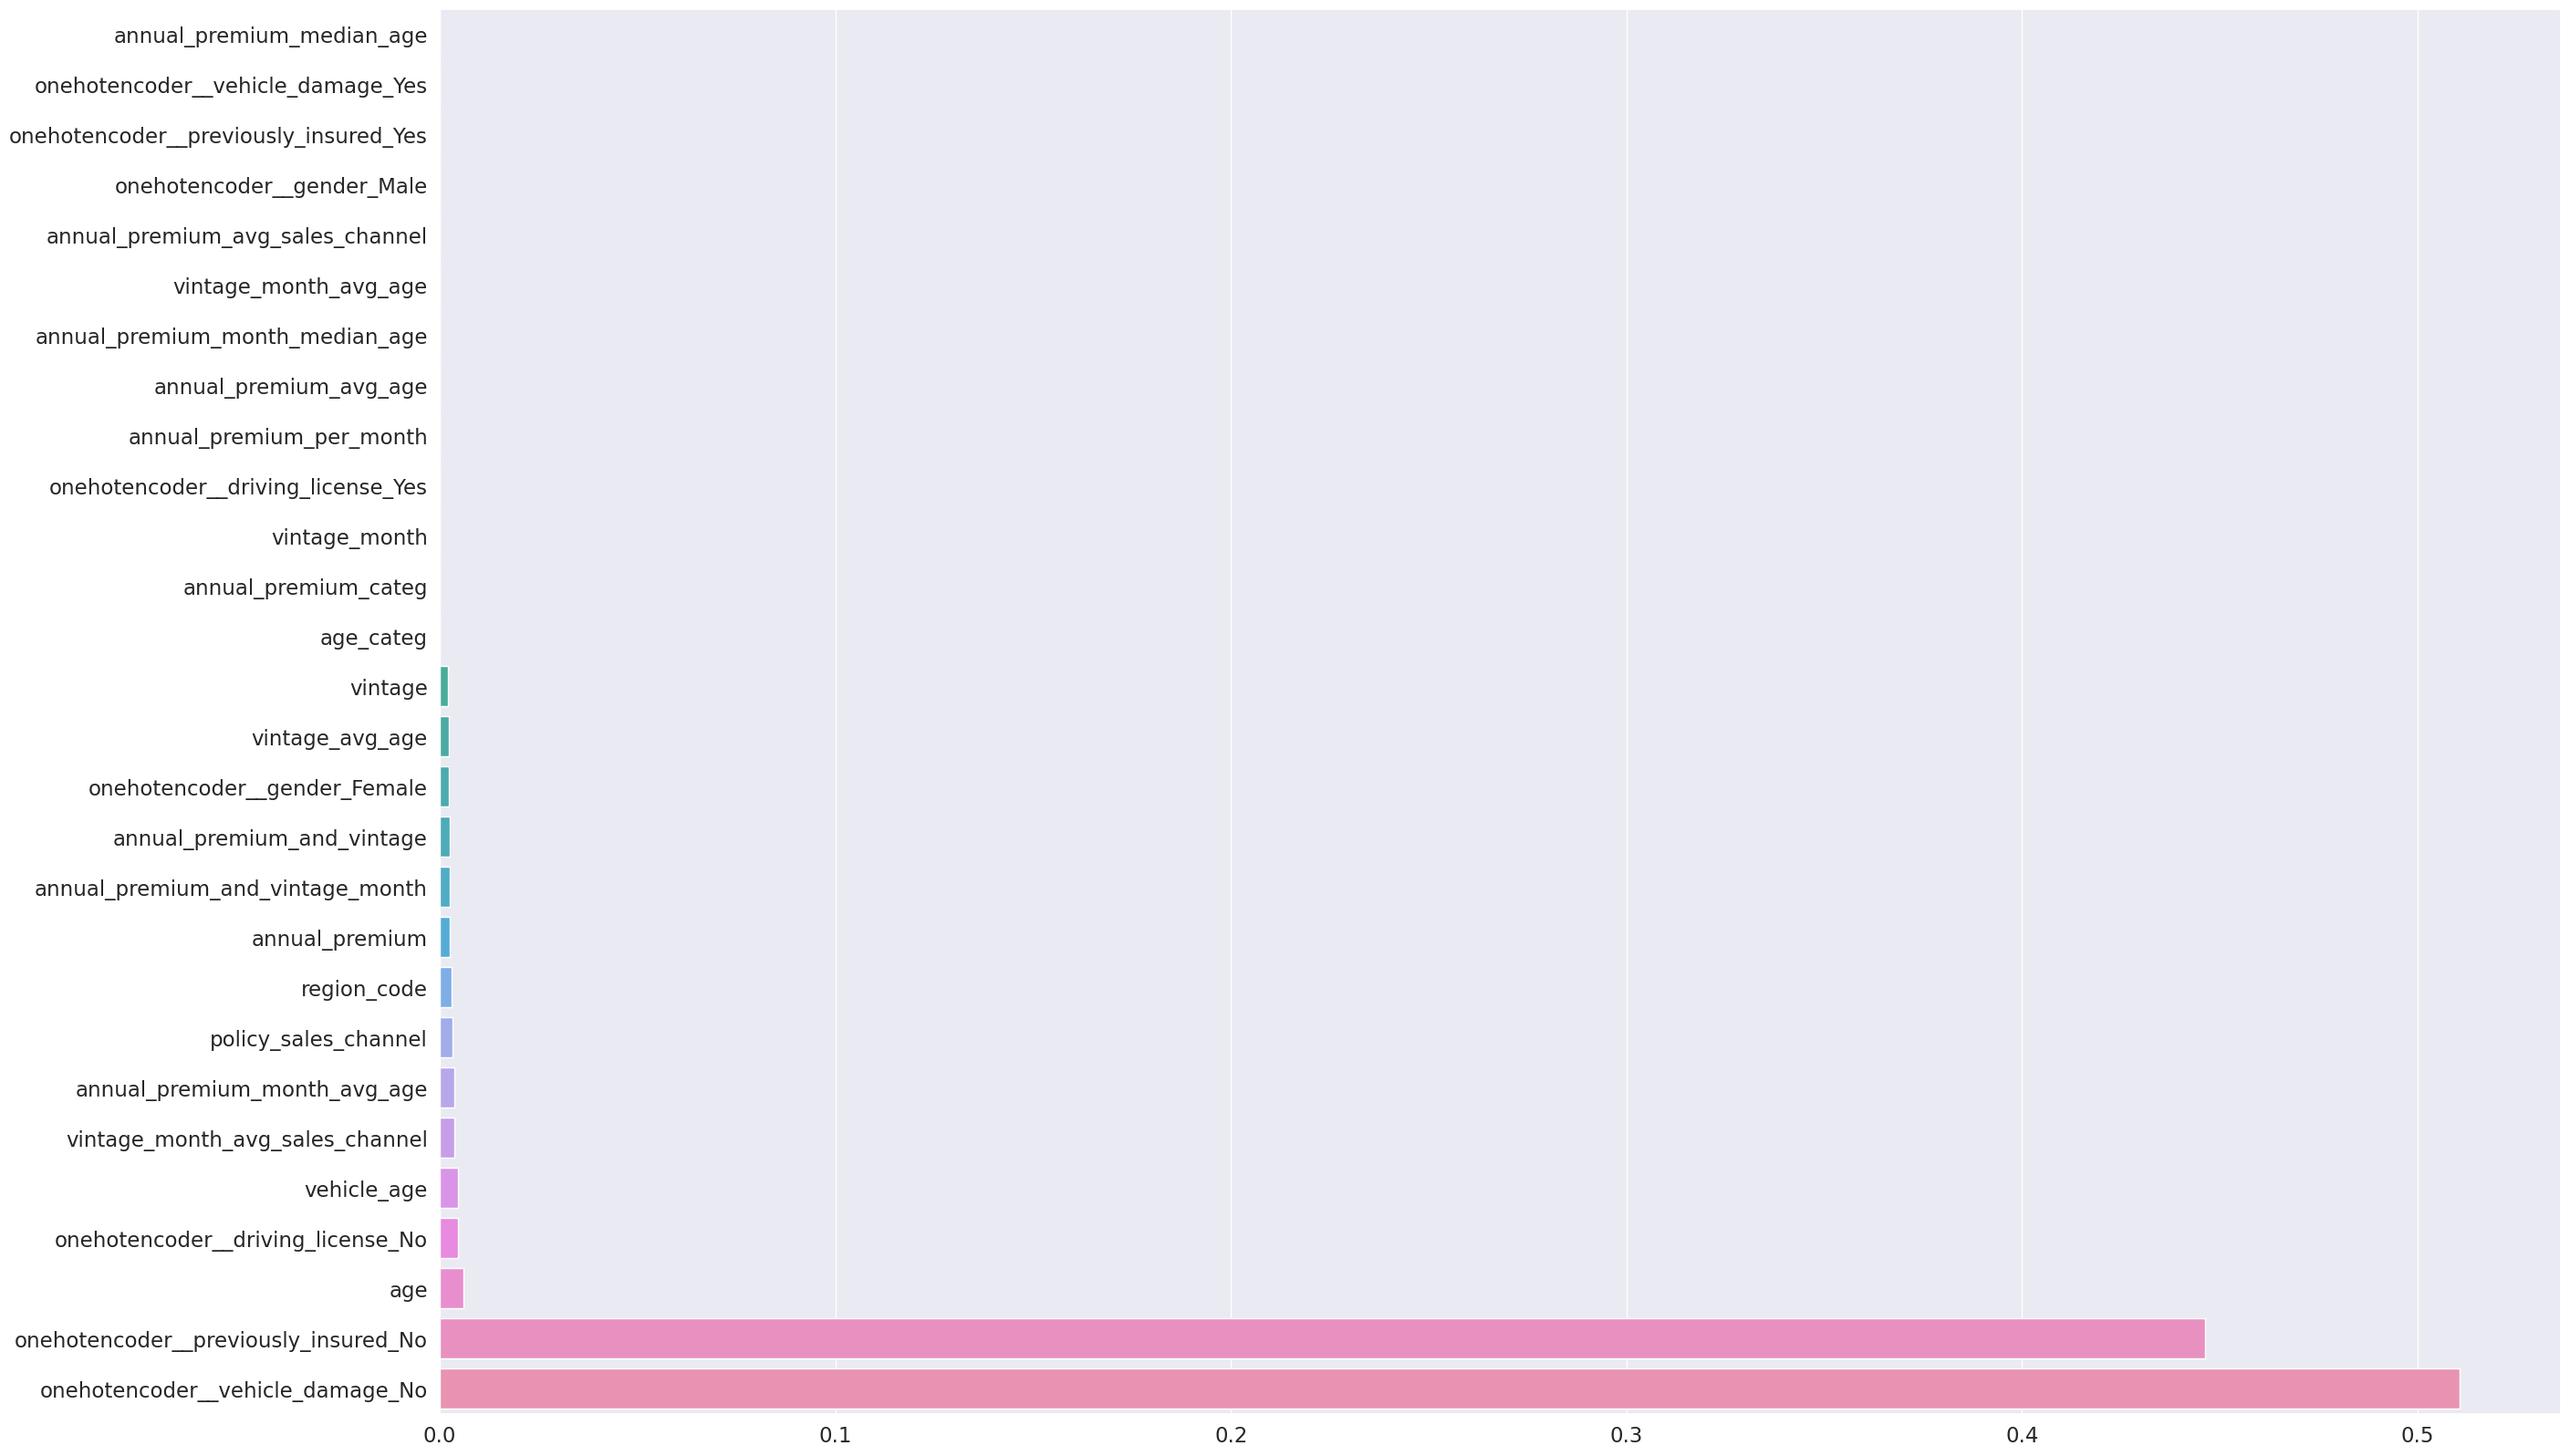

In [ ]:
xgbc = XGBClassifier(objective='binary:logistic',random_state=42, n_jobs=-1, n_estimators=500).fit(X_train, y_train)
feature_importance_sorted = xgbc.feature_importances_.argsort()
sns.barplot(y=xgbc.feature_names_in_[feature_importance_sorted], x=xgbc.feature_importances_[feature_importance_sorted] );
df_feature_importance_xgbc = pd.DataFrame( {'feature':xgbc.feature_names_in_[feature_importance_sorted], 'importance': xgbc.feature_importances_[feature_importance_sorted] } )
df_feature_importance_xgbc.sort_values(by='importance', ascending=False)

## Feature importance using permutation with XGBoost and Random Forest

In [ ]:
columns_names = [X_validation.columns[i] for i in range(0,len(X_validation.columns) )]
rf= RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=500).fit(X_train, y_train)
xgbc= XGBClassifier(objective='binary:logistic',random_state=42,n_jobs=-1,n_estimators=500).fit(X_train, y_train)

In [ ]:
permutation_feature_rf = permutation_importance(rf, X_validation, y_validation, n_repeats=30, random_state=42,
                                        scoring={'lift':lift_scorer,'recall': 'recall'})

In [ ]:
permutation_feature_xgbc = permutation_importance(xgbc, X_validation, y_validation, n_repeats=30, random_state=42,
                                 scoring={'lift':lift_scorer,'recall': 'recall'})

In [ ]:
importance_rf = pd.DataFrame({'features':columns_names,'lift':permutation_feature_rf['lift']['importances_mean'], 
        'recall':permutation_feature_rf['recall']['importances_mean']} ).sort_values(by='lift', ascending=False)
importance_rf

In [ ]:
importance_xgbc = pd.DataFrame({'features':columns_names,'lift':permutation_feature_xgbc['lift']['importances_mean'], 
        'recall':permutation_feature_xgbc['recall']['importances_mean']} ).sort_values(by='lift', ascending=False)
importance_xgbc

In [14]:
cols_selected = ['age','vehicle_age','annual_premium_and_vintage',
                 'onehotencoder__vehicle_damage_Yes','onehotencoder__vehicle_damage_No',
                 'policy_sales_channel','region_code', 'annual_premium','vintage']
x_train = X_train[cols_selected]
x_val = X_validation[cols_selected]

# Machine Learning Modelling

### Categorical Naive Bayes

/home/dbcordeiro/anaconda3/envs/insurance_cross-sell/lib/python3.10/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:275: RuntimeWarning: invalid value encountered in divide
  normalised = finals/finals.sum(axis=1, keepdims=True)


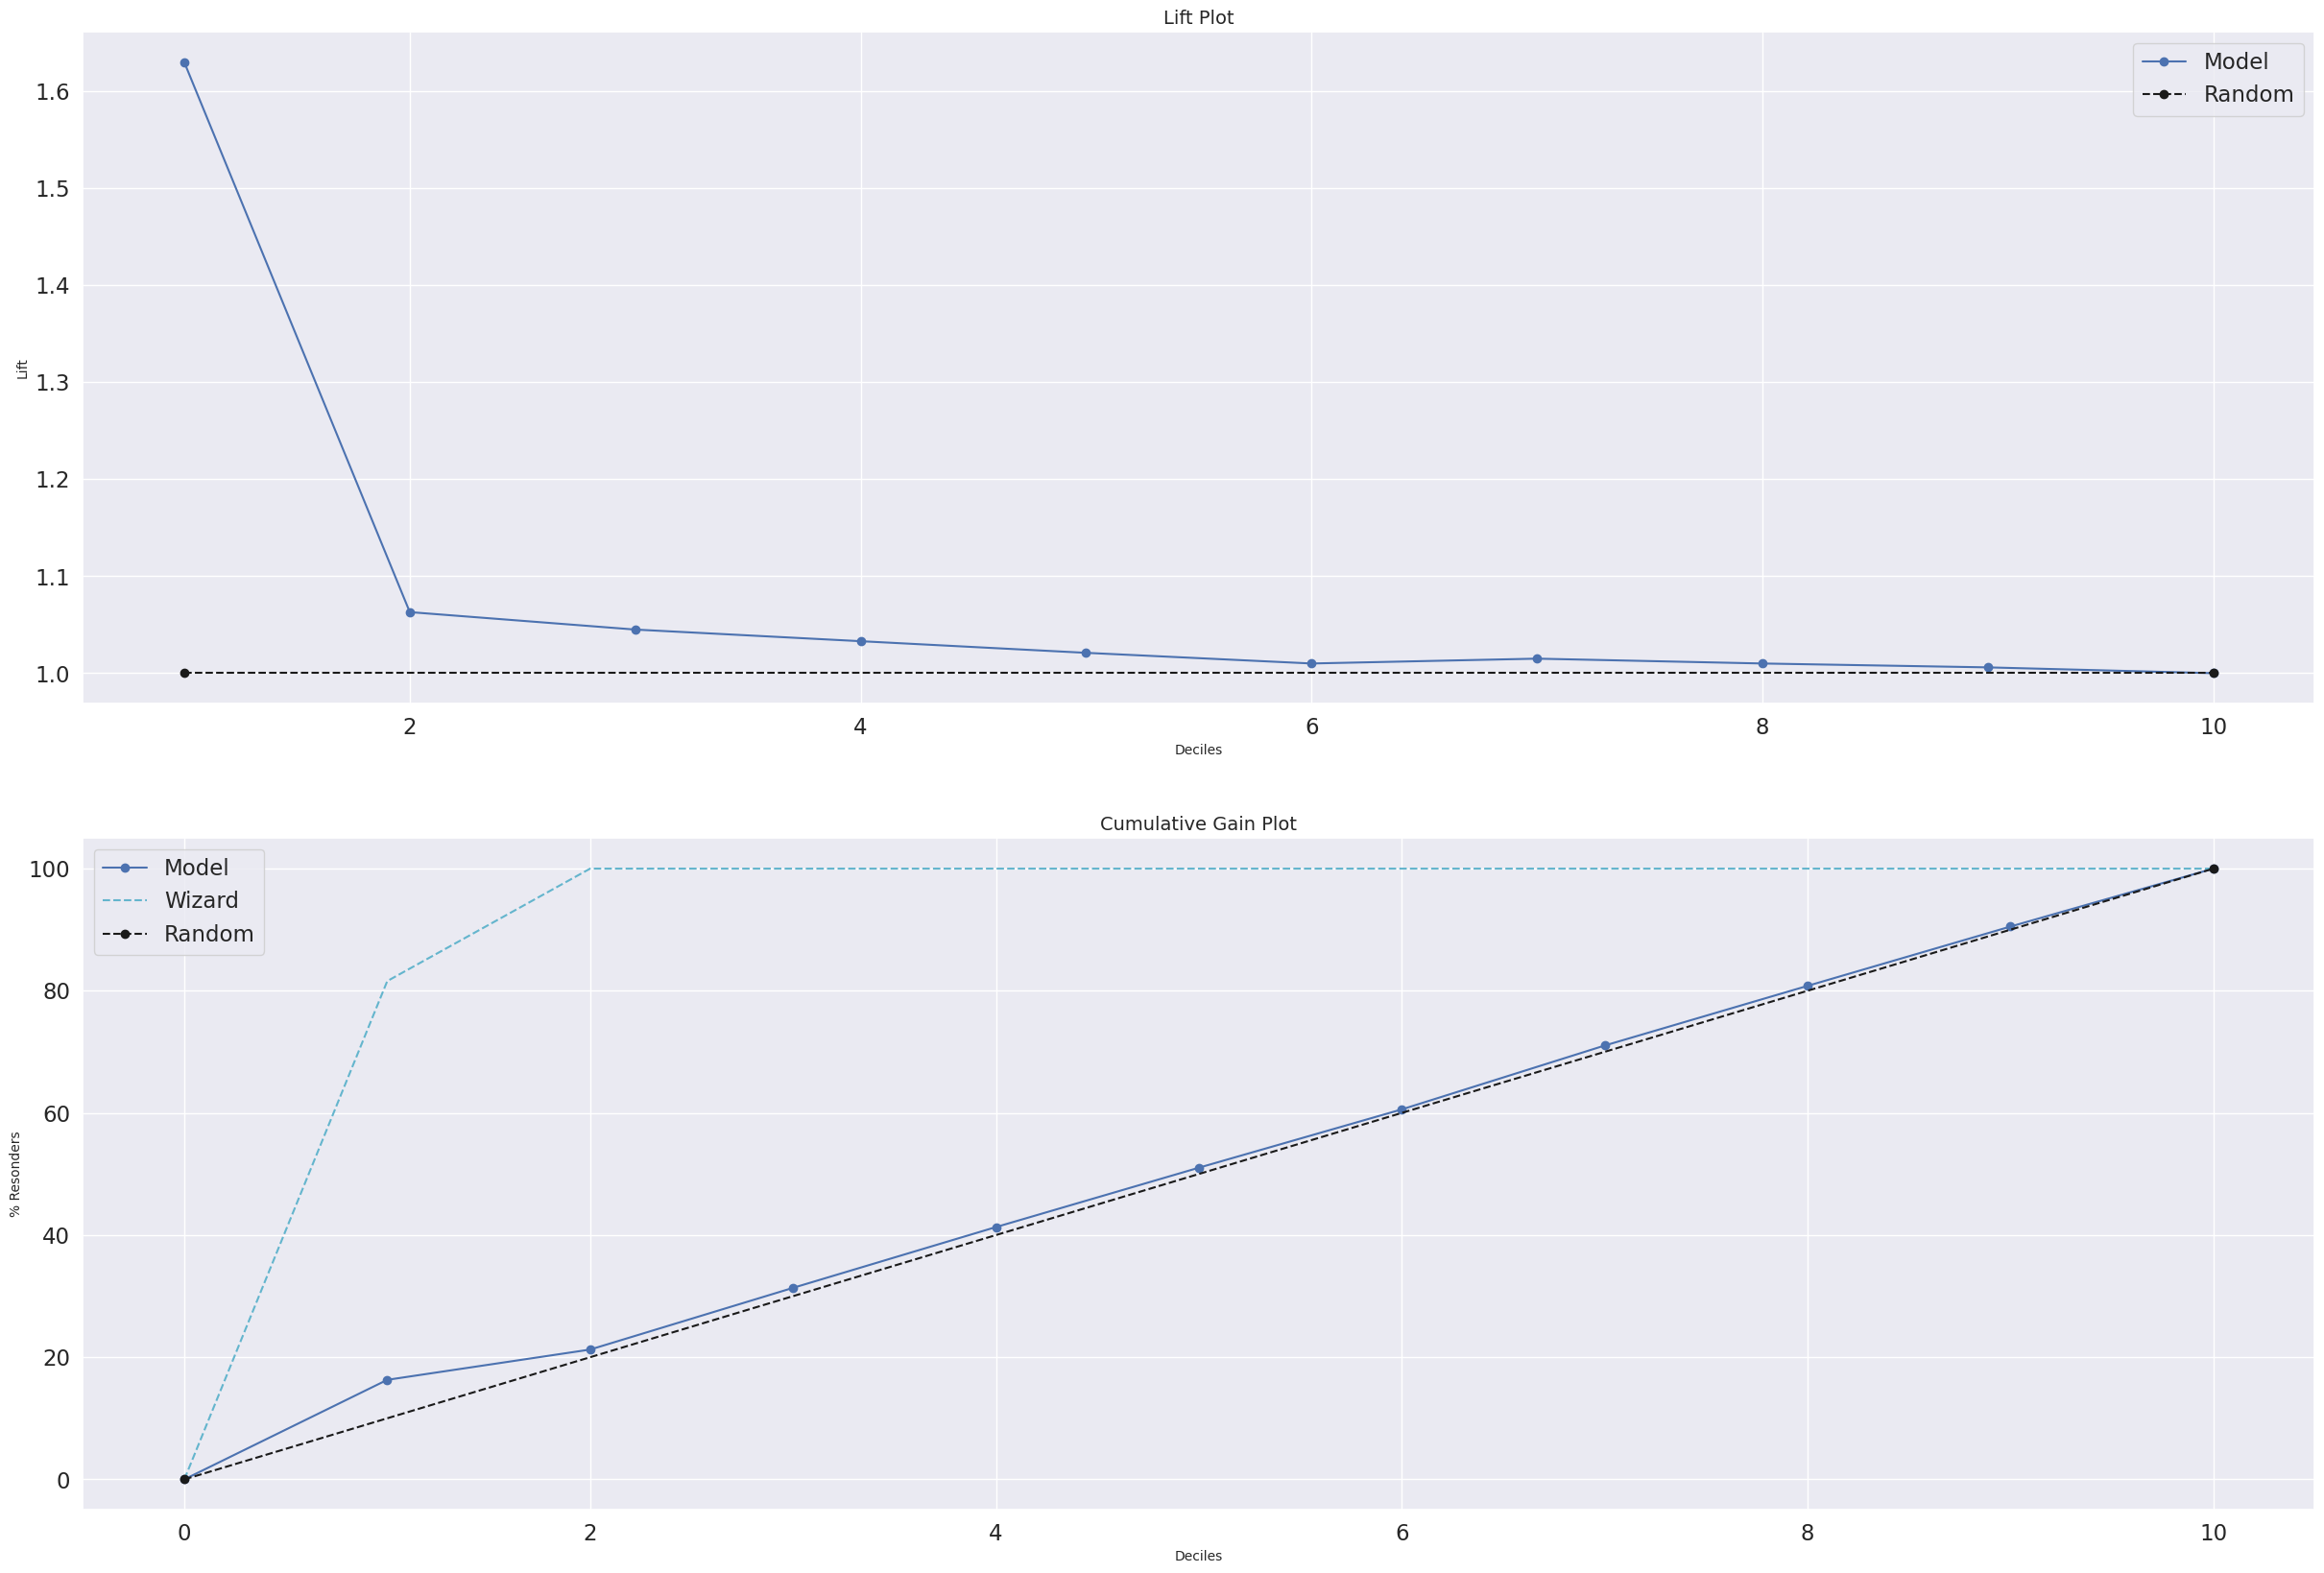

In [25]:
naive_bayes = MixedNB().fit(x_train, y_train)
y_predicted_proba_bayes = naive_bayes.predict_proba(x_val)
y_predicted_bayes = naive_bayes.predict(x_val)
plt.subplot(2,1,1)
kds.metrics.plot_lift(y_validation,y_predicted_proba_bayes[:,1]);
plt.subplot(2,1,2)
kds.metrics.plot_cumulative_gain(y_validation,y_predicted_proba_bayes[:,1]);

#### Naive Bayes Cross-validation

In [32]:
lift_naive= lift_score(y_validation,y_predicted_bayes)

skf = StratifiedKFold(n_splits=10)
naive_bayes_cv_lift = []
for train_ix, test_ix in skf.split(x_train, y_train):
    X_train_cv, X_validation_cv = x_train.iloc[train_ix], x_train.iloc[test_ix]
    y_train_cv, y_validation_cv = y_train.iloc[train_ix], y_train.iloc[test_ix]
    naive_cv = MixedNB().fit(X_train_cv, y_train_cv)
    predictions = naive_cv.predict(X_validation_cv)
    naive_bayes_cv_lift.append( lift_score(y_validation_cv, predictions) )
    
naive_bayes_cv_mean_lift = np.mean(naive_bayes_cv_lift)
naive_bayes_cv_std_lift = np.std(naive_bayes_cv_lift )
    
naive_bayes_cv_result = pd.DataFrame({'model_name':'naive_bayes','lift_score':lift_naive,'lift_score_cv': naive_bayes_cv_mean_lift,
                      'std_lift_cv':naive_bayes_cv_std_lift}, index=[0]) 
display(naive_bayes_cv_result)

/home/dbcordeiro/anaconda3/envs/insurance_cross-sell/lib/python3.10/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:275: RuntimeWarning: invalid value encountered in divide
  normalised = finals/finals.sum(axis=1, keepdims=True)


model_name  lift_score  lift_score_cv  std_lift_cv
0  naive_bayes        1.76           2.20         0.01

### Random Forest Classifier

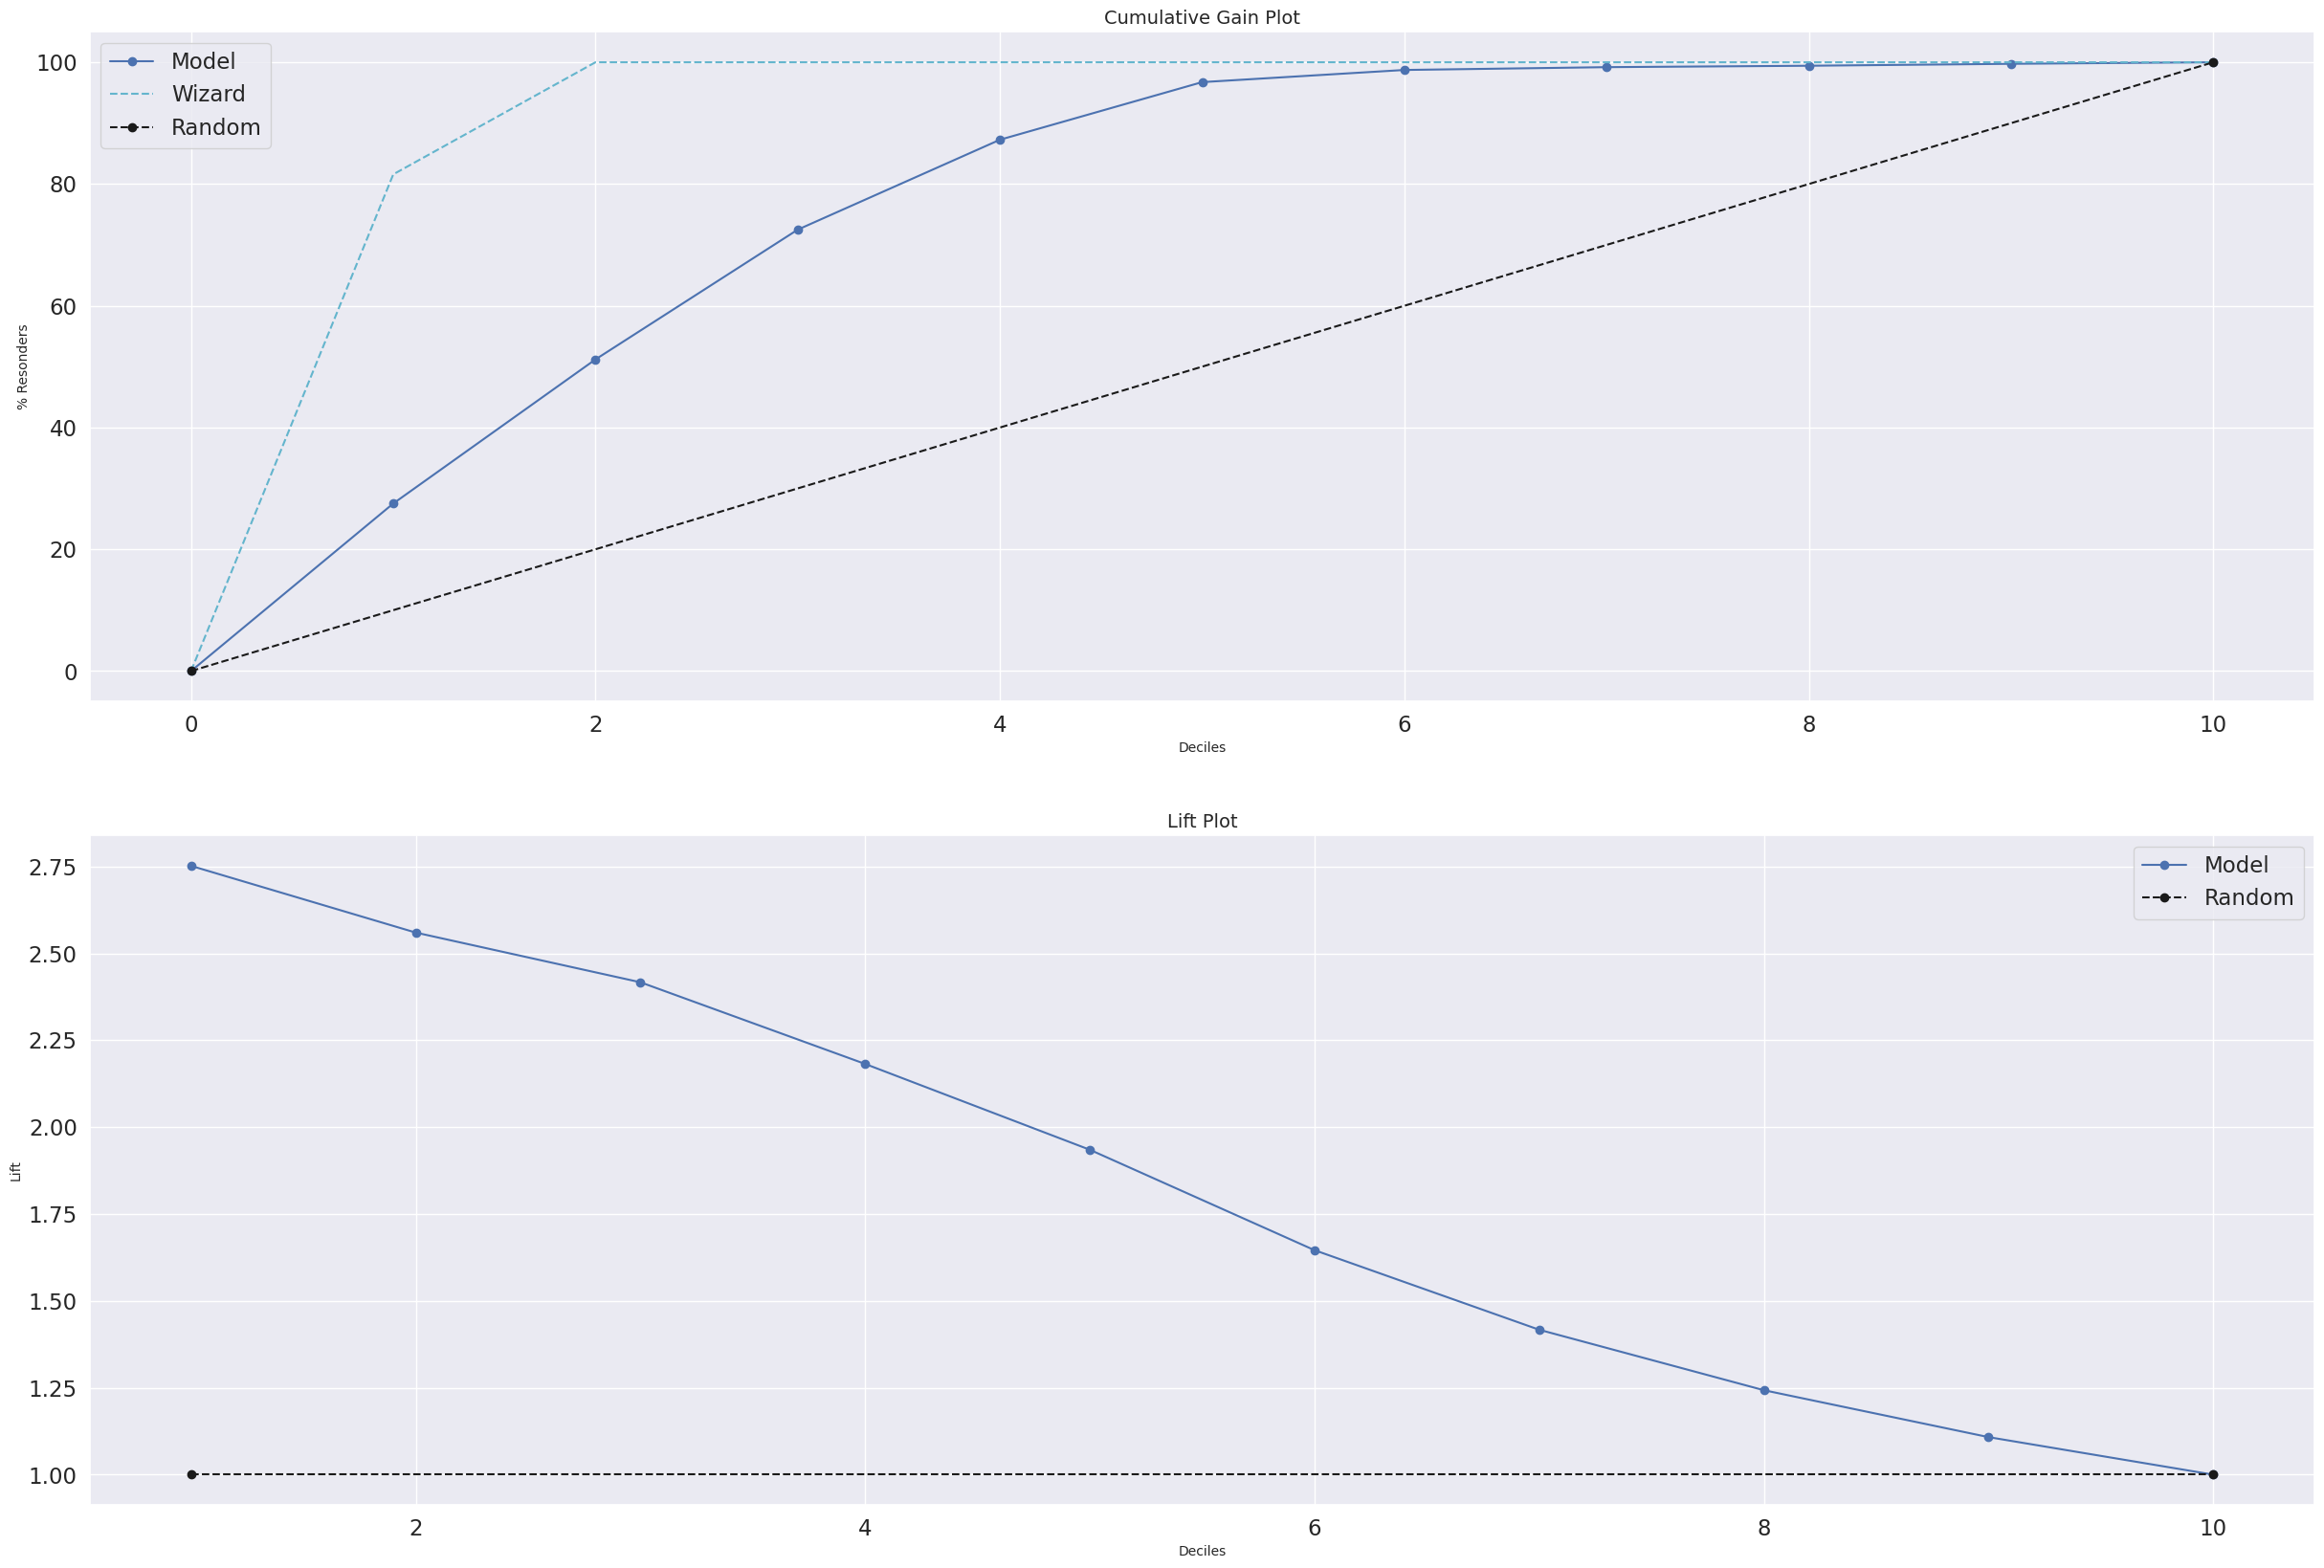

In [18]:
rf= RandomForestClassifier(random_state=42,n_jobs=-1, n_estimators=500).fit(x_train, y_train)
y_predicted_proba_rf = rf.predict_proba(x_val)
y_predicted_rf = rf.predict(x_val)
plt.subplot(2,1,1)
kds.metrics.plot_cumulative_gain(y_validation,y_predicted_proba_rf[:,1] );
plt.subplot(2,1,2)
kds.metrics.plot_lift(y_validation,y_predicted_proba_rf[:,1] );

#### Random Forest Cross-validation

In [26]:
lift_rf = lift_score(y_validation,y_predicted_rf)
skf = StratifiedKFold(n_splits=10)
rf_cv_lift = []
for train_ix, test_ix in skf.split(x_train, y_train):
    X_train_cv, X_validation_cv = x_train.iloc[train_ix], x_train.iloc[test_ix]
    y_train_cv, y_validation_cv = y_train.iloc[train_ix], y_train.iloc[test_ix]
    rf_cv = RandomForestClassifier(random_state=42,n_jobs=-1, n_estimators=300).fit(X_train_cv, y_train_cv)
    predictions = rf_cv.predict(X_validation_cv)
    rf_cv_lift.append( lift_score(y_validation_cv, predictions) )
    
rf_cv_mean_lift  = np.mean(rf_cv_lift )
rf_cv_std_lift  = np.std(rf_cv_lift )
    
rf_cv_result = pd.DataFrame({'model_name':'random_forest','lift_score':lift_rf ,'lift_score_cv': rf_cv_mean_lift,
                      'std_lift_cv':rf_cv_std_lift}, index=[0]) 
display(rf_cv_result)

model_name  lift_score  lift_score_cv  std_lift_cv
0  random_forest        3.13           2.86         0.07

### XGBoost Classifier

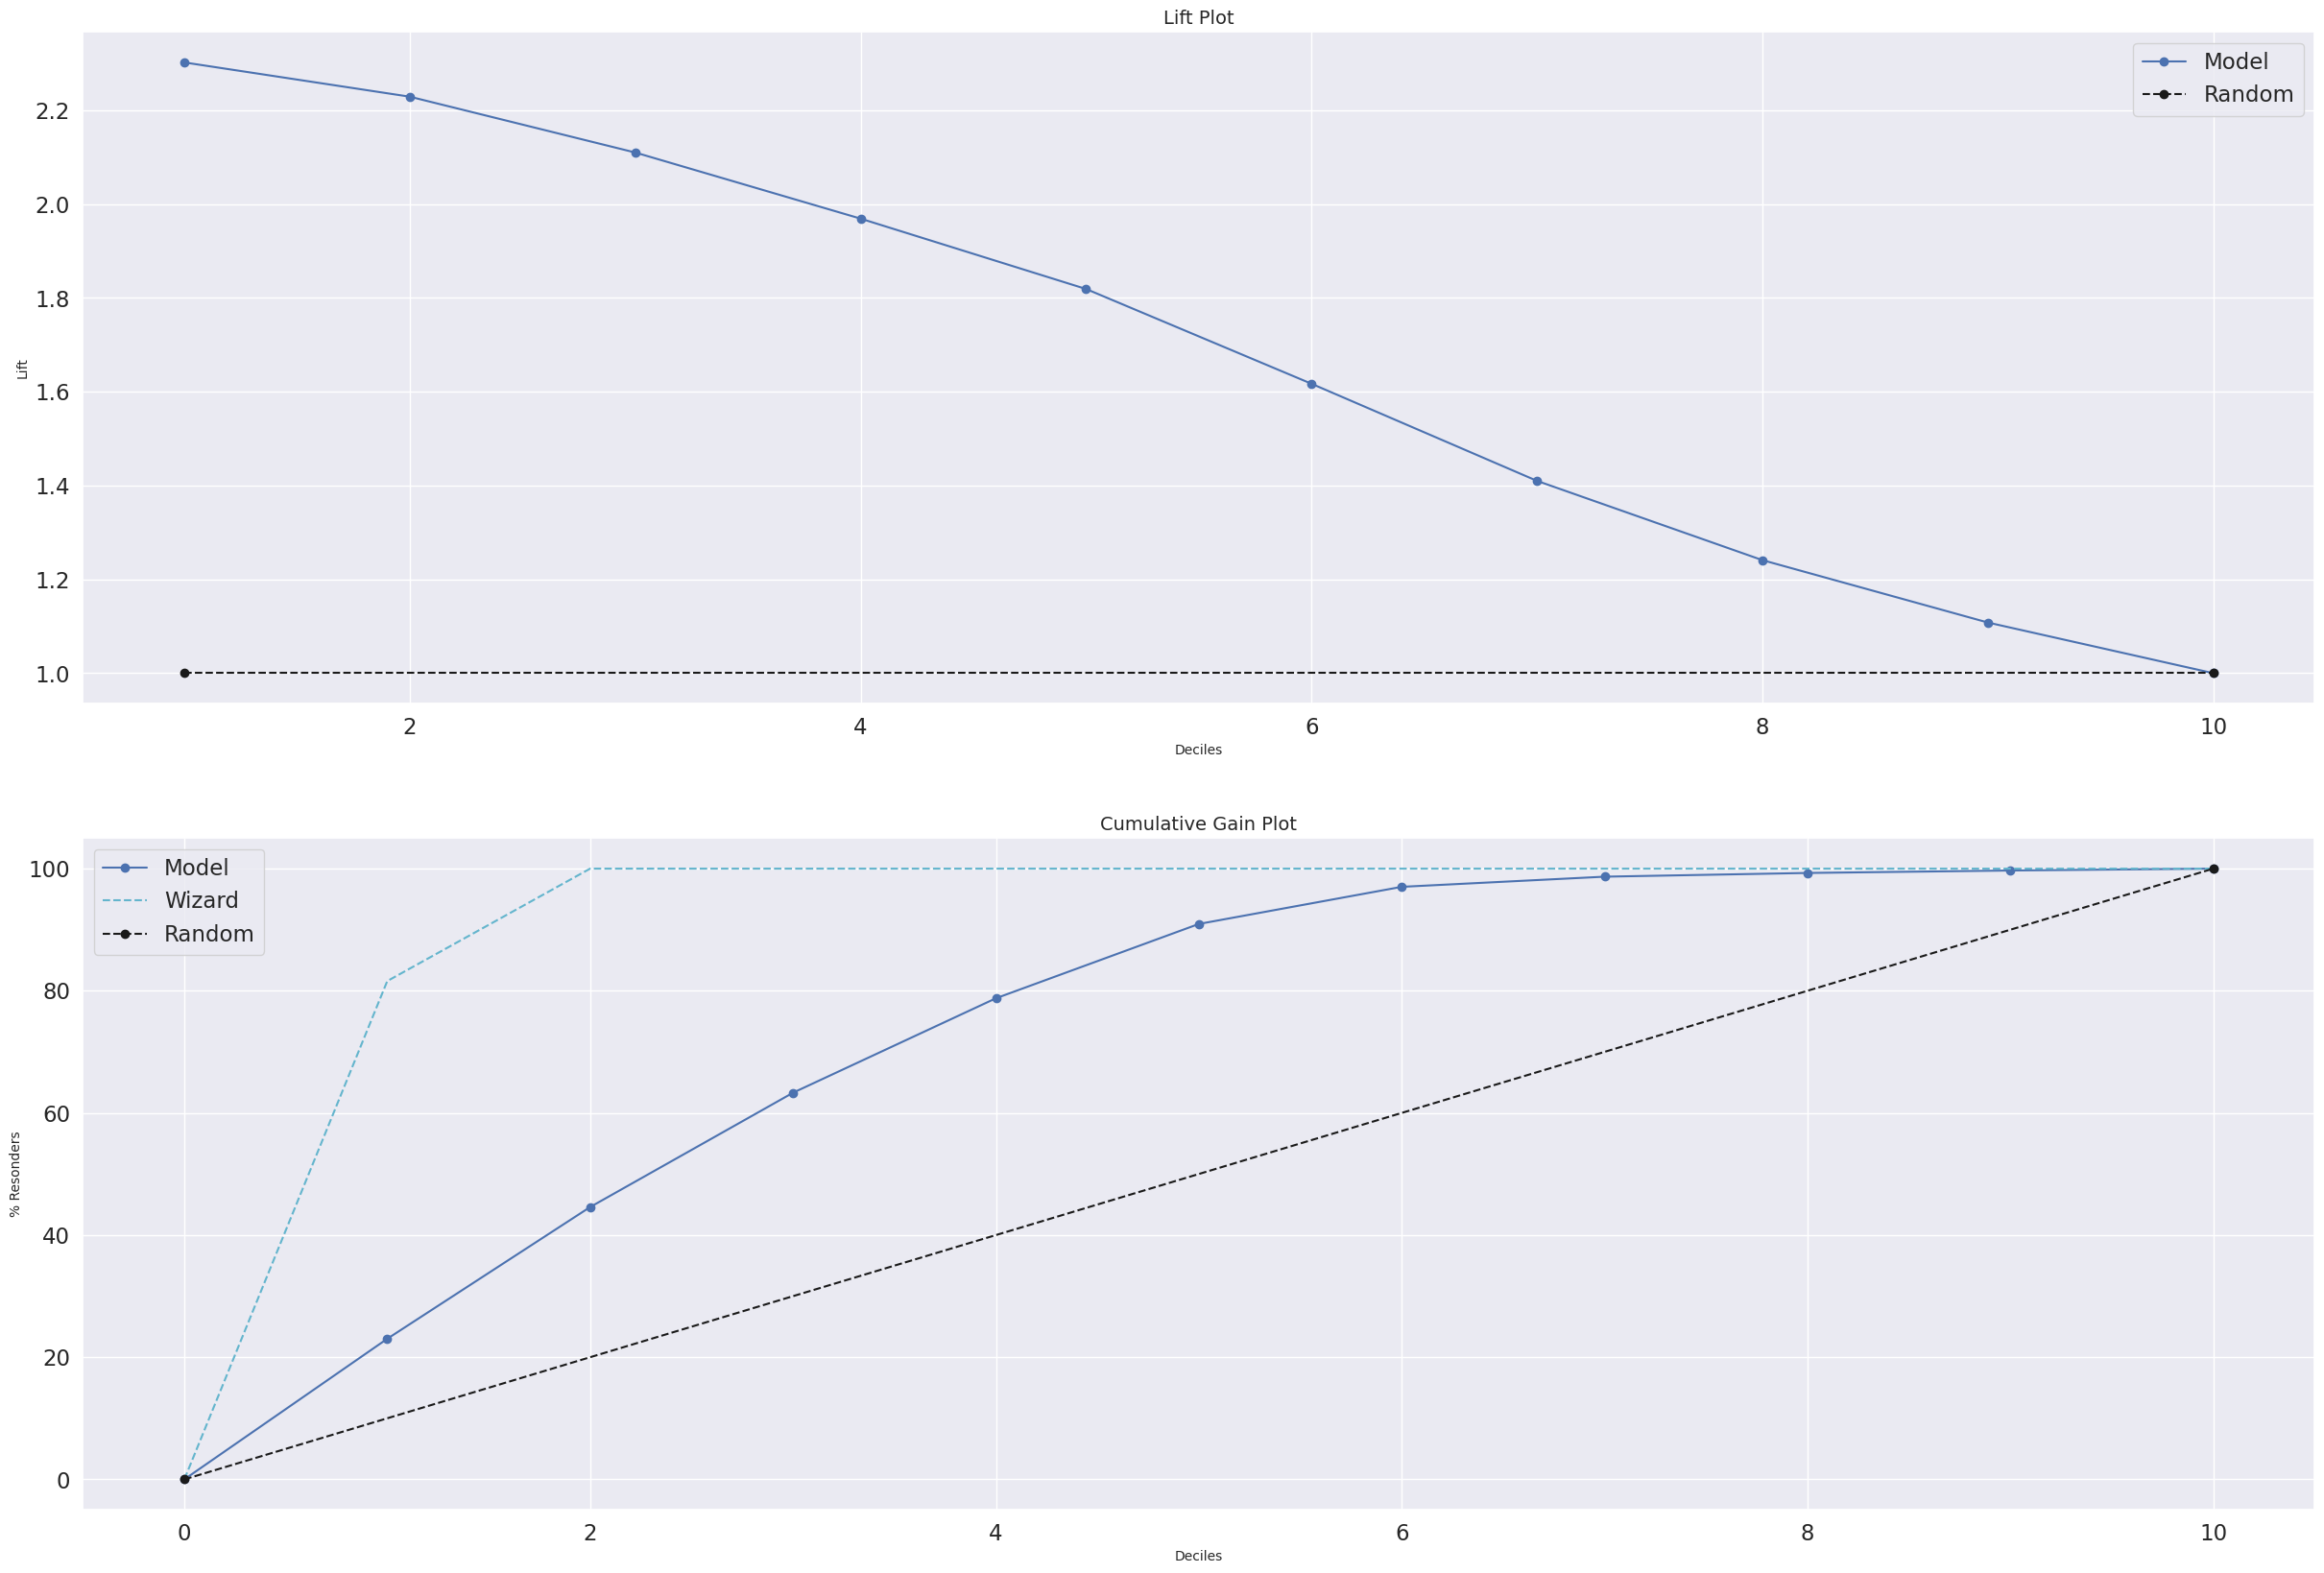

In [38]:
xgbc= XGBClassifier(objective='binary:logistic',
                    n_jobs=-1,n_estimators=500).fit(x_train, y_train)
y_predicted_proba_xgbc = xgbc.predict_proba(x_val)
y_predicted_xgbc = xgbc.predict(x_val)
plt.subplot(2,1,1)
kds.metrics.plot_lift(y_validation, y_predicted_proba_xgbc[:,1]);
plt.subplot(2,1,2)
kds.metrics.plot_cumulative_gain(y_validation,y_predicted_proba_xgbc[:,1]);

#### XGBoost Cross-validation

In [41]:
lift_xgbc = lift_score(y_validation,y_predicted_xgbc)
skf = StratifiedKFold(n_splits=10)
xgbc_cv_lift = []
for train_ix, test_ix in skf.split(x_train, y_train):
    X_train_cv, X_validation_cv = x_train.iloc[train_ix], x_train.iloc[test_ix]
    y_train_cv, y_validation_cv = y_train.iloc[train_ix], y_train.iloc[test_ix]
    xgbc_cv = XGBClassifier(objective='binary:logistic',
                    n_jobs=-1,n_estimators=500).fit(X_train_cv, y_train_cv)
    predictions = xgbc_cv.predict(X_validation_cv)
    xgbc_cv_lift.append( lift_score(y_validation_cv, predictions) )
    
xgbc_cv_mean_lift  = np.mean(xgbc_cv_lift )
xgbc_cv_std_lift  = np.std(xgbc_cv_lift )
    
xgbc_cv_result = pd.DataFrame({'model_name':'XGBoost','lift_score':lift_xgbc,'lift_score_cv': xgbc_cv_mean_lift,
                      'std_lift_cv':xgbc_cv_std_lift}, index=[0]) 
display(xgbc_cv_result)

model_name  lift_score  lift_score_cv  std_lift_cv
0    XGBoost        2.58           3.15         0.06

### Model's Perfomance

In [ ]:
df6 = X_validation.copy()
df6['response'] = y_validation.copy()

precision_at_20000_naive = precision_at_k(data=df6,k=20000,proba = y_predicted_proba_bayes)
recall_at_20000_naive = recall_at_k(data=df6,k=20000,proba = y_predicted_proba_bayes)
precision_at_20000_rf = precision_at_k(data=df6,k=20000,proba = y_predicted_proba_rf)
recall_at_20000_rf = recall_at_k(data=df6,k=20000,proba = y_predicted_proba_rf)
precision_at_20000_xgbc = precision_at_k(data=df6,k=20000,proba = y_predicted_proba_xgbc)
recall_at_20000_xgbc = recall_at_k(data=df6,k=20000,proba = y_predicted_proba_xgbc)

perfomance_at_20000 = pd.DataFrame({'model': ['naive_bayes','random_forest','XGBoost'], 
        'precision':[precision_at_20000_naive,precision_at_20000_rf,precision_at_20000_xgbc],
        'recall':[recall_at_20000_naive,recall_at_20000_rf,recall_at_20000_xgbc]}).sort_values(by='recall', ascending=False)
display(perfomance_at_20000)

# Hyperparameter Fine Tuning

In [ ]:
parameters = {
    'n_estimators': [300,500],
    'max_depth': [10,40,100,None],
    'min_samples_split': [5,40],
    'min_impurity_decrease': [0,0.1]
}
skf = StratifiedKFold(n_splits=5)
rf_search =  BayesSearchCV(estimator=RandomForestClassifier(max_features='sqrt'), search_spaces=parameters, 
                           n_jobs=-1, cv=skf, scoring='recall', random_state=42)
rf_search_result = rf_search.fit(x_train,y_train)
rf_search_result.best_params_

In [21]:
rf_search_result.best_params_

OrderedDict([('max_depth', None),
             ('min_impurity_decrease', 0.0),
             ('min_samples_split', 5),
             ('n_estimators', 300)])



# Final Model

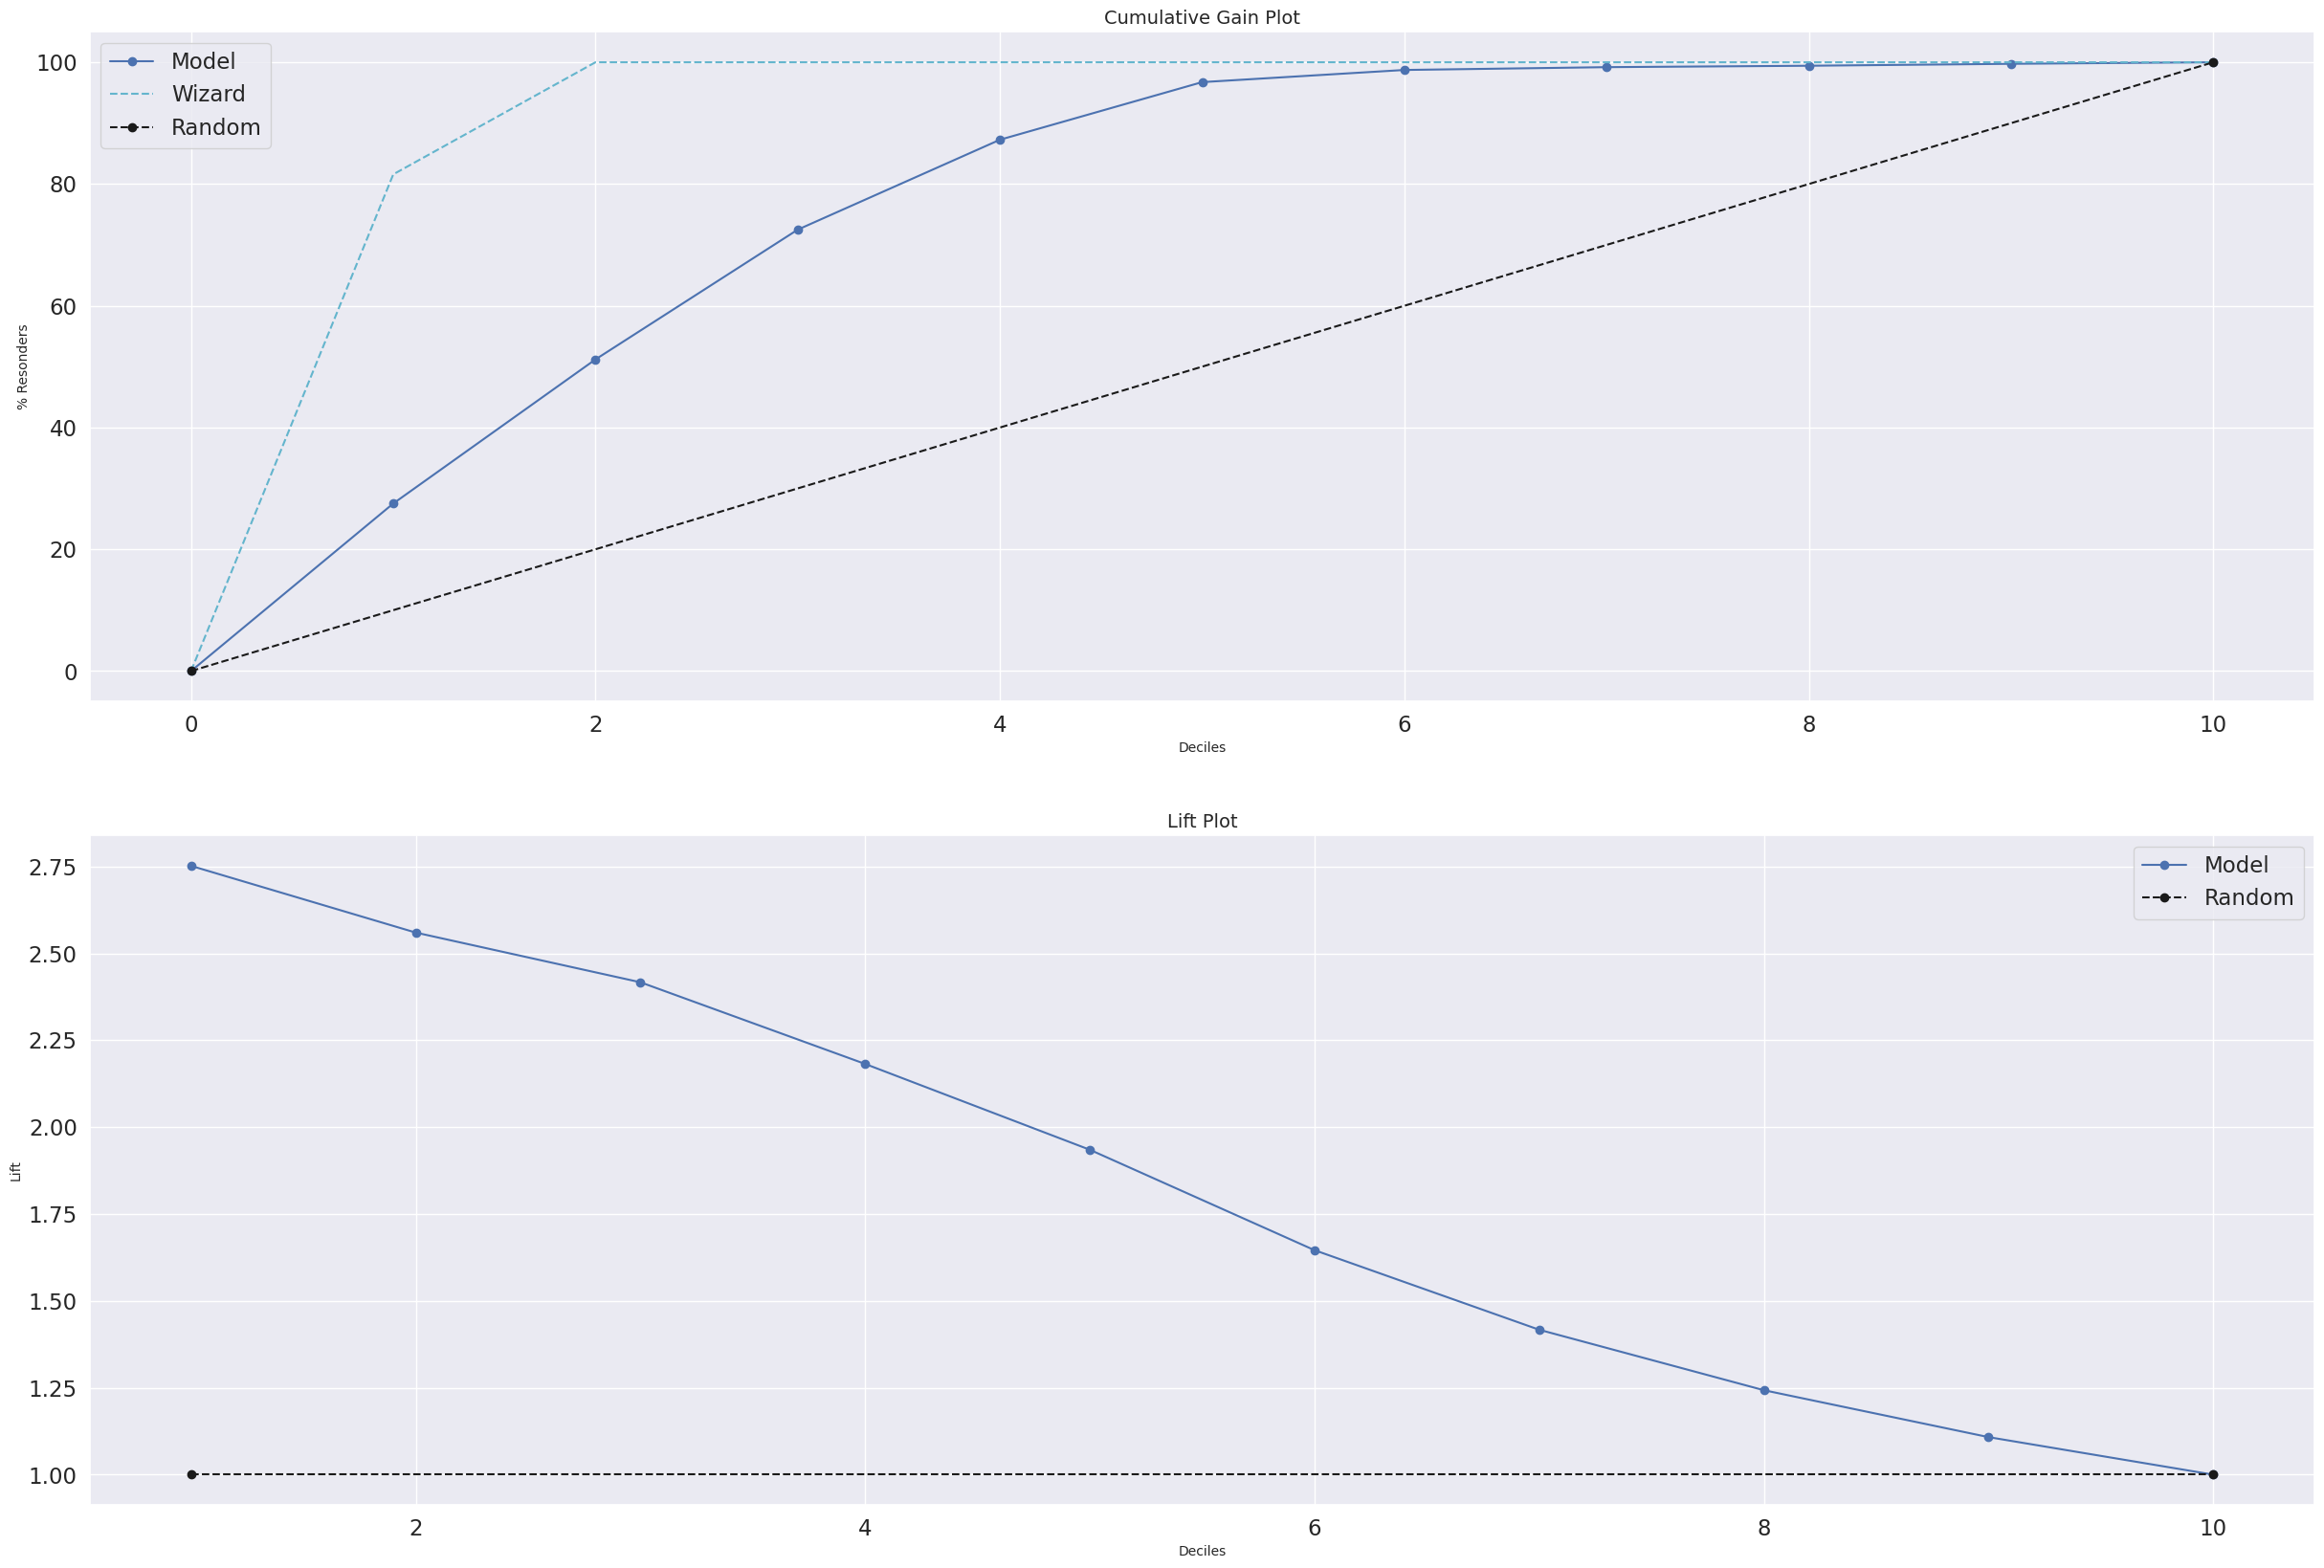

In [23]:
rf_final= RandomForestClassifier(random_state=42,n_jobs=-1, n_estimators=477,min_samples_split=40).fit(x_train, y_train)
y_predicted_proba_rf_final = rf_final.predict_proba(x_val)
y_predicted_rf_final = rf_final.predict(x_val)
plt.subplot(2,1,1)
kds.metrics.plot_cumulative_gain(y_validation,y_predicted_proba_rf_final[:,1] );
plt.subplot(2,1,2)
kds.metrics.plot_lift(y_validation,y_predicted_proba_rf_final[:,1] );
#save model
pickle.dump(rf_final, open('../src/models/insurance_cross-sell_rf_model.pkl', 'wb'))

# Deploy model to production

In [ ]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np
import csv
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, metrics
from sklearn.metrics import make_scorer
import math
import pickle
import inflection


class Insurance(object):
    def __init__(self):
        self.home_path = ' '
        self.vintage_scaler = pickle.load(open(self.home_path + 'src/features/vintage_scaler.pkl', 'rb') )
        self.annual_premium_scaler = pickle.load(open(self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb' ) )
        self.annual_premium_and_vintage_scaler = pickle.load(open(self.home_path + 'src/features/annual_premium_and_vintage_scaler.pkl', 'rb') )
        self.age_scaler = pickle.load(open(self.home_path + 'src/features/age.pkl', 'rb') )
        self.one_hot_encoding_scaler = pickle.load(open(self.home_path + 'src/features/one_hot_encoding_scaler.pkl', 'rb') )
        
    def data_cleaning(self,df):
        cols_old = df.columns.values

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        df.columns=cols_new

        df['driving_license'] = df['driving_license'].apply(lambda x: 'Yes' if x == 1 else 'No')
        df['previously_insured'] = df['previously_insured'].apply(lambda x: 'Yes' if x == 1 else 'No')

        return df

    
    def feature_engineering(self,df):
        df['annual_premium_and_vintage'] = df['annual_premium'] / df['vintage']
        
        return df
        
    
        
    def data_preparation(self,df):
        le = LabelEncoder()
        
        #Region code and policy_sales_channel
        df['region_code'] = le.fit_transform(df['region_code'])
        df['policy_sales_channel'] = le.fit_transform(df['policy_sales_channel'])
        
        #Gender, previously_insured,vehicle_damage,driver_license - one hot encoding
        transformed = self.one_hot_encoding_scaler.transform(df)
        transformed_df = pd.DataFrame(transformed, columns=self.one_hot_encoding_scaler.get_feature_names_out(), index=df.index)
        df = pd.concat([df,transformed_df],axis=1).drop(['gender', 'previously_insured','vehicle_damage','driving_license'], axis=1)

        #Rescaling - MinMaxScaler
        df['vintage'] = self.vintage_scaler.transform(df[['vintage']].values)
        df['annual_premium_and_vintage'] = self.annual_premium_and_vintage_scaler.transform(df[['annual_premium_and_vintage']].values)
        df['age'] = self.age_scaler.transform(df[['age']].values)

        #Rescaling - RobustScaler
        df['annual_premium'] = self.annual_premium_scaler.transform(df[['annual_premium']].values)

        #Age,vehicle_age and annual_premium - ordinal encoding
        vehicle_age_categories = {'< 1 Year':1,'1-2 Year':2, '> 2 Years':3}
        df['vehicle_age'] = df['vehicle_age'].map(vehicle_age_categories)
        
        return df
            
    def feature_selection(self,df):
        cols_selected = ['age','vehicle_age','annual_premium_and_vintage',
         'onehotencoder__vehicle_damage_Yes','onehotencoder__vehicle_damage_No',
         'policy_sales_channel','region_code', 'annual_premium','vintage']
        df = df[cols_selected]
        
        return df
    
    def prediction(self, model,transformed_data,original_data):
        pred = model.predict_proba(transformed_data)
        original_data['response'] = pred[:,1]
        original_data = original_data.sort_values(by='response', ascending=False)
        original_data['response'] = original_data['response'].apply(lambda x: str(round(x*100,2) ) + '%' )
            
        return original_data.to_json(orient='records', date_format='iso')

# API Handler

In [ ]:
import pickle 
import pandas as pd
from flask import Flask, request, Response
import insurance 
path = '/home/dbcordeiro/repos/cookiecutter-comunidadeds-master-insurance_cross-sell/insurance_cross-sell/'
model = pickle.load(open(path + 'src/models/insurance_cross-sell_rf_model.pkl', 'rb') ) 

#initializing API
app = Flask(__name__)

@app.route('/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): #unique example
            test_raw = pd.DataFrame(test_json, index=[0] )
        else: #multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys() )
    
        #Instantiate Insurance class
        pipeline = insurance.Insurance()

        #data cleaning
        df = pipeline.data_cleaning(test_raw)

        #creation of features
        df = pipeline.feature_engineering(df)

        #data preparation
        df = pipeline.data_preparation(df)

        #data selection
        df = pipeline.feature_selection(df)

        #prediction
        df_response = pipeline.prediction(model,transformed_data = df,original_data= test_raw)

        return df_response
    
    else: 
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)
        